In [615]:
# (1) Importing dependency
#Essentials
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
import plotly.graph_objects as go
import pickle

#Image
from PIL import Image
import cv2

#Sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

#Keras
import keras
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import regularizers
from keras.layers import LeakyReLU
from keras.optimizers import SGD
from keras import backend
from keras.models import load_model

%matplotlib inline

In [139]:
dbs = []
headers = ['link','country','cat1','cat2','cat3','cat4','product','product_title',
'rating_star','overall_rating','company','price',
'product_highlights','product_length','product_width','product_height',
'product_weight','asin','pd_unit','best_seller_cat','best_seller_prod',
'weight_unit','shipping_weight','shipping_weight_unit','crr_5','crr_4',
'crr_3','crr_2','crr_1','crr_fr_1','crr_fr_2','crr_fr_3','tags','images_link']
df_temp = pd.DataFrame(columns=headers)
for root, dirs, files in os.walk("/home/jishu/database_new/"):
    for file in files:
        if file.endswith(".db"):
            os.chdir(os.path.join(root))
    #             print(os.path.join(root),file)
            conn = sqlite3.connect(file)
            df = pd.read_sql('''SELECT * FROM Product''', conn)
            df.drop(columns = ['index'],axis=1,inplace=True)
            df_temp = df_temp.append(df)
            dbs.append(os.path.join(root))

### Tags Dataframe

In [512]:
df_temp_ph = df_temp[df_temp['product_highlights']!='Not Available']
df_temp_ph = df_temp_ph[df_temp_ph['tags']!='None']
tags_lst = []
for i in df_temp_ph['tags']:
    split_tags = i.split('<CPT14>')
    tags_series = pd.Series(data=1, index=split_tags)
    tags_lst.append(tags_series)
df_tags = pd.concat(tags_lst, axis=1).T.fillna(0)
df_temp_filtered = df_temp_ph[['country','company','product_highlights','tags']]
df_temp_filtered.reset_index(drop=True,inplace=True)
df_tags_main = pd.merge(df_temp_filtered,df_tags,left_index=True, right_index=True, how='outer')
df_tags_usa = df_tags_main[df_tags_main['country']=='USA']
df_tags_aus = df_tags_main[df_tags_main['country']=='Australia']
df_tags_uk = df_tags_main[df_tags_main['country']=='UK']
df_tags_india = df_tags_main[df_tags_main['country']=='India']
tags_dataframes = {'USA':df_tags_usa,
                   'India':df_tags_india,
                   'UK':df_tags_uk,
                   'Australia':df_tags_aus}

### Data Wrangling - USA

In [577]:
#data
df_usa = df_temp[df_temp['country']=='USA']
df_usa_temp = df_usa[df_usa['rating_star']!='Not Scrapable']
usa_shampoo = df_usa_temp[df_usa_temp['product']=='shampoo']

In [578]:
usa_shampoo.iloc[:,:15].head()

link country  \
0  https://www.amazon.com/Fanola-No-Yellow-Shampo...     USA   
1  https://www.amazon.com/Olaplex-No-4-Bond-Maint...     USA   
2  https://www.amazon.com/Fanola-No-Yellow-Shampo...     USA   
3  https://www.amazon.com/Fanola-No-Yellow-Shampo...     USA   
4  https://www.amazon.com/Fanola-No-Yellow-Shampo...     USA   

                cat1           cat2  cat3  cat4  product  \
0  health_and_beauty  hair_products  None  None  shampoo   
1  health_and_beauty  hair_products  None  None  shampoo   
2  health_and_beauty  hair_products  None  None  shampoo   
3  health_and_beauty  hair_products  None  None  shampoo   
4  health_and_beauty  hair_products  None  None  shampoo   

                                      product_title rating_star  \
0              Fanola No Yellow Shampoo, 11.8 Fl Oz         4.4   
1  Olaplex No.4 Bond Maintenance Shampoo, 8.5 Fl oz         4.6   
2              Fanola No Yellow Shampoo, 11.8 Fl Oz         4.4   
3              Fanola No Yellow Shampoo, 11.8 Fl Oz         4.4   
4              Fanola No Yellow Shampoo, 11.8 Fl Oz         4.4   

  overall_rating        company price  \
0          18787         Fanola  0.48   
1           2519  Not Scrapable     0   
2          18787         Fanola  0.48   
3          18787         Fanola  0.48   
4          18787         Fanola  0.48   

                                  product_highlights product_length  \
0  Ideal, for grey, super lightened, or decolored...            2.4   
1                                      Not Available            5.2   
2  Ideal, for grey, super lightened, or decolored...            2.4   
3  Ideal, for grey, super lightened, or decolored...            2.4   
4  Ideal, for grey, super lightened, or decolored...            2.4   

  product_width  
0           2.8  
1           2.2  
2           2.8  
3           2.8  
4           2.8

In [579]:
usa_shampoo.iloc[:,15:].head()

product_height product_weight        asin pd_unit best_seller_cat  \
0            7.5           11.2  B00RWCDM4A  inches             196   
1            2.2              8  B07D37PQGL  inches             190   
2            7.5           11.2  B00RWCDM4A  inches             196   
3            7.5           11.2  B00RWCDM4A  inches             196   
4            7.5           11.2  B00RWCDM4A  inches             196   

  best_seller_prod weight_unit shipping_weight shipping_weight_unit crr_5  \
0                4      ounces            14.1               ounces    72   
1                2      ounces            10.6               ounces    83   
2                4      ounces            14.1               ounces    72   
3                4      ounces            14.1               ounces    72   
4                4      ounces            14.1               ounces    72   

  crr_4 crr_3 crr_2 crr_1 crr_fr_1 crr_fr_2 crr_fr_3  \
0    11     6     3     8      3.8      3.4      3.3   
1     7     4     1     5      4.5      4.5      4.5   
2    11     6     3     8      3.8      3.4      3.3   
3    11     6     3     8      3.8      3.4      3.3   
4    11     6     3     8      3.8      3.3      3.4   

                                                tags  \
0  regular shampoo<CPT14>blonde hair<CPT14>dry ha...   
1  shampoo and conditioner<CPT14>best shampoo<CPT...   
2  regular shampoo<CPT14>Softness<CPT14>highly re...   
3  regular shampoo<CPT14>Softness<CPT14>highly re...   
4  regular shampoo<CPT14>Softness<CPT14>highly re...   

                                         images_link  
0  Amazon_USA/health_and_beauty/hair_products/sha...  
1  Amazon_USA/health_and_beauty/hair_products/sha...  
2  Amazon_USA/health_and_beauty/hair_products/sha...  
3  Amazon_USA/health_and_beauty/hair_products/sha...  
4  Amazon_USA/health_and_beauty/hair_products/sha...

In [580]:
usa_shampoo['pd_unit'] = usa_shampoo['pd_unit'].astype('str')
usa_shampoo['pd_unit'] = usa_shampoo['pd_unit'].str.replace('ounces','Not Scrapable')
usa_shampoo['pd_unit'] = usa_shampoo['pd_unit'].str.replace('pounds','Not Scrapable')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [581]:
usa_shampoo.columns

Index(['link', 'country', 'cat1', 'cat2', 'cat3', 'cat4', 'product',
       'product_title', 'rating_star', 'overall_rating', 'company', 'price',
       'product_highlights', 'product_length', 'product_width',
       'product_height', 'product_weight', 'asin', 'pd_unit',
       'best_seller_cat', 'best_seller_prod', 'weight_unit', 'shipping_weight',
       'shipping_weight_unit', 'crr_5', 'crr_4', 'crr_3', 'crr_2', 'crr_1',
       'crr_fr_1', 'crr_fr_2', 'crr_fr_3', 'tags', 'images_link'],
      dtype='object')

In [582]:
usa_shampoo['shipping_weight'] = usa_shampoo['shipping_weight'].astype('str')
usa_shampoo['shipping_weight'] = usa_shampoo['shipping_weight'].str.replace('Not Scrapable','0')
usa_shampoo['shipping_weight'] = usa_shampoo['shipping_weight'].str.replace(',','')
usa_shampoo['shipping_weight'] = usa_shampoo['shipping_weight'].astype('float')
usa_shampoo['product_length'] = usa_shampoo['product_length'].astype('str')
usa_shampoo['product_length'] = usa_shampoo['product_length'].str.replace('Not Scrapable','0')
usa_shampoo['product_length'] = usa_shampoo['product_length'].str.replace(',','')
usa_shampoo['product_length'] = usa_shampoo['product_length'].astype('float')
usa_shampoo['product_height'] = usa_shampoo['product_height'].astype('str')
usa_shampoo['product_height'] = usa_shampoo['product_height'].str.replace('Not Scrapable','0')
usa_shampoo['product_height'] = usa_shampoo['product_height'].str.replace(',','')
usa_shampoo['product_height'] = usa_shampoo['product_height'].astype('float')
usa_shampoo['product_width'] = usa_shampoo['product_width'].astype('str')
usa_shampoo['product_width'] = usa_shampoo['product_width'].str.replace('Not Scrapable','0')
usa_shampoo['product_width'] = usa_shampoo['product_width'].str.replace(',','')
usa_shampoo['product_width'] = usa_shampoo['product_width'].astype('float')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [583]:
usa_shampoo.reset_index(inplace=True,drop=True)
usa_shampoo[['shipping_weight','shipping_weight_unit']]

shipping_weight shipping_weight_unit
0                14.1               ounces
1                10.6               ounces
2                14.1               ounces
3                14.1               ounces
4                14.1               ounces
...               ...                  ...
3997             12.5               ounces
3998              7.2               ounces
3999              2.2               pounds
4000             10.4               ounces
4001             15.7               ounces

[4002 rows x 2 columns]

In [584]:
#3998:2.2
for i in range(len(usa_shampoo)):
    if usa_shampoo.loc[i,'shipping_weight_unit'] == 'pounds':
        usa_shampoo.loc[i,'shipping_weight'] = usa_shampoo.loc[i,'shipping_weight']*16
    else:
        pass

/home/ubuntu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [585]:
usa_shampoo_impute = usa_shampoo[['shipping_weight','product_length','product_width','product_height']]

In [586]:
#Imputation
imputer = KNNImputer(missing_values=0,n_neighbors=10)
usa_shampoo_impute = imputer.fit_transform(usa_shampoo_impute)
usa_shampoo_impute = pd.DataFrame(usa_shampoo_impute,columns=['shipping_weight','product_length','product_width','product_height'])

In [587]:
usa_shampoo['shipping_weight'] = usa_shampoo_impute['shipping_weight']
usa_shampoo['product_length'] = usa_shampoo_impute['product_length']
usa_shampoo['product_width'] = usa_shampoo_impute['product_width']
usa_shampoo['product_height'] = usa_shampoo_impute['product_height']
usa_shampoo['pd_unit'] = 'inches'
usa_shampoo['shipping_weight_unit'] = 'ounces'

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [588]:
Counter(usa_shampoo['shipping_weight_unit'])

Counter({'ounces': 4002})

In [589]:
Counter(usa_shampoo['weight_unit'])

Counter({'ounces': 1834, 'pounds': 1032, 'Not Scrapable': 1136})

In [590]:
Counter(usa_shampoo['pd_unit'])

Counter({'inches': 4002})

In [591]:
usa_shampoo_input = usa_shampoo[['asin','product_title',
                                 'product_length',
                                 'product_height',
                                 'product_width',
                                 'shipping_weight']]
usa_shampoo_input.reset_index(inplace=True)

In [592]:
usa_shampoo_input.head()

index        asin                                     product_title  \
0      0  B00RWCDM4A              Fanola No Yellow Shampoo, 11.8 Fl Oz   
1      1  B07D37PQGL  Olaplex No.4 Bond Maintenance Shampoo, 8.5 Fl oz   
2      2  B00RWCDM4A              Fanola No Yellow Shampoo, 11.8 Fl Oz   
3      3  B00RWCDM4A              Fanola No Yellow Shampoo, 11.8 Fl Oz   
4      4  B00RWCDM4A              Fanola No Yellow Shampoo, 11.8 Fl Oz   

   product_length  product_height  product_width  shipping_weight  
0             2.4             7.5            2.8             14.1  
1             5.2             2.2            2.2             10.6  
2             2.4             7.5            2.8             14.1  
3             2.4             7.5            2.8             14.1  
4             2.4             7.5            2.8             14.1

In [593]:
usa_shampoo_features = usa_shampoo[['asin','product_title','rating_star',
                                    'overall_rating','best_seller_cat',
                                    'best_seller_prod','crr_5', 'crr_4', 
                                    'crr_3','crr_2','crr_1', 'crr_fr_1', 
                                    'crr_fr_2', 'crr_fr_3']]
usa_shampoo_features.reset_index(inplace=True)

In [594]:
shampoo_images_link = '/home/jishu/database_new/Amazon_USA/health_and_beauty/hair_products/shampoo/images/'
os.chdir(os.path.join(shampoo_images_link))

In [595]:
def load_image(infilename) :
    img = cv2.imread(infilename)
    target_size = (128,128)
    data = cv2.resize(img, target_size)
    return data

In [596]:
images_usa = []
fails = []
for image in range(len(usa_shampoo_features)):
    try:
        images_usa.append(load_image(shampoo_images_link+usa_shampoo_features['asin'][image]+'_0.jpg'))
    except:
        try:
            images_usa.append(load_image(shampoo_images_link+usa_shampoo_features['product_title'][image]+'_0.jpg'))
        except:
            fails.append(image)

In [597]:
for i in fails:
    usa_shampoo_features.drop(index=i,axis=0,inplace=True)
    usa_shampoo_input.drop(index=i,axis=0,inplace=True)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [598]:
feature_columns = ['rating_star', 'overall_rating',
       'best_seller_cat', 'best_seller_prod', 'crr_5', 'crr_4', 'crr_3',
       'crr_2', 'crr_1', 'crr_fr_1', 'crr_fr_2', 'crr_fr_3']

In [599]:
usa_shampoo_features['rating_star'] = usa_shampoo_features['rating_star'].astype('str')
usa_shampoo_features['overall_rating'] = usa_shampoo_features['overall_rating'].astype('str')
usa_shampoo_features['best_seller_cat'] = usa_shampoo_features['best_seller_cat'].astype('str')
usa_shampoo_features['best_seller_prod'] = usa_shampoo_features['best_seller_prod'].astype('str')
usa_shampoo_features['crr_5'] = usa_shampoo_features['crr_5'].astype('str')
usa_shampoo_features['crr_4'] = usa_shampoo_features['crr_4'].astype('str')
usa_shampoo_features['crr_3'] = usa_shampoo_features['crr_3'].astype('str')
usa_shampoo_features['crr_2'] = usa_shampoo_features['crr_2'].astype('str')
usa_shampoo_features['crr_1'] = usa_shampoo_features['crr_1'].astype('str')
usa_shampoo_features['crr_fr_1'] = usa_shampoo_features['crr_fr_1'].astype('str')
usa_shampoo_features['crr_fr_2'] = usa_shampoo_features['crr_fr_2'].astype('str')
usa_shampoo_features['crr_fr_3'] = usa_shampoo_features['crr_fr_3'].astype('str')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [600]:
for column in feature_columns:
    print(column)
    usa_shampoo_features[column] = usa_shampoo_features[column].str.replace('Not Scrapable','0')
    usa_shampoo_features[column] = usa_shampoo_features[column].str.replace(',','')

rating_star
overall_rating
best_seller_cat
best_seller_prod
crr_5
crr_4
crr_3
crr_2
crr_1
crr_fr_1
crr_fr_2
crr_fr_3


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [601]:
usa_shampoo_features['rating_star'] = usa_shampoo_features['rating_star'].astype('float')
usa_shampoo_features['overall_rating'] = usa_shampoo_features['overall_rating'].astype('float')
usa_shampoo_features['best_seller_cat'] = usa_shampoo_features['best_seller_cat'].astype('float')
usa_shampoo_features['best_seller_prod'] = usa_shampoo_features['best_seller_prod'].astype('float')
usa_shampoo_features['crr_5'] = usa_shampoo_features['crr_5'].astype('float')
usa_shampoo_features['crr_4'] = usa_shampoo_features['crr_4'].astype('float')
usa_shampoo_features['crr_3'] = usa_shampoo_features['crr_3'].astype('float')
usa_shampoo_features['crr_2'] = usa_shampoo_features['crr_2'].astype('float')
usa_shampoo_features['crr_1'] = usa_shampoo_features['crr_1'].astype('float')
usa_shampoo_features['crr_fr_1'] = usa_shampoo_features['crr_fr_1'].astype('float')
usa_shampoo_features['crr_fr_2'] = usa_shampoo_features['crr_fr_2'].astype('float')
usa_shampoo_features['crr_fr_3'] = usa_shampoo_features['crr_fr_3'].astype('float')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [602]:
#Scaling Sales Rank
scaler = MinMaxScaler()
usa_shampoo_features[['overall_rating',
                      'best_seller_cat',
                      'best_seller_prod']] = scaler.fit_transform(usa_shampoo_features[['overall_rating','best_seller_cat','best_seller_prod']])
usa_shampoo_features['best_seller_cat'] = 1 - usa_shampoo_features['best_seller_cat']
usa_shampoo_features['best_seller_prod'] = 1 - usa_shampoo_features['best_seller_prod']

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [603]:
#Defining Target
weights = [1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
usa_shampoo_features['target'] = 0
for i in range(len(usa_shampoo_features)):
    try:
        usa_shampoo_features.loc[i,'target'] = np.average(list(usa_shampoo_features.loc[i,feature_columns]),weights = weights)
    except:
        pass

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [604]:
#Scaling within range 1-10
def scaling(x,a,b,minimum,maximum):
    return float(((b-a)*(x-minimum)/(maximum-minimum))+a)

In [605]:
min_tar_usa = min(usa_shampoo_features['target'])
max_tar_usa = max(usa_shampoo_features['target'])
usa_shampoo_features['target'] = usa_shampoo_features['target'].apply(lambda x: scaling(x,1,10,min_tar_usa,max_tar_usa))

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



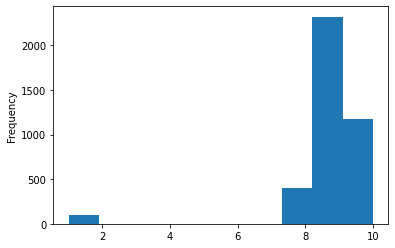

In [606]:
usa_shampoo_features['target'].plot(kind='hist')

### Modelling - USA

In [607]:
usa_shampoo_features['target'].shape

(4001,)

In [608]:
np.array(images_usa).shape

(4001, 128, 128, 3)

In [609]:
meta_input_usa = usa_shampoo_input[['product_length','product_height','product_width','shipping_weight']].values

In [610]:
meta_input_usa = meta_input_usa.reshape(4001,4,1,1)

In [611]:
#Main Model
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# first input model
visible1 = Input(shape=(128,128,3),name='main_input')
conv11 = Conv2D(96, kernel_size=(3,3),strides=(4,4),activation='relu',
                padding='valid')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
batch11 = BatchNormalization()(pool11)

conv12 = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu',
                padding='valid')(batch11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
batch12 = BatchNormalization()(pool12)

conv13 = Conv2D(32, kernel_size=(3,3),strides=(2,2),activation='relu',
                padding='valid')(batch12)
pool13 = MaxPooling2D(pool_size=(1, 1))(conv13)
batch13 = BatchNormalization()(pool13)

# conv14 = Conv2D(16, kernel_size=(5,5),strides=(2,2),activation='relu',
#                 padding='valid')(batch13)
# pool14 = MaxPooling2D(pool_size=(2, 2))(conv14)
# batch14 = BatchNormalization()(pool14)

# conv15 = Conv2D(8, kernel_size=(5,5),strides=(2,2),activation='relu',
#                 padding='valid')(batch14)
# pool15 = MaxPooling2D(pool_size=(2, 2))(conv15)
# batch15 = BatchNormalization()(pool15)
flat1 = Flatten()(batch13)

# second input model
visible2 = Input(shape=(4,1,1),name='meta_input')
hidden21 = Dense(10, activation='relu')(visible2)
hidden22 = Dense(20, activation='relu')(hidden21)
hidden23 = Dense(10, activation='relu')(hidden22)
flat2 = Flatten()(hidden23)

# merge input models
merge = concatenate([flat1, flat2])
# interpretation model
hidden1 = Dense(10, activation='relu')(merge)
hidden2 = Dense(10, activation='relu')(hidden1)
hidden3 = LeakyReLU(alpha=0.3)(hidden2)
output = Dense(1,name='output')(hidden3)

model_usa_shampoo = Model(inputs=[visible1, visible2], outputs=output)
opt = SGD(lr=0.01, momentum=0.9,clipnorm=1.0)

# compiling
model_usa_shampoo.compile(optimizer=opt, 
              loss='mean_absolute_error',
              metrics=['mean_squared_error',
                       'mean_absolute_error',
                       'mean_absolute_percentage_error',
                       'cosine_proximity'])

# And trained it via:
history_usa_shampoo = model_usa_shampoo.fit(x = {'main_input': np.array(images_usa), 
                                                 'meta_input': meta_input_usa},
                                                  y = {'output': usa_shampoo_features['target'].values},
                                                  epochs=1000, 
                                                  batch_size=32,
                                                  verbose=1)

# summarize layers
print(model_usa_shampoo.summary())
model_link = '/home/jishu/database_new/models/health_and_beauty/hair_products/shampoo/'
os.chdir(os.path.join(model_link))
model_usa_shampoo.save("usa_shampoo.h5")

Epoch 1/1000
4001/4001 [==============================] - 2s 605us/step - loss: 3.8437 - mean_squared_error: 60.1501 - mean_absolute_error: 3.8437 - mean_absolute_percentage_error: 50.2928 - cosine_proximity: 0.8718
Epoch 2/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.9029 - mean_squared_error: 2.5706 - mean_absolute_error: 0.9029 - mean_absolute_percentage_error: 17.6093 - cosine_proximity: 1.0000
Epoch 3/1000
4001/4001 [==============================] - 2s 449us/step - loss: 0.7885 - mean_squared_error: 1.8258 - mean_absolute_error: 0.7885 - mean_absolute_percentage_error: 16.2803 - cosine_proximity: 1.0000
Epoch 4/1000
4001/4001 [==============================] - 2s 452us/step - loss: 0.7249 - mean_squared_error: 1.6204 - mean_absolute_error: 0.7249 - mean_absolute_percentage_error: 15.4934 - cosine_proximity: 1.0000
Epoch 5/1000
4001/4001 [==============================] - 2s 446us/step - loss: 0.6912 - mean_squared_error: 1.5865 - mean_absolute_error: 

4001/4001 [==============================] - 2s 453us/step - loss: 0.4119 - mean_squared_error: 0.9972 - mean_absolute_error: 0.4119 - mean_absolute_percentage_error: 11.3620 - cosine_proximity: 1.0000
Epoch 39/1000
4001/4001 [==============================] - 2s 449us/step - loss: 0.4661 - mean_squared_error: 1.0296 - mean_absolute_error: 0.4661 - mean_absolute_percentage_error: 11.9138 - cosine_proximity: 1.0000
Epoch 40/1000
4001/4001 [==============================] - 2s 443us/step - loss: 0.4102 - mean_squared_error: 0.9842 - mean_absolute_error: 0.4102 - mean_absolute_percentage_error: 11.2978 - cosine_proximity: 1.0000
Epoch 41/1000
4001/4001 [==============================] - 2s 452us/step - loss: 0.4213 - mean_squared_error: 0.9897 - mean_absolute_error: 0.4213 - mean_absolute_percentage_error: 11.4024 - cosine_proximity: 1.0000
Epoch 42/1000
4001/4001 [==============================] - 2s 463us/step - loss: 0.4116 - mean_squared_error: 0.9903 - mean_absolute_error: 0.4116 - m

Epoch 76/1000
4001/4001 [==============================] - 2s 468us/step - loss: 0.3554 - mean_squared_error: 0.8117 - mean_absolute_error: 0.3554 - mean_absolute_percentage_error: 10.1088 - cosine_proximity: 1.0000
Epoch 77/1000
4001/4001 [==============================] - 2s 467us/step - loss: 0.3710 - mean_squared_error: 0.8319 - mean_absolute_error: 0.3710 - mean_absolute_percentage_error: 10.3563 - cosine_proximity: 1.0000
Epoch 78/1000
4001/4001 [==============================] - 2s 472us/step - loss: 0.3730 - mean_squared_error: 0.8346 - mean_absolute_error: 0.3730 - mean_absolute_percentage_error: 10.3681 - cosine_proximity: 1.0000
Epoch 79/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.3570 - mean_squared_error: 0.8040 - mean_absolute_error: 0.3570 - mean_absolute_percentage_error: 10.1056 - cosine_proximity: 1.0000
Epoch 80/1000
4001/4001 [==============================] - 2s 467us/step - loss: 0.3334 - mean_squared_error: 0.7874 - mean_absolute_err

4001/4001 [==============================] - 2s 477us/step - loss: 0.1742 - mean_squared_error: 0.1282 - mean_absolute_error: 0.1742 - mean_absolute_percentage_error: 3.0259 - cosine_proximity: 1.0000
Epoch 115/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.1713 - mean_squared_error: 0.1209 - mean_absolute_error: 0.1713 - mean_absolute_percentage_error: 3.0571 - cosine_proximity: 0.9995
Epoch 116/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.1711 - mean_squared_error: 0.1256 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 2.9902 - cosine_proximity: 0.9995
Epoch 117/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.1614 - mean_squared_error: 0.1155 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 2.7930 - cosine_proximity: 1.0000
Epoch 118/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.1678 - mean_squared_error: 0.1180 - mean_absolute_error: 0.1678 - m

Epoch 152/1000
4001/4001 [==============================] - 2s 479us/step - loss: 0.1264 - mean_squared_error: 0.0800 - mean_absolute_error: 0.1264 - mean_absolute_percentage_error: 2.2964 - cosine_proximity: 1.0000
Epoch 153/1000
4001/4001 [==============================] - 2s 485us/step - loss: 0.1340 - mean_squared_error: 0.0949 - mean_absolute_error: 0.1340 - mean_absolute_percentage_error: 2.4297 - cosine_proximity: 1.0000
Epoch 154/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.1504 - mean_squared_error: 0.0972 - mean_absolute_error: 0.1504 - mean_absolute_percentage_error: 2.6284 - cosine_proximity: 1.0000
Epoch 155/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.1259 - mean_squared_error: 0.0852 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 2.4449 - cosine_proximity: 1.0000
Epoch 156/1000
4001/4001 [==============================] - 2s 473us/step - loss: 0.1327 - mean_squared_error: 0.0880 - mean_absolute_er

4001/4001 [==============================] - 2s 474us/step - loss: 0.1077 - mean_squared_error: 0.0701 - mean_absolute_error: 0.1077 - mean_absolute_percentage_error: 2.0155 - cosine_proximity: 1.0000
Epoch 190/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.1076 - mean_squared_error: 0.0707 - mean_absolute_error: 0.1076 - mean_absolute_percentage_error: 1.9756 - cosine_proximity: 1.0000
Epoch 191/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.1043 - mean_squared_error: 0.0770 - mean_absolute_error: 0.1043 - mean_absolute_percentage_error: 1.9926 - cosine_proximity: 1.0000
Epoch 192/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.1020 - mean_squared_error: 0.0692 - mean_absolute_error: 0.1020 - mean_absolute_percentage_error: 1.9288 - cosine_proximity: 1.0000
Epoch 193/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.1043 - mean_squared_error: 0.0758 - mean_absolute_error: 0.1043 - m

Epoch 227/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0970 - mean_squared_error: 0.0651 - mean_absolute_error: 0.0970 - mean_absolute_percentage_error: 1.7617 - cosine_proximity: 1.0000
Epoch 228/1000
4001/4001 [==============================] - 2s 472us/step - loss: 0.0917 - mean_squared_error: 0.0681 - mean_absolute_error: 0.0917 - mean_absolute_percentage_error: 1.6985 - cosine_proximity: 1.0000
Epoch 229/1000
4001/4001 [==============================] - 2s 473us/step - loss: 0.1014 - mean_squared_error: 0.0664 - mean_absolute_error: 0.1014 - mean_absolute_percentage_error: 1.8015 - cosine_proximity: 1.0000
Epoch 230/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.1048 - mean_squared_error: 0.0703 - mean_absolute_error: 0.1048 - mean_absolute_percentage_error: 1.8670 - cosine_proximity: 1.0000
Epoch 231/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0965 - mean_squared_error: 0.0665 - mean_absolute_er

4001/4001 [==============================] - 2s 476us/step - loss: 0.0990 - mean_squared_error: 0.0641 - mean_absolute_error: 0.0990 - mean_absolute_percentage_error: 1.6430 - cosine_proximity: 1.0000
Epoch 265/1000
4001/4001 [==============================] - 2s 465us/step - loss: 0.0887 - mean_squared_error: 0.0613 - mean_absolute_error: 0.0887 - mean_absolute_percentage_error: 1.5626 - cosine_proximity: 1.0000
Epoch 266/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.1103 - mean_squared_error: 0.0734 - mean_absolute_error: 0.1103 - mean_absolute_percentage_error: 1.8162 - cosine_proximity: 1.0000
Epoch 267/1000
4001/4001 [==============================] - 2s 467us/step - loss: 0.0851 - mean_squared_error: 0.0607 - mean_absolute_error: 0.0851 - mean_absolute_percentage_error: 1.5041 - cosine_proximity: 1.0000
Epoch 268/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0800 - mean_squared_error: 0.0576 - mean_absolute_error: 0.0800 - m

Epoch 302/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0803 - mean_squared_error: 0.0492 - mean_absolute_error: 0.0803 - mean_absolute_percentage_error: 1.3392 - cosine_proximity: 1.0000
Epoch 303/1000
4001/4001 [==============================] - 2s 473us/step - loss: 0.0804 - mean_squared_error: 0.0545 - mean_absolute_error: 0.0804 - mean_absolute_percentage_error: 1.3250 - cosine_proximity: 1.0000
Epoch 304/1000
4001/4001 [==============================] - 2s 473us/step - loss: 0.0742 - mean_squared_error: 0.0492 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 1.3158 - cosine_proximity: 1.0000
Epoch 305/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0750 - mean_squared_error: 0.0473 - mean_absolute_error: 0.0750 - mean_absolute_percentage_error: 1.3155 - cosine_proximity: 1.0000
Epoch 306/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0780 - mean_squared_error: 0.0510 - mean_absolute_er

4001/4001 [==============================] - 2s 472us/step - loss: 0.0772 - mean_squared_error: 0.0486 - mean_absolute_error: 0.0772 - mean_absolute_percentage_error: 1.3298 - cosine_proximity: 1.0000
Epoch 340/1000
4001/4001 [==============================] - 2s 477us/step - loss: 0.0847 - mean_squared_error: 0.0484 - mean_absolute_error: 0.0847 - mean_absolute_percentage_error: 1.3646 - cosine_proximity: 1.0000
Epoch 341/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0687 - mean_squared_error: 0.0440 - mean_absolute_error: 0.0687 - mean_absolute_percentage_error: 1.2031 - cosine_proximity: 1.0000
Epoch 342/1000
4001/4001 [==============================] - 2s 481us/step - loss: 0.0699 - mean_squared_error: 0.0432 - mean_absolute_error: 0.0699 - mean_absolute_percentage_error: 1.1526 - cosine_proximity: 1.0000
Epoch 343/1000
4001/4001 [==============================] - 2s 473us/step - loss: 0.0727 - mean_squared_error: 0.0510 - mean_absolute_error: 0.0727 - m

Epoch 377/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0618 - mean_squared_error: 0.0406 - mean_absolute_error: 0.0618 - mean_absolute_percentage_error: 1.0584 - cosine_proximity: 1.0000
Epoch 378/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0683 - mean_squared_error: 0.0422 - mean_absolute_error: 0.0683 - mean_absolute_percentage_error: 1.1470 - cosine_proximity: 1.0000
Epoch 379/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0720 - mean_squared_error: 0.0451 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 1.2992 - cosine_proximity: 1.0000
Epoch 380/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0687 - mean_squared_error: 0.0476 - mean_absolute_error: 0.0687 - mean_absolute_percentage_error: 1.2017 - cosine_proximity: 1.0000
Epoch 381/1000
4001/4001 [==============================] - 2s 472us/step - loss: 0.0734 - mean_squared_error: 0.0507 - mean_absolute_er

4001/4001 [==============================] - 2s 475us/step - loss: 0.0711 - mean_squared_error: 0.0469 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 1.2588 - cosine_proximity: 1.0000
Epoch 415/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0680 - mean_squared_error: 0.0532 - mean_absolute_error: 0.0680 - mean_absolute_percentage_error: 1.1610 - cosine_proximity: 1.0000
Epoch 416/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0573 - mean_squared_error: 0.0432 - mean_absolute_error: 0.0573 - mean_absolute_percentage_error: 1.0688 - cosine_proximity: 1.0000
Epoch 417/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0609 - mean_squared_error: 0.0428 - mean_absolute_error: 0.0609 - mean_absolute_percentage_error: 1.1163 - cosine_proximity: 1.0000
Epoch 418/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0603 - mean_squared_error: 0.0433 - mean_absolute_error: 0.0603 - m

Epoch 452/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0572 - mean_squared_error: 0.0340 - mean_absolute_error: 0.0572 - mean_absolute_percentage_error: 0.9468 - cosine_proximity: 1.0000
Epoch 453/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0568 - mean_squared_error: 0.0315 - mean_absolute_error: 0.0568 - mean_absolute_percentage_error: 0.9673 - cosine_proximity: 1.0000
Epoch 454/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0562 - mean_squared_error: 0.0333 - mean_absolute_error: 0.0562 - mean_absolute_percentage_error: 0.9372 - cosine_proximity: 1.0000
Epoch 455/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0518 - mean_squared_error: 0.0288 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 0.8794 - cosine_proximity: 1.0000
Epoch 456/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0564 - mean_squared_error: 0.0334 - mean_absolute_er

4001/4001 [==============================] - 2s 474us/step - loss: 0.0521 - mean_squared_error: 0.0320 - mean_absolute_error: 0.0521 - mean_absolute_percentage_error: 0.9041 - cosine_proximity: 1.0000
Epoch 490/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0531 - mean_squared_error: 0.0323 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 0.8902 - cosine_proximity: 1.0000
Epoch 491/1000
4001/4001 [==============================] - 2s 473us/step - loss: 0.0492 - mean_squared_error: 0.0297 - mean_absolute_error: 0.0492 - mean_absolute_percentage_error: 0.8341 - cosine_proximity: 1.0000
Epoch 492/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0501 - mean_squared_error: 0.0318 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 0.8749 - cosine_proximity: 1.0000
Epoch 493/1000
4001/4001 [==============================] - 2s 477us/step - loss: 0.0490 - mean_squared_error: 0.0314 - mean_absolute_error: 0.0490 - m

Epoch 527/1000
4001/4001 [==============================] - 2s 473us/step - loss: 0.0473 - mean_squared_error: 0.0307 - mean_absolute_error: 0.0473 - mean_absolute_percentage_error: 0.8212 - cosine_proximity: 1.0000
Epoch 528/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0449 - mean_squared_error: 0.0293 - mean_absolute_error: 0.0449 - mean_absolute_percentage_error: 0.8029 - cosine_proximity: 1.0000
Epoch 529/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0437 - mean_squared_error: 0.0275 - mean_absolute_error: 0.0437 - mean_absolute_percentage_error: 0.8002 - cosine_proximity: 1.0000
Epoch 530/1000
4001/4001 [==============================] - 2s 477us/step - loss: 0.0411 - mean_squared_error: 0.0273 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 0.7053 - cosine_proximity: 1.0000
Epoch 531/1000
4001/4001 [==============================] - 2s 483us/step - loss: 0.0442 - mean_squared_error: 0.0284 - mean_absolute_er

4001/4001 [==============================] - 2s 476us/step - loss: 0.0455 - mean_squared_error: 0.0290 - mean_absolute_error: 0.0455 - mean_absolute_percentage_error: 0.8418 - cosine_proximity: 1.0000
Epoch 565/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0419 - mean_squared_error: 0.0283 - mean_absolute_error: 0.0419 - mean_absolute_percentage_error: 0.7567 - cosine_proximity: 1.0000
Epoch 566/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0442 - mean_squared_error: 0.0292 - mean_absolute_error: 0.0442 - mean_absolute_percentage_error: 0.7356 - cosine_proximity: 1.0000
Epoch 567/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0446 - mean_squared_error: 0.0307 - mean_absolute_error: 0.0446 - mean_absolute_percentage_error: 0.7774 - cosine_proximity: 1.0000
Epoch 568/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0446 - mean_squared_error: 0.0375 - mean_absolute_error: 0.0446 - m

Epoch 602/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0472 - mean_squared_error: 0.0305 - mean_absolute_error: 0.0472 - mean_absolute_percentage_error: 0.8941 - cosine_proximity: 1.0000
Epoch 603/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0468 - mean_squared_error: 0.0291 - mean_absolute_error: 0.0468 - mean_absolute_percentage_error: 0.7964 - cosine_proximity: 1.0000
Epoch 604/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0397 - mean_squared_error: 0.0282 - mean_absolute_error: 0.0397 - mean_absolute_percentage_error: 0.7260 - cosine_proximity: 1.0000
Epoch 605/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0411 - mean_squared_error: 0.0281 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 0.7402 - cosine_proximity: 1.0000
Epoch 606/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0417 - mean_squared_error: 0.0272 - mean_absolute_er

4001/4001 [==============================] - 2s 476us/step - loss: 0.0419 - mean_squared_error: 0.0281 - mean_absolute_error: 0.0419 - mean_absolute_percentage_error: 0.7077 - cosine_proximity: 1.0000
Epoch 640/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0394 - mean_squared_error: 0.0272 - mean_absolute_error: 0.0394 - mean_absolute_percentage_error: 0.6971 - cosine_proximity: 1.0000
Epoch 641/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0388 - mean_squared_error: 0.0259 - mean_absolute_error: 0.0388 - mean_absolute_percentage_error: 0.7519 - cosine_proximity: 1.0000
Epoch 642/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0475 - mean_squared_error: 0.0289 - mean_absolute_error: 0.0475 - mean_absolute_percentage_error: 0.8134 - cosine_proximity: 1.0000
Epoch 643/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0392 - mean_squared_error: 0.0259 - mean_absolute_error: 0.0392 - m

Epoch 677/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0357 - mean_squared_error: 0.0251 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 0.7010 - cosine_proximity: 1.0000
Epoch 678/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0402 - mean_squared_error: 0.0276 - mean_absolute_error: 0.0402 - mean_absolute_percentage_error: 0.7050 - cosine_proximity: 1.0000
Epoch 679/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0384 - mean_squared_error: 0.0254 - mean_absolute_error: 0.0384 - mean_absolute_percentage_error: 0.6801 - cosine_proximity: 1.0000
Epoch 680/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0408 - mean_squared_error: 0.0255 - mean_absolute_error: 0.0408 - mean_absolute_percentage_error: 0.7396 - cosine_proximity: 1.0000
Epoch 681/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0388 - mean_squared_error: 0.0285 - mean_absolute_er

4001/4001 [==============================] - 2s 476us/step - loss: 0.0392 - mean_squared_error: 0.0277 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 0.7076 - cosine_proximity: 1.0000
Epoch 715/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0403 - mean_squared_error: 0.0255 - mean_absolute_error: 0.0403 - mean_absolute_percentage_error: 0.6717 - cosine_proximity: 1.0000
Epoch 716/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0393 - mean_squared_error: 0.0266 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 0.7047 - cosine_proximity: 1.0000
Epoch 717/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0394 - mean_squared_error: 0.0295 - mean_absolute_error: 0.0394 - mean_absolute_percentage_error: 0.6666 - cosine_proximity: 1.0000
Epoch 718/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0443 - mean_squared_error: 0.0286 - mean_absolute_error: 0.0443 - m

Epoch 752/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0381 - mean_squared_error: 0.0297 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 0.6714 - cosine_proximity: 1.0000
Epoch 753/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0357 - mean_squared_error: 0.0255 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 0.6239 - cosine_proximity: 1.0000
Epoch 754/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0422 - mean_squared_error: 0.0270 - mean_absolute_error: 0.0422 - mean_absolute_percentage_error: 0.7098 - cosine_proximity: 1.0000
Epoch 755/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0350 - mean_squared_error: 0.0256 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 0.6483 - cosine_proximity: 1.0000
Epoch 756/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0403 - mean_squared_error: 0.0272 - mean_absolute_er

4001/4001 [==============================] - 2s 474us/step - loss: 0.0379 - mean_squared_error: 0.0259 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 0.6520 - cosine_proximity: 1.0000
Epoch 790/1000
4001/4001 [==============================] - 2s 477us/step - loss: 0.0401 - mean_squared_error: 0.0270 - mean_absolute_error: 0.0401 - mean_absolute_percentage_error: 0.6922 - cosine_proximity: 1.0000
Epoch 791/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0349 - mean_squared_error: 0.0260 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 0.6544 - cosine_proximity: 1.0000
Epoch 792/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0345 - mean_squared_error: 0.0258 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 0.6015 - cosine_proximity: 1.0000
Epoch 793/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0353 - mean_squared_error: 0.0266 - mean_absolute_error: 0.0353 - m

Epoch 827/1000
4001/4001 [==============================] - 2s 477us/step - loss: 0.0363 - mean_squared_error: 0.0261 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 0.6044 - cosine_proximity: 1.0000
Epoch 828/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0329 - mean_squared_error: 0.0252 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 0.6067 - cosine_proximity: 1.0000
Epoch 829/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0367 - mean_squared_error: 0.0279 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 0.6604 - cosine_proximity: 1.0000
Epoch 830/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0348 - mean_squared_error: 0.0260 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 0.6069 - cosine_proximity: 1.0000
Epoch 831/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0369 - mean_squared_error: 0.0256 - mean_absolute_er

4001/4001 [==============================] - 2s 475us/step - loss: 0.0316 - mean_squared_error: 0.0235 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 0.5901 - cosine_proximity: 1.0000
Epoch 865/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0367 - mean_squared_error: 0.0261 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 0.6676 - cosine_proximity: 1.0000
Epoch 866/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0324 - mean_squared_error: 0.0243 - mean_absolute_error: 0.0324 - mean_absolute_percentage_error: 0.5802 - cosine_proximity: 1.0000
Epoch 867/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0327 - mean_squared_error: 0.0246 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 0.5986 - cosine_proximity: 1.0000
Epoch 868/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0394 - mean_squared_error: 0.0261 - mean_absolute_error: 0.0394 - m

Epoch 902/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0363 - mean_squared_error: 0.0269 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 0.6741 - cosine_proximity: 1.0000
Epoch 903/1000
4001/4001 [==============================] - 2s 477us/step - loss: 0.0364 - mean_squared_error: 0.0373 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 0.7519 - cosine_proximity: 1.0000
Epoch 904/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0325 - mean_squared_error: 0.0246 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 0.6303 - cosine_proximity: 1.0000
Epoch 905/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0340 - mean_squared_error: 0.0242 - mean_absolute_error: 0.0340 - mean_absolute_percentage_error: 0.6282 - cosine_proximity: 1.0000
Epoch 906/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0279 - mean_squared_error: 0.0227 - mean_absolute_er

4001/4001 [==============================] - 2s 477us/step - loss: 0.0341 - mean_squared_error: 0.0261 - mean_absolute_error: 0.0341 - mean_absolute_percentage_error: 0.6186 - cosine_proximity: 1.0000
Epoch 940/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0387 - mean_squared_error: 0.0254 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 0.6654 - cosine_proximity: 1.0000
Epoch 941/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0347 - mean_squared_error: 0.0239 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 0.6231 - cosine_proximity: 1.0000
Epoch 942/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0333 - mean_squared_error: 0.0263 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 0.5957 - cosine_proximity: 1.0000
Epoch 943/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0320 - mean_squared_error: 0.0249 - mean_absolute_error: 0.0320 - m

Epoch 977/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0328 - mean_squared_error: 0.0285 - mean_absolute_error: 0.0328 - mean_absolute_percentage_error: 0.5898 - cosine_proximity: 1.0000
Epoch 978/1000
4001/4001 [==============================] - 2s 475us/step - loss: 0.0286 - mean_squared_error: 0.0230 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 0.5221 - cosine_proximity: 1.0000
Epoch 979/1000
4001/4001 [==============================] - 2s 474us/step - loss: 0.0303 - mean_squared_error: 0.0237 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 0.5648 - cosine_proximity: 1.0000
Epoch 980/1000
4001/4001 [==============================] - 2s 476us/step - loss: 0.0300 - mean_squared_error: 0.0248 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 0.5676 - cosine_proximity: 1.0000
Epoch 981/1000
4001/4001 [==============================] - 2s 473us/step - loss: 0.0324 - mean_squared_error: 0.0246 - mean_absolute_er

In [612]:
model_link = '/home/jishu/database_new/models/health_and_beauty/hair_products/shampoo/'
os.chdir(os.path.join(model_link))
model_usa_shampoo = load_model("usa_shampoo.h5")

In [613]:
# plot metrics
plotting_metrics_usa = {'mean_squared_error':history_usa_shampoo.history['mean_squared_error'],
                    'mean_absolute_error':history_usa_shampoo.history['mean_absolute_error'],
                    'mean_absolute_percentage_error':history_usa_shampoo.history['mean_absolute_percentage_error'],
                    'cosine_proximity':history_usa_shampoo.history['cosine_proximity']}

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_usa['mean_squared_error']))), 
                         y=plotting_metrics_usa['mean_squared_error'], 
                         name='Mean Squared Error',
                         line=dict(color='firebrick', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_usa['mean_absolute_error']))), 
                         y=plotting_metrics_usa['mean_absolute_error'], 
                         name='Mean Absolute Error',
                         line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_usa['cosine_proximity']))), 
                         y=plotting_metrics_usa['cosine_proximity'], 
                         name='Cosine Proximity',
                         line=dict(color='gold', width=4)))

# Edit the layout
fig.update_layout(title='Permorming Metrics',
                   xaxis_title='Epoch',
                   yaxis_title='Measure')


fig.show()

In [105]:
trial_meta = meta_input_usa[3001]
trial_meta = trial_meta.reshape(1,4,1,1)

In [106]:
trail_image = images[3001]
trail_image = trail_image.reshape(1,128,128,3) 

In [87]:
pred1 = model_usa_shampoo.predict({'main_input': trail_image, 'meta_input': trial_meta})[0][0]
pred1

6.1500564

In [77]:
usa_shampoo_features.iloc[3001,10:]['target']

6.154049168493066

In [78]:
y_pred = model_usa_shampoo.predict({'main_input': np.array(images), 'meta_input': meta_input_usa})
r2_score(usa_shampoo_features['target'].values, y_pred)

0.9772586225358194

In [79]:
print(model_usa_shampoo.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 96)   2688        main_input[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 96)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 16, 16, 96)   384         max_pooling2d_10[0][0]           
____________________________________________________________________________________________

In [88]:
result_df = pd.DataFrame(data=[['United States of America',
                                'Health and Beauty',
                                'Hair Products',
                                'Shampoo',
                                pred1,
                                'USA']],
                         columns=['Country',
                                  'Category 1',
                                  'Category 2',
                                  'Product',
                                  'Success Index',
                                  'iso_alpha'])

In [154]:
df = px.data.gapminder().query("year==2007")
df[df['country']=='United Kingdom']

country continent  year  lifeExp       pop    gdpPercap  \
1607  United Kingdom    Europe  2007   79.425  60776238  33203.26128   

     iso_alpha  iso_num  
1607       GBR      826

In [94]:
import plotly.express as px

fig = px.choropleth(result_df, locations="iso_alpha",
                    color="Success Index", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data=["Country",'Product'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

### Test

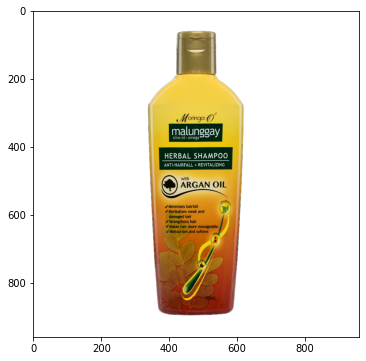

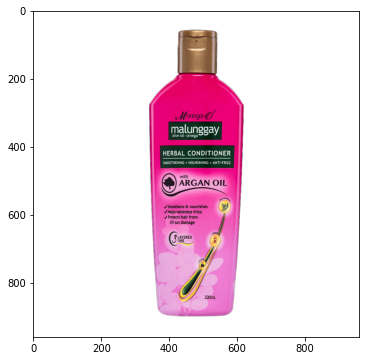

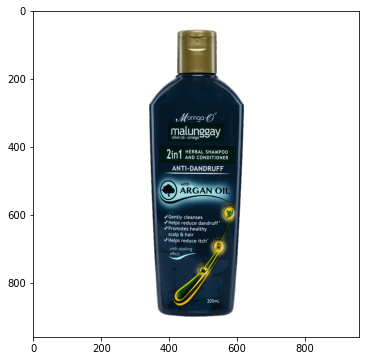

In [116]:
import matplotlib.image as mpimg

for i in range(1,4):
    img=mpimg.imread(test_link+'test_{}.jpg'.format(i))
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(img)

In [117]:
test_link = '/home/jishu/sql/'
os.chdir(os.path.join(test_link))
test_images = []
for i in range(1,4):
    test_images.append(load_image(test_link+'test_{}.jpg'.format(i)))

In [124]:
trial_meta = meta_input_usa[3001]

In [74]:
trial_meta = meta_input_usa[3001]
trial_meta = trial_meta.reshape(1,4,1,1)

In [75]:
trail_image = images[3001]
trail_image = trail_image.reshape(1,128,128,3) 

In [87]:
pred1 = model.predict({'main_input': trail_image, 'meta_input': trial_meta})[0][0]
pred1

6.1500564

Order: 
- product_length,
- product_height,
- product_width,
- shipping_weight

In [148]:
test_pl_1 = 13 
test_ph_1 = 11
test_pw_1 = 12
test_w_1 = 15
trial_meta_1 = np.array([test_pl_1,test_ph_1,test_pw_1,test_w_1])
trial_meta_1 = trial_meta_1.reshape(1,4,1,1)

trail_image_1 = test_images[0]
trail_image_1 = trail_image_1.reshape(1,128,128,3) 

pred_test_1 = model.predict({'main_input': trail_image_1, 'meta_input': trial_meta_1})[0][0]
pred_test_1

6.252386

In [131]:
result_df_1 = pd.DataFrame(data=[['United States of America',
                                'Health and Beauty',
                                'Hair Products',
                                'Shampoo',
                                pred_test_1,
                                'USA']],
                         columns=['Country',
                                  'Category 1',
                                  'Category 2',
                                  'Product',
                                  'Success Index',
                                  'iso_alpha'])
import plotly.express as px

fig = px.choropleth(result_df_1, locations="iso_alpha",
                    color="Success Index", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data=["Country",'Product'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [147]:
test_pl_2 = 20
test_ph_2 = 10
test_pw_2 = 5
test_w_2 = 20
trial_meta_2 = np.array([test_pl_2,test_ph_2,test_pw_2,test_w_2])
trial_meta_2 = trial_meta_2.reshape(1,4,1,1)

trail_image_2 = test_images[1]
trail_image_2 = trail_image_2.reshape(1,128,128,3) 

pred_test_2 = model.predict({'main_input': trail_image_2, 'meta_input': trial_meta_2})[0][0]
pred_test_2

6.235887

In [146]:
result_df_2 = pd.DataFrame(data=[['United States of America',
                                'Health and Beauty',
                                'Hair Products',
                                'Shampoo',
                                pred_test_2,
                                'USA']],
                         columns=['Country',
                                  'Category 1',
                                  'Category 2',
                                  'Product',
                                  'Success Index',
                                  'iso_alpha'])
import plotly.express as px

fig = px.choropleth(result_df_2, locations="iso_alpha",
                    color="Success Index", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data=["Country",'Product'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [149]:
test_pl_3 = 10
test_ph_3 = 20
test_pw_3 = 8
test_w_3 = 50
trial_meta_3 = np.array([test_pl_3,test_ph_3,test_pw_3,test_w_3])
trial_meta_3 = trial_meta_3.reshape(1,4,1,1)

trail_image_3 = test_images[2]
trail_image_3 = trail_image_3.reshape(1,128,128,3) 

pred_test_3 = model.predict({'main_input': trail_image_3, 'meta_input': trial_meta_3})[0][0]
pred_test_3

6.3343797

In [150]:
result_df_3 = pd.DataFrame(data=[['United States of America',
                                'Health and Beauty',
                                'Hair Products',
                                'Shampoo',
                                pred_test_3,
                                'USA']],
                         columns=['Country',
                                  'Category 1',
                                  'Category 2',
                                  'Product',
                                  'Success Index',
                                  'iso_alpha'])
import plotly.express as px

fig = px.choropleth(result_df_3, locations="iso_alpha",
                    color="Success Index", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data=["Country",'Product'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [157]:
result_df_temp = result_df_3 = pd.DataFrame(data=[['United States of America',
                                'Health and Beauty',
                                'Hair Products',
                                'Shampoo',
                                6.4,
                                'USA'],['Australia',
                                'Health and Beauty',
                                'Hair Products',
                                'Shampoo',
                                pred_test_2,
                                'AUS'],['India',
                                'Health and Beauty',
                                'Hair Products',
                                'Shampoo',
                                pred_test_3,
                                'IND'],['UK',
                                'Health and Beauty',
                                'Hair Products',
                                'Shampoo',
                                6.1,
                                'GBR']],
                         columns=['Country',
                                  'Category 1',
                                  'Category 2',
                                  'Product',
                                  'Success Index',
                                  'iso_alpha'])
import plotly.express as px

fig = px.choropleth(result_df_3, locations="iso_alpha",
                    color="Success Index", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data=["Country",'Product'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

### Data Wrangling - India

In [349]:
#data
df_india = df_temp[df_temp['country']=='India']
df_india_temp = df_india[df_india['rating_star']!='Not Scrapable']
india_shampoo = df_india_temp[df_india_temp['product']=='shampoo']

In [350]:
# india_shampoo.iloc[:,:15].head()

In [351]:
# india_shampoo.iloc[:,15:].head()

In [352]:
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].astype('str')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('Milliliters','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('Liters','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('Skinbeing','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('g','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('DABUR','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('Paris','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('Essences','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('Conditioner','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('Shoulders','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('India','Not Scrapable')
india_shampoo['pd_unit'] = india_shampoo['pd_unit'].str.replace('TRESemme','Not Scrapable')
india_shampoo.drop(index=india_shampoo[(india_shampoo['pd_unit']!='cm') & (india_shampoo['pd_unit']!='Not Scrapable')].index,
                   axis=0,inplace=True)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [353]:
india_shampoo.columns

Index(['link', 'country', 'cat1', 'cat2', 'cat3', 'cat4', 'product',
       'product_title', 'rating_star', 'overall_rating', 'company', 'price',
       'product_highlights', 'product_length', 'product_width',
       'product_height', 'product_weight', 'asin', 'pd_unit',
       'best_seller_cat', 'best_seller_prod', 'weight_unit', 'shipping_weight',
       'shipping_weight_unit', 'crr_5', 'crr_4', 'crr_3', 'crr_2', 'crr_1',
       'crr_fr_1', 'crr_fr_2', 'crr_fr_3', 'tags', 'images_link'],
      dtype='object')

In [354]:
india_shampoo['product_weight'] = india_shampoo['product_weight'].astype('str')
india_shampoo['product_weight'] = india_shampoo['product_weight'].str.replace('Not Scrapable','0')
india_shampoo['product_weight'] = india_shampoo['product_weight'].str.replace(',','')
india_shampoo['product_weight'] = india_shampoo['product_weight'].astype('float')
india_shampoo['product_length'] = india_shampoo['product_length'].astype('str')
india_shampoo['product_length'] = india_shampoo['product_length'].str.replace('Not Scrapable','0')
india_shampoo['product_length'] = india_shampoo['product_length'].str.replace(',','')
india_shampoo['product_length'] = india_shampoo['product_length'].astype('float')
india_shampoo['product_height'] = india_shampoo['product_height'].astype('str')
india_shampoo['product_height'] = india_shampoo['product_height'].str.replace('Not Scrapable','0')
india_shampoo['product_height'] = india_shampoo['product_height'].str.replace(',','')
india_shampoo['product_height'] = india_shampoo['product_height'].astype('float')
india_shampoo['product_width'] = india_shampoo['product_width'].astype('str')
india_shampoo['product_width'] = india_shampoo['product_width'].str.replace('Not Scrapable','0')
india_shampoo['product_width'] = india_shampoo['product_width'].str.replace(',','')
india_shampoo['product_width'] = india_shampoo['product_width'].astype('float')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [355]:
india_shampoo.reset_index(inplace=True,drop=True)
india_shampoo[['product_weight','weight_unit']]

product_weight    weight_unit
0               0.0  Not Scrapable
1               0.0  Not Scrapable
2               0.0  Not Scrapable
3               0.0  Not Scrapable
4             340.0              g
..              ...            ...
502           340.0              g
503           340.0              g
504           299.0              g
505             0.0  Not Scrapable
506             0.0  Not Scrapable

[507 rows x 2 columns]

In [356]:
#3998:2.2
for i in range(len(india_shampoo)):
    if india_shampoo.loc[i,'weight_unit'] == 'kg':
        india_shampoo.loc[i,'product_weight'] = india_shampoo.loc[i,'product_weight']*1000     
    else:
        pass
    
#Conversion from cm to inches
india_shampoo['product_length'] = india_shampoo['product_length']*0.393701
india_shampoo['product_width'] = india_shampoo['product_width']*0.393701
india_shampoo['product_height'] = india_shampoo['product_height']*0.393701

#Conversion form grams to ounces
india_shampoo['product_weight'] = india_shampoo['product_weight']*0.035274

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [357]:
india_shampoo_impute = india_shampoo[['product_weight','product_length','product_width','product_height']]

In [358]:
india_shampoo_impute

product_weight  product_length  product_width  product_height
0          0.000000        2.480316       1.496064        7.244098
1          0.000000        0.000000       0.000000        0.000000
2          0.000000        2.480316       1.496064        7.244098
3          0.000000        0.000000       0.000000        0.000000
4         11.993160        0.000000       0.000000        0.000000
..              ...             ...            ...             ...
502       11.993160        0.000000       0.000000        0.000000
503       11.993160        7.086618       1.377954        7.086618
504       10.546926        0.000000       0.000000        0.000000
505        0.000000        0.000000       0.000000        0.000000
506        0.000000        0.000000       0.000000        0.000000

[507 rows x 4 columns]

In [359]:
#Imputation
imputer = KNNImputer(missing_values=0,n_neighbors=10)
india_shampoo_impute = imputer.fit_transform(india_shampoo_impute)
india_shampoo_impute = pd.DataFrame(india_shampoo_impute,columns=['product_weight','product_length','product_width','product_height'])

In [360]:
india_shampoo['product_weight'] = india_shampoo_impute['product_weight']
india_shampoo['product_length'] = india_shampoo_impute['product_length']
india_shampoo['product_width'] = india_shampoo_impute['product_width']
india_shampoo['product_height'] = india_shampoo_impute['product_height']
india_shampoo['pd_unit'] = 'inches'
india_shampoo['weight_unit'] = 'ounces'

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [361]:
Counter(india_shampoo['weight_unit'])

Counter({'ounces': 507})

In [362]:
Counter(india_shampoo['pd_unit'])

Counter({'inches': 507})

In [363]:
india_shampoo_input = india_shampoo[['asin','product_title',
                                 'product_length',
                                 'product_height',
                                 'product_width',
                                 'product_weight']]
india_shampoo_input.reset_index(inplace=True)

In [364]:
india_shampoo_input.head()

index        asin                                      product_title  \
0      0  B07F31KJXH         TRESemme Keratin Smooth Conditioner, 190ml   
1      1  B00KCLZ5NO  Biotique Bio Pineapple Oil Control Foaming Fac...   
2      2  B07F31KJXH         TRESemme Keratin Smooth Conditioner, 190ml   
3      3  B00KCLZ5NO  Biotique Bio Pineapple Oil Control Foaming Fac...   
4      4  B0132H333I  Brillare Dandruff Control Shampoo For Rough, D...   

   product_length  product_height  product_width  product_weight  
0        2.480316        7.244098       1.496064       14.525833  
1        5.422450        6.192979       2.970255       11.706700  
2        2.480316        7.244098       1.496064       14.525833  
3        5.422450        6.192979       2.970255       11.706700  
4        7.086618        7.086618       1.377954       11.993160

In [365]:
india_shampoo_features = india_shampoo[['asin','product_title','rating_star',
                                    'overall_rating','best_seller_cat',
                                    'best_seller_prod','crr_5', 'crr_4', 
                                    'crr_3','crr_2','crr_1', 'crr_fr_1', 
                                    'crr_fr_2', 'crr_fr_3']]
india_shampoo_features.reset_index(inplace=True)

In [366]:
shampoo_images_link = '/home/jishu/database_new/Amazon_India/health_and_beauty/hair_products/shampoo/images/'
os.chdir(os.path.join(shampoo_images_link))

In [367]:
def load_image(infilename) :
    img = cv2.imread(infilename)
    target_size = (128,128)
    data = cv2.resize(img, target_size)
    return data

In [368]:
images_india = []
fails = []
for image in range(len(india_shampoo_features)):
    try:
        images_india.append(load_image(shampoo_images_link+india_shampoo_features['asin'][image]+'_0.jpg'))
    except:
        try:
            images_india.append(load_image(shampoo_images_link+india_shampoo_features['product_title'][image]+'_0.jpg'))
        except:
            fails.append(image)

In [369]:
for i in fails:
    india_shampoo_features.drop(index=i,axis=0,inplace=True)
    india_shampoo_input.drop(index=i,axis=0,inplace=True)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [370]:
feature_columns = ['rating_star', 'overall_rating',
       'best_seller_cat', 'best_seller_prod', 'crr_5', 'crr_4', 'crr_3',
       'crr_2', 'crr_1', 'crr_fr_1', 'crr_fr_2', 'crr_fr_3']

In [371]:
india_shampoo_features['rating_star'] = india_shampoo_features['rating_star'].astype('str')
india_shampoo_features['overall_rating'] = india_shampoo_features['overall_rating'].astype('str')
india_shampoo_features['best_seller_cat'] = india_shampoo_features['best_seller_cat'].astype('str')
india_shampoo_features['best_seller_prod'] = india_shampoo_features['best_seller_prod'].astype('str')
india_shampoo_features['crr_5'] = india_shampoo_features['crr_5'].astype('str')
india_shampoo_features['crr_4'] = india_shampoo_features['crr_4'].astype('str')
india_shampoo_features['crr_3'] = india_shampoo_features['crr_3'].astype('str')
india_shampoo_features['crr_2'] = india_shampoo_features['crr_2'].astype('str')
india_shampoo_features['crr_1'] = india_shampoo_features['crr_1'].astype('str')
india_shampoo_features['crr_fr_1'] = india_shampoo_features['crr_fr_1'].astype('str')
india_shampoo_features['crr_fr_2'] = india_shampoo_features['crr_fr_2'].astype('str')
india_shampoo_features['crr_fr_3'] = india_shampoo_features['crr_fr_3'].astype('str')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [372]:
for column in feature_columns:
    print(column)
    india_shampoo_features[column] = india_shampoo_features[column].str.replace('Not Scrapable','0')
    india_shampoo_features[column] = india_shampoo_features[column].str.replace(',','')

rating_star
overall_rating
best_seller_cat
best_seller_prod
crr_5
crr_4
crr_3
crr_2
crr_1
crr_fr_1
crr_fr_2
crr_fr_3


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [373]:
india_shampoo_features['rating_star'] = india_shampoo_features['rating_star'].astype('float')
india_shampoo_features['overall_rating'] = india_shampoo_features['overall_rating'].astype('float')
india_shampoo_features['best_seller_cat'] = india_shampoo_features['best_seller_cat'].astype('float')
india_shampoo_features['best_seller_prod'] = india_shampoo_features['best_seller_prod'].astype('float')
india_shampoo_features['crr_5'] = india_shampoo_features['crr_5'].astype('float')
india_shampoo_features['crr_4'] = india_shampoo_features['crr_4'].astype('float')
india_shampoo_features['crr_3'] = india_shampoo_features['crr_3'].astype('float')
india_shampoo_features['crr_2'] = india_shampoo_features['crr_2'].astype('float')
india_shampoo_features['crr_1'] = india_shampoo_features['crr_1'].astype('float')
india_shampoo_features['crr_fr_1'] = india_shampoo_features['crr_fr_1'].astype('float')
india_shampoo_features['crr_fr_2'] = india_shampoo_features['crr_fr_2'].astype('float')
india_shampoo_features['crr_fr_3'] = india_shampoo_features['crr_fr_3'].astype('float')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [374]:
india_shampoo_features.head()

index        asin                                      product_title  \
4      4  B0132H333I  Brillare Dandruff Control Shampoo For Rough, D...   
5      5  B00NFD40P0  Brillare Hair fall Control Shampoo For Weak & ...   
6      6  B07MNZ54D9  Oriental Botanics Red Onion Hair Shampoo, 300m...   
7      7  B0132H333I  Brillare Dandruff Control Shampoo For Rough, D...   
8      8  B00NFD40P0  Brillare Hair fall Control Shampoo For Weak & ...   

   rating_star  overall_rating  best_seller_cat  best_seller_prod  crr_5  \
4          3.8            57.0           3944.0             601.0   49.0   
5          4.1            64.0           5830.0             783.0   57.0   
6          4.0           689.0            424.0              82.0   55.0   
7          3.8            57.0           3944.0             601.0   49.0   
8          4.1            64.0           5830.0             783.0   57.0   

   crr_4  crr_3  crr_2  crr_1  crr_fr_1  crr_fr_2  crr_fr_3  
4   14.0   17.0    7.0   13.0       0.0       0.0       0.0  
5   20.0   10.0    7.0    6.0       0.0       0.0       0.0  
6   20.0    7.0    4.0   14.0       4.3       4.1       4.0  
7   14.0   17.0    7.0   13.0       0.0       0.0       0.0  
8   20.0   10.0    7.0    6.0       0.0       0.0       0.0

In [375]:
#Scaling Sales Rank
scaler = MinMaxScaler()
india_shampoo_features[['overall_rating',
                      'best_seller_cat',
                      'best_seller_prod']] = scaler.fit_transform(india_shampoo_features[['overall_rating','best_seller_cat','best_seller_prod']])
india_shampoo_features['best_seller_cat'] = 1 - india_shampoo_features['best_seller_cat']
india_shampoo_features['best_seller_prod'] = 1 - india_shampoo_features['best_seller_prod']

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [376]:
#Defining Target
weights = [1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
india_shampoo_features['target'] = 0
for i in range(len(india_shampoo_features)):
    try:
        india_shampoo_features.loc[i,'target'] = np.average(list(india_shampoo_features.loc[i,feature_columns]),weights = weights)
    except:
        pass

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [377]:
#Scaling within range 0-10
def scaling(x,a,b,minimum,maximum):
    return float(((b-a)*(x-minimum)/(maximum-minimum))+a)

In [378]:
min_tar_india = min(india_shampoo_features['target'])
max_tar_india = max(india_shampoo_features['target'])
india_shampoo_features['target'] = india_shampoo_features['target'].apply(lambda x: scaling(x,1,10,min_tar_india,max_tar_india))

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



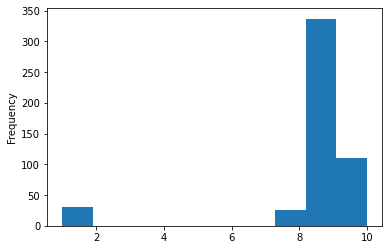

In [379]:
india_shampoo_features['target'].plot(kind='hist')

### Modelling - USA

In [380]:
india_shampoo_features['target'].shape

(502,)

In [381]:
np.array(images_india).shape

(502, 128, 128, 3)

In [382]:
meta_input_india = india_shampoo_input[['product_length','product_height','product_width','product_weight']].values

In [383]:
meta_input_india = meta_input_india.reshape(502,4,1,1)

In [384]:
#Main Model
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# first input model
visible1 = Input(shape=(128,128,3),name='main_input')
conv11 = Conv2D(96, kernel_size=(3,3),strides=(4,4),activation='relu',
                padding='valid')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
batch11 = BatchNormalization()(pool11)

conv12 = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu',
                padding='valid')(batch11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
batch12 = BatchNormalization()(pool12)

conv13 = Conv2D(32, kernel_size=(3,3),strides=(2,2),activation='relu',
                padding='valid')(batch12)
pool13 = MaxPooling2D(pool_size=(1, 1))(conv13)
batch13 = BatchNormalization()(pool13)

# conv14 = Conv2D(16, kernel_size=(5,5),strides=(2,2),activation='relu',
#                 padding='valid')(batch13)
# pool14 = MaxPooling2D(pool_size=(2, 2))(conv14)
# batch14 = BatchNormalization()(pool14)

# conv15 = Conv2D(8, kernel_size=(5,5),strides=(2,2),activation='relu',
#                 padding='valid')(batch14)
# pool15 = MaxPooling2D(pool_size=(2, 2))(conv15)
# batch15 = BatchNormalization()(pool15)
flat1 = Flatten()(batch13)

# second input model
visible2 = Input(shape=(4,1,1),name='meta_input')
hidden21 = Dense(10, activation='relu')(visible2)
hidden22 = Dense(20, activation='relu')(hidden21)
hidden23 = Dense(10, activation='relu')(hidden22)
flat2 = Flatten()(hidden23)

# merge input models
merge = concatenate([flat1, flat2])
# interpretation model
hidden1 = Dense(10, activation='relu')(merge)
hidden2 = Dense(10, activation='relu')(hidden1)
hidden3 = LeakyReLU(alpha=0.3)(hidden2)
output = Dense(1,name='output')(hidden3)

model_india_shampoo = Model(inputs=[visible1, visible2], outputs=output)
opt = SGD(lr=0.01, momentum=0.9,clipnorm=1.0)

# compiling
model_india_shampoo.compile(optimizer=opt, 
              loss='mean_absolute_error',
              metrics=['mean_squared_error',
                       'mean_absolute_error',
                       'mean_absolute_percentage_error',
                       'cosine_proximity'])

# And trained it via:
history_india_shampoo = model_india_shampoo.fit(x = {'main_input': np.array(images_india), 
                                                 'meta_input': meta_input_india},
                                                  y = {'output': india_shampoo_features['target'].values},
                                                  epochs=1000, 
                                                  batch_size=32,
                                                  verbose=1)

# summarize layers
print(model_india_shampoo.summary())
model_link = '/home/jishu/database_new/models/health_and_beauty/hair_products/shampoo/'
os.chdir(os.path.join(model_link))
model_india_shampoo.save("india_shampoo.h5")

Epoch 1/1000
502/502 [==============================] - 1s 1ms/step - loss: 8.3288 - mean_squared_error: 72.8155 - mean_absolute_error: 8.3288 - mean_absolute_percentage_error: 102.0781 - cosine_proximity: 0.0000e+00
Epoch 2/1000
502/502 [==============================] - 0s 433us/step - loss: 4.4743 - mean_squared_error: 26.7627 - mean_absolute_error: 4.4743 - mean_absolute_percentage_error: 64.7591 - cosine_proximity: 1.0000
Epoch 3/1000
502/502 [==============================] - 0s 434us/step - loss: 2.4792 - mean_squared_error: 11.5238 - mean_absolute_error: 2.4792 - mean_absolute_percentage_error: 47.7238 - cosine_proximity: 1.0000
Epoch 4/1000
502/502 [==============================] - 0s 437us/step - loss: 1.6012 - mean_squared_error: 8.0159 - mean_absolute_error: 1.6012 - mean_absolute_percentage_error: 37.9359 - cosine_proximity: 1.0000
Epoch 5/1000
502/502 [==============================] - 0s 437us/step - loss: 1.3821 - mean_squared_error: 7.6835 - mean_absolute_error: 1.382

502/502 [==============================] - 0s 430us/step - loss: 0.7318 - mean_squared_error: 1.1321 - mean_absolute_error: 0.7318 - mean_absolute_percentage_error: 14.7701 - cosine_proximity: 1.0000
Epoch 78/1000
502/502 [==============================] - 0s 431us/step - loss: 0.5832 - mean_squared_error: 0.8530 - mean_absolute_error: 0.5832 - mean_absolute_percentage_error: 12.4916 - cosine_proximity: 1.0000
Epoch 79/1000
502/502 [==============================] - 0s 434us/step - loss: 0.4944 - mean_squared_error: 0.7160 - mean_absolute_error: 0.4944 - mean_absolute_percentage_error: 11.7737 - cosine_proximity: 1.0000
Epoch 80/1000
502/502 [==============================] - 0s 431us/step - loss: 0.5195 - mean_squared_error: 0.8401 - mean_absolute_error: 0.5195 - mean_absolute_percentage_error: 12.0129 - cosine_proximity: 1.0000
Epoch 81/1000
502/502 [==============================] - 0s 432us/step - loss: 0.6164 - mean_squared_error: 0.8640 - mean_absolute_error: 0.6164 - mean_absolu

502/502 [==============================] - 0s 431us/step - loss: 0.2788 - mean_squared_error: 0.4577 - mean_absolute_error: 0.2788 - mean_absolute_percentage_error: 8.2279 - cosine_proximity: 1.0000
Epoch 154/1000
502/502 [==============================] - 0s 433us/step - loss: 0.2973 - mean_squared_error: 0.4582 - mean_absolute_error: 0.2973 - mean_absolute_percentage_error: 8.1806 - cosine_proximity: 1.0000
Epoch 155/1000
502/502 [==============================] - 0s 431us/step - loss: 0.2956 - mean_squared_error: 0.4604 - mean_absolute_error: 0.2956 - mean_absolute_percentage_error: 8.4776 - cosine_proximity: 1.0000
Epoch 156/1000
502/502 [==============================] - 0s 430us/step - loss: 0.2597 - mean_squared_error: 0.4253 - mean_absolute_error: 0.2597 - mean_absolute_percentage_error: 7.7264 - cosine_proximity: 1.0000
Epoch 157/1000
502/502 [==============================] - 0s 432us/step - loss: 0.3897 - mean_squared_error: 0.5506 - mean_absolute_error: 0.3897 - mean_absolu

502/502 [==============================] - 0s 439us/step - loss: 0.2129 - mean_squared_error: 0.4061 - mean_absolute_error: 0.2129 - mean_absolute_percentage_error: 7.2128 - cosine_proximity: 1.0000
Epoch 230/1000
502/502 [==============================] - 0s 442us/step - loss: 0.2566 - mean_squared_error: 0.4419 - mean_absolute_error: 0.2566 - mean_absolute_percentage_error: 7.9250 - cosine_proximity: 1.0000
Epoch 231/1000
502/502 [==============================] - 0s 431us/step - loss: 0.2327 - mean_squared_error: 0.4450 - mean_absolute_error: 0.2327 - mean_absolute_percentage_error: 7.7430 - cosine_proximity: 1.0000
Epoch 232/1000
502/502 [==============================] - 0s 429us/step - loss: 0.2198 - mean_squared_error: 0.4357 - mean_absolute_error: 0.2198 - mean_absolute_percentage_error: 7.7512 - cosine_proximity: 1.0000
Epoch 233/1000
502/502 [==============================] - 0s 429us/step - loss: 0.2017 - mean_squared_error: 0.4200 - mean_absolute_error: 0.2017 - mean_absolu

502/502 [==============================] - 0s 429us/step - loss: 0.2050 - mean_squared_error: 0.4232 - mean_absolute_error: 0.2050 - mean_absolute_percentage_error: 7.4616 - cosine_proximity: 0.9960
Epoch 306/1000
502/502 [==============================] - 0s 429us/step - loss: 0.2572 - mean_squared_error: 0.4226 - mean_absolute_error: 0.2572 - mean_absolute_percentage_error: 7.7384 - cosine_proximity: 1.0000
Epoch 307/1000
502/502 [==============================] - 0s 432us/step - loss: 0.1679 - mean_squared_error: 0.3910 - mean_absolute_error: 0.1679 - mean_absolute_percentage_error: 6.5606 - cosine_proximity: 1.0000
Epoch 308/1000
502/502 [==============================] - 0s 428us/step - loss: 0.1948 - mean_squared_error: 0.4022 - mean_absolute_error: 0.1948 - mean_absolute_percentage_error: 7.5815 - cosine_proximity: 1.0000
Epoch 309/1000
502/502 [==============================] - 0s 429us/step - loss: 0.2084 - mean_squared_error: 0.4180 - mean_absolute_error: 0.2084 - mean_absolu

502/502 [==============================] - 0s 432us/step - loss: 0.2315 - mean_squared_error: 0.4229 - mean_absolute_error: 0.2315 - mean_absolute_percentage_error: 7.2466 - cosine_proximity: 1.0000
Epoch 382/1000
502/502 [==============================] - 0s 431us/step - loss: 0.2029 - mean_squared_error: 0.3915 - mean_absolute_error: 0.2029 - mean_absolute_percentage_error: 7.0514 - cosine_proximity: 1.0000
Epoch 383/1000
502/502 [==============================] - 0s 431us/step - loss: 0.2569 - mean_squared_error: 0.4214 - mean_absolute_error: 0.2569 - mean_absolute_percentage_error: 7.7342 - cosine_proximity: 1.0000
Epoch 384/1000
502/502 [==============================] - 0s 428us/step - loss: 0.2036 - mean_squared_error: 0.4155 - mean_absolute_error: 0.2036 - mean_absolute_percentage_error: 7.2500 - cosine_proximity: 1.0000
Epoch 385/1000
502/502 [==============================] - 0s 430us/step - loss: 0.2205 - mean_squared_error: 0.4162 - mean_absolute_error: 0.2205 - mean_absolu

502/502 [==============================] - 0s 431us/step - loss: 0.1396 - mean_squared_error: 0.3880 - mean_absolute_error: 0.1396 - mean_absolute_percentage_error: 6.5212 - cosine_proximity: 1.0000
Epoch 458/1000
502/502 [==============================] - 0s 429us/step - loss: 0.1844 - mean_squared_error: 0.3943 - mean_absolute_error: 0.1844 - mean_absolute_percentage_error: 7.0898 - cosine_proximity: 1.0000
Epoch 459/1000
502/502 [==============================] - 0s 431us/step - loss: 0.2040 - mean_squared_error: 0.3891 - mean_absolute_error: 0.2040 - mean_absolute_percentage_error: 7.0885 - cosine_proximity: 1.0000
Epoch 460/1000
502/502 [==============================] - 0s 429us/step - loss: 0.2195 - mean_squared_error: 0.3974 - mean_absolute_error: 0.2195 - mean_absolute_percentage_error: 7.1476 - cosine_proximity: 1.0000
Epoch 461/1000
502/502 [==============================] - 0s 430us/step - loss: 0.1964 - mean_squared_error: 0.4012 - mean_absolute_error: 0.1964 - mean_absolu

502/502 [==============================] - 0s 432us/step - loss: 0.1792 - mean_squared_error: 0.3784 - mean_absolute_error: 0.1792 - mean_absolute_percentage_error: 6.6994 - cosine_proximity: 1.0000
Epoch 534/1000
502/502 [==============================] - 0s 435us/step - loss: 0.1475 - mean_squared_error: 0.3930 - mean_absolute_error: 0.1475 - mean_absolute_percentage_error: 6.8622 - cosine_proximity: 1.0000
Epoch 535/1000
502/502 [==============================] - 0s 431us/step - loss: 0.1819 - mean_squared_error: 0.3913 - mean_absolute_error: 0.1819 - mean_absolute_percentage_error: 6.6962 - cosine_proximity: 1.0000
Epoch 536/1000
502/502 [==============================] - 0s 431us/step - loss: 0.1523 - mean_squared_error: 0.3832 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 6.6206 - cosine_proximity: 1.0000
Epoch 537/1000
502/502 [==============================] - 0s 431us/step - loss: 0.1640 - mean_squared_error: 0.3841 - mean_absolute_error: 0.1640 - mean_absolu

502/502 [==============================] - 0s 426us/step - loss: 0.1549 - mean_squared_error: 0.3887 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 6.7334 - cosine_proximity: 1.0000
Epoch 610/1000
502/502 [==============================] - 0s 424us/step - loss: 0.1714 - mean_squared_error: 0.4025 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 6.8633 - cosine_proximity: 1.0000
Epoch 611/1000
502/502 [==============================] - 0s 425us/step - loss: 0.1373 - mean_squared_error: 0.3793 - mean_absolute_error: 0.1373 - mean_absolute_percentage_error: 6.2311 - cosine_proximity: 1.0000
Epoch 612/1000
502/502 [==============================] - 0s 423us/step - loss: 0.1475 - mean_squared_error: 0.3824 - mean_absolute_error: 0.1475 - mean_absolute_percentage_error: 6.6680 - cosine_proximity: 1.0000
Epoch 613/1000
502/502 [==============================] - 0s 420us/step - loss: 0.1589 - mean_squared_error: 0.3976 - mean_absolute_error: 0.1589 - mean_absolu

502/502 [==============================] - 0s 424us/step - loss: 0.1338 - mean_squared_error: 0.3761 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 6.1311 - cosine_proximity: 1.0000
Epoch 686/1000
502/502 [==============================] - 0s 425us/step - loss: 0.1755 - mean_squared_error: 0.3968 - mean_absolute_error: 0.1755 - mean_absolute_percentage_error: 6.8578 - cosine_proximity: 1.0000
Epoch 687/1000
502/502 [==============================] - 0s 423us/step - loss: 0.1382 - mean_squared_error: 0.3791 - mean_absolute_error: 0.1382 - mean_absolute_percentage_error: 6.1370 - cosine_proximity: 1.0000
Epoch 688/1000
502/502 [==============================] - 0s 424us/step - loss: 0.1342 - mean_squared_error: 0.3710 - mean_absolute_error: 0.1342 - mean_absolute_percentage_error: 6.1184 - cosine_proximity: 1.0000
Epoch 689/1000
502/502 [==============================] - 0s 425us/step - loss: 0.1459 - mean_squared_error: 0.3945 - mean_absolute_error: 0.1459 - mean_absolu

502/502 [==============================] - 0s 425us/step - loss: 0.1591 - mean_squared_error: 0.3898 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 6.5087 - cosine_proximity: 1.0000
Epoch 762/1000
502/502 [==============================] - 0s 422us/step - loss: 0.2323 - mean_squared_error: 0.4171 - mean_absolute_error: 0.2323 - mean_absolute_percentage_error: 7.6002 - cosine_proximity: 1.0000
Epoch 763/1000
502/502 [==============================] - 0s 423us/step - loss: 0.1736 - mean_squared_error: 0.3829 - mean_absolute_error: 0.1736 - mean_absolute_percentage_error: 6.7790 - cosine_proximity: 1.0000
Epoch 764/1000
502/502 [==============================] - 0s 424us/step - loss: 0.1726 - mean_squared_error: 0.4003 - mean_absolute_error: 0.1726 - mean_absolute_percentage_error: 7.0327 - cosine_proximity: 1.0000
Epoch 765/1000
502/502 [==============================] - 0s 423us/step - loss: 0.1457 - mean_squared_error: 0.3808 - mean_absolute_error: 0.1457 - mean_absolu

502/502 [==============================] - 0s 423us/step - loss: 0.1387 - mean_squared_error: 0.3779 - mean_absolute_error: 0.1387 - mean_absolute_percentage_error: 6.3934 - cosine_proximity: 1.0000
Epoch 838/1000
502/502 [==============================] - 0s 423us/step - loss: 0.1736 - mean_squared_error: 0.3990 - mean_absolute_error: 0.1736 - mean_absolute_percentage_error: 7.1739 - cosine_proximity: 1.0000
Epoch 839/1000
502/502 [==============================] - 0s 422us/step - loss: 0.1260 - mean_squared_error: 0.3759 - mean_absolute_error: 0.1260 - mean_absolute_percentage_error: 6.0061 - cosine_proximity: 1.0000
Epoch 840/1000
502/502 [==============================] - 0s 422us/step - loss: 0.1281 - mean_squared_error: 0.3826 - mean_absolute_error: 0.1281 - mean_absolute_percentage_error: 6.3874 - cosine_proximity: 1.0000
Epoch 841/1000
502/502 [==============================] - 0s 422us/step - loss: 0.1285 - mean_squared_error: 0.3885 - mean_absolute_error: 0.1285 - mean_absolu

502/502 [==============================] - 0s 425us/step - loss: 0.1222 - mean_squared_error: 0.3752 - mean_absolute_error: 0.1222 - mean_absolute_percentage_error: 6.0139 - cosine_proximity: 1.0000
Epoch 914/1000
502/502 [==============================] - 0s 423us/step - loss: 0.1219 - mean_squared_error: 0.3801 - mean_absolute_error: 0.1219 - mean_absolute_percentage_error: 6.1168 - cosine_proximity: 1.0000
Epoch 915/1000
502/502 [==============================] - 0s 424us/step - loss: 0.1410 - mean_squared_error: 0.3709 - mean_absolute_error: 0.1410 - mean_absolute_percentage_error: 6.4341 - cosine_proximity: 1.0000
Epoch 916/1000
502/502 [==============================] - 0s 426us/step - loss: 0.1244 - mean_squared_error: 0.3744 - mean_absolute_error: 0.1244 - mean_absolute_percentage_error: 5.9051 - cosine_proximity: 1.0000
Epoch 917/1000
502/502 [==============================] - 0s 422us/step - loss: 0.1212 - mean_squared_error: 0.3769 - mean_absolute_error: 0.1212 - mean_absolu

502/502 [==============================] - 0s 424us/step - loss: 0.1247 - mean_squared_error: 0.3790 - mean_absolute_error: 0.1247 - mean_absolute_percentage_error: 6.0787 - cosine_proximity: 1.0000
Epoch 990/1000
502/502 [==============================] - 0s 422us/step - loss: 0.1379 - mean_squared_error: 0.3915 - mean_absolute_error: 0.1379 - mean_absolute_percentage_error: 6.4849 - cosine_proximity: 1.0000
Epoch 991/1000
502/502 [==============================] - 0s 427us/step - loss: 0.1077 - mean_squared_error: 0.3714 - mean_absolute_error: 0.1077 - mean_absolute_percentage_error: 5.7955 - cosine_proximity: 1.0000
Epoch 992/1000
502/502 [==============================] - 0s 424us/step - loss: 0.1137 - mean_squared_error: 0.3739 - mean_absolute_error: 0.1137 - mean_absolute_percentage_error: 5.7621 - cosine_proximity: 1.0000
Epoch 993/1000
502/502 [==============================] - 0s 423us/step - loss: 0.1261 - mean_squared_error: 0.3729 - mean_absolute_error: 0.1261 - mean_absolu

In [385]:
model_link = '/home/jishu/database_new/models/health_and_beauty/hair_products/shampoo/'
os.chdir(os.path.join(model_link))
model_india_shampoo = load_model("india_shampoo.h5")

In [386]:
# plot metrics
plotting_metrics_india = {'mean_squared_error':history_india_shampoo.history['mean_squared_error'],
                    'mean_absolute_error':history_india_shampoo.history['mean_absolute_error'],
                    'mean_absolute_percentage_error':history_india_shampoo.history['mean_absolute_percentage_error'],
                    'cosine_proximity':history_india_shampoo.history['cosine_proximity']}

In [387]:
trial_meta = meta_input_usa[3001]
trial_meta = trial_meta.reshape(1,4,1,1)

In [388]:
trail_image = images[3001]
trail_image = trail_image.reshape(1,128,128,3) 

In [389]:
pred1 = model_india_shampoo.predict({'main_input': trail_image, 'meta_input': trial_meta})[0][0]
pred1

8.277836

In [390]:
usa_shampoo_features.iloc[3001,10:]['target']

8.138654280806438

In [391]:
y_pred = model_india_shampoo.predict({'main_input': np.array(images_india), 'meta_input': meta_input_india})
r2_score(india_shampoo_features['target'].values, y_pred)

0.8790579120577947

### Data Wrangling - Australia

In [441]:
#data
df_aus = df_temp[df_temp['country']=='Australia']
df_aus_temp = df_aus[df_aus['rating_star']!='Not Scrapable']
aus_shampoo = df_aus_temp[df_aus_temp['product']=='shampoo']

In [442]:
aus_shampoo.iloc[:,:15].head()

link    country  \
0  https://www.amazon.com.au/Shampoo-Caffeine-Blo...  Australia   
1  https://www.amazon.com.au/Biotin-Shampoo-Condi...  Australia   
2  https://www.amazon.com.au/Sukin-Natural-Balanc...  Australia   
3  https://www.amazon.com.au/Head-Shoulders-Anti-...  Australia   
4  https://www.amazon.com.au/Fanola-Yellow-Shampo...  Australia   

                cat1           cat2  cat3  cat4  product  \
0  health_and_beauty  hair_products  None  None  shampoo   
1  health_and_beauty  hair_products  None  None  shampoo   
2  health_and_beauty  hair_products  None  None  shampoo   
3  health_and_beauty  hair_products  None  None  shampoo   
4  health_and_beauty  hair_products  None  None  shampoo   

                                       product_title rating_star  \
0  Best Hair Growth Shampoo Sulphate & Paraben Fr...         3.7   
1  Biotin Shampoo and Conditioner Hair Loss Treat...         4.5   
2       Sukin Sukin Natural Balance Shampoo, 1 Litre         4.6   
3  Head & Shoulders For Men Old Spice 2in1 Anti-d...         4.7   
4  Fanola No Yellow Shampoo Ideal For Grey Superl...         4.4   

  overall_rating           company          price  \
0           1759         Watermans  Not Scrapable   
1           2955   Maple Holistics  Not Scrapable   
2             52             Sukin  Not Scrapable   
3              6  Head & Shoulders           12.0   
4           6425            FANOLA  Not Scrapable   

                                  product_highlights product_length  \
0  Made in the UK - ✔ 100% cosmetic ingredients o...            4.6   
1  ✅HAIR THICKENING SHAMPOO AND CONDITIONER for t...  Not Scrapable   
2  Burdock, Nettle, Horsetail, Baobab<CPT14>For N...            8.5   
3  Clinically proven up to 100% flake free (no vi...            0.1   
4  Ideal for grey, super-lightened or decoloured ...             19   

   product_width  
0              6  
1  Not Scrapable  
2            8.5  
3            0.1  
4            7.1

In [443]:
aus_shampoo.iloc[:,15:].head()

product_height product_weight        asin        pd_unit best_seller_cat  \
0             18           4.54  B00Q59B4UK             cm              89   
1  Not Scrapable  Not Scrapable  B07FSMRY3S  Not Scrapable              78   
2             25           4.54  B07C5HXVVY             cm             129   
3            0.1            499  B076P9HXB8             cm             279   
4            6.1           4.54  B00CGPMEAQ             cm             263   

  best_seller_prod    weight_unit shipping_weight shipping_weight_unit crr_5  \
0                2              g   Not Scrapable        Not Scrapable    49   
1                2  Not Scrapable   Not Scrapable        Not Scrapable    77   
2                4              g   Not Scrapable        Not Scrapable    85   
3                8              g   Not Scrapable        Not Scrapable    72   
4                6              g   Not Scrapable        Not Scrapable    73   

  crr_4 crr_3 crr_2 crr_1 crr_fr_1 crr_fr_2 crr_fr_3  tags  \
0    16    11     7    16        0        0        0  None   
1    10     5     2     6        0        0        0  None   
2     6     0     4     6        0        0        0  None   
3    28     0     0     0        0        0        0  None   
4    11     6     3     7        0        0        0  None   

                                         images_link  
0  Amazon_AU/health_and_beauty/hair_products/shampoo  
1  Amazon_AU/health_and_beauty/hair_products/shampoo  
2  Amazon_AU/health_and_beauty/hair_products/shampoo  
3  Amazon_AU/health_and_beauty/hair_products/shampoo  
4  Amazon_AU/health_and_beauty/hair_products/shampoo

In [444]:
Counter(aus_shampoo['pd_unit'])

Counter({'cm': 1352,
         'Not Scrapable': 252,
         'g': 4,
         'Japanese': 1,
         'No': 4,
         'Grams': 2,
         'Runners': 1,
         'KERASTASE': 1,
         'Shave': 1,
         '4976631649252': 1,
         '5992': 1,
         'Gloss-it': 1})

In [445]:
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].astype('str')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('Japanese','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('No','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('Grams','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('Runners','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('Shave','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('KERASTASE','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('4976631649252','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('5992','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('Gloss-it','Not Scrapable')
aus_shampoo['pd_unit'] = aus_shampoo['pd_unit'].str.replace('g','Not Scrapable')


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [446]:
aus_shampoo.columns

Index(['link', 'country', 'cat1', 'cat2', 'cat3', 'cat4', 'product',
       'product_title', 'rating_star', 'overall_rating', 'company', 'price',
       'product_highlights', 'product_length', 'product_width',
       'product_height', 'product_weight', 'asin', 'pd_unit',
       'best_seller_cat', 'best_seller_prod', 'weight_unit', 'shipping_weight',
       'shipping_weight_unit', 'crr_5', 'crr_4', 'crr_3', 'crr_2', 'crr_1',
       'crr_fr_1', 'crr_fr_2', 'crr_fr_3', 'tags', 'images_link'],
      dtype='object')

In [447]:
aus_shampoo['product_weight'] = aus_shampoo['product_weight'].astype('str')
aus_shampoo['product_weight'] = aus_shampoo['product_weight'].str.replace('Not Scrapable','0')
aus_shampoo['product_weight'] = aus_shampoo['product_weight'].str.replace(',','')
aus_shampoo['product_weight'] = aus_shampoo['product_weight'].astype('float')
aus_shampoo['product_length'] = aus_shampoo['product_length'].astype('str')
aus_shampoo['product_length'] = aus_shampoo['product_length'].str.replace('Not Scrapable','0')
aus_shampoo['product_length'] = aus_shampoo['product_length'].str.replace(',','')
aus_shampoo['product_length'] = aus_shampoo['product_length'].astype('float')
aus_shampoo['product_height'] = aus_shampoo['product_height'].astype('str')
aus_shampoo['product_height'] = aus_shampoo['product_height'].str.replace('Not Scrapable','0')
aus_shampoo['product_height'] = aus_shampoo['product_height'].str.replace(',','')
aus_shampoo['product_height'] = aus_shampoo['product_height'].astype('float')
aus_shampoo['product_width'] = aus_shampoo['product_width'].astype('str')
aus_shampoo['product_width'] = aus_shampoo['product_width'].str.replace('Not Scrapable','0')
aus_shampoo['product_width'] = aus_shampoo['product_width'].str.replace(',','')
aus_shampoo['product_width'] = aus_shampoo['product_width'].astype('float')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [448]:
aus_shampoo.reset_index(inplace=True,drop=True)
aus_shampoo[['product_weight','weight_unit']]

product_weight    weight_unit
0               4.54              g
1               0.00  Not Scrapable
2               4.54              g
3             499.00              g
4               4.54              g
...              ...            ...
1616          454.00              g
1617          340.00              g
1618          454.00              g
1619          113.00              g
1620            1.09             Kg

[1621 rows x 2 columns]

In [449]:
Counter(aus_shampoo['weight_unit'])

Counter({'g': 1228, 'Not Scrapable': 291, 'Kg': 102})

In [450]:
#3998:2.2
for i in range(len(aus_shampoo)):
    if aus_shampoo.loc[i,'weight_unit'] == 'kg':
        aus_shampoo.loc[i,'product_weight'] = aus_shampoo.loc[i,'product_weight']*1000     
    else:
        pass
    
#Conversion from cm to inches
aus_shampoo['product_length'] = aus_shampoo['product_length']*0.393701
aus_shampoo['product_width'] = aus_shampoo['product_width']*0.393701
aus_shampoo['product_height'] = aus_shampoo['product_height']*0.393701

#Conversion form grams to ounces
aus_shampoo['product_weight'] = aus_shampoo['product_weight']*0.035274

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [451]:
aus_shampoo_impute = aus_shampoo[['product_weight','product_length','product_width','product_height']]

In [452]:
aus_shampoo_impute

product_weight  product_length  product_width  product_height
0           0.160144        1.811025       2.362206        7.086618
1           0.000000        0.000000       0.000000        0.000000
2           0.160144        3.346459       3.346459        9.842525
3          17.601726        0.039370       0.039370        0.039370
4           0.160144        7.480319       2.795277        2.401576
...              ...             ...            ...             ...
1616       16.014396        9.842525       2.992128        2.992128
1617       11.993160        2.755907       2.755907        2.755907
1618       16.014396        5.000003       1.496064        1.496064
1619        3.985962        2.598427       0.984253        5.787405
1620        0.038449        2.913387       2.401576        2.913387

[1621 rows x 4 columns]

In [453]:
#Imputation
imputer = KNNImputer(missing_values=0,n_neighbors=10)
aus_shampoo_impute = imputer.fit_transform(aus_shampoo_impute)
aus_shampoo_impute = pd.DataFrame(aus_shampoo_impute,columns=['product_weight','product_length','product_width','product_height'])

In [454]:
aus_shampoo['product_weight'] = aus_shampoo_impute['product_weight']
aus_shampoo['product_length'] = aus_shampoo_impute['product_length']
aus_shampoo['product_width'] = aus_shampoo_impute['product_width']
aus_shampoo['product_height'] = aus_shampoo_impute['product_height']
aus_shampoo['pd_unit'] = 'inches'
aus_shampoo['weight_unit'] = 'ounces'

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [455]:
Counter(aus_shampoo['weight_unit'])

Counter({'ounces': 1621})

In [456]:
Counter(aus_shampoo['pd_unit'])

Counter({'inches': 1621})

In [457]:
aus_shampoo_input = aus_shampoo[['asin','product_title',
                                 'product_length',
                                 'product_height',
                                 'product_width',
                                 'product_weight']]
aus_shampoo_input.reset_index(inplace=True)

In [458]:
aus_shampoo_input.head().iloc[2]

index                                                        2
asin                                                B07C5HXVVY
product_title     Sukin Sukin Natural Balance Shampoo, 1 Litre
product_length                                         3.34646
product_height                                         9.84253
product_width                                          3.34646
product_weight                                        0.160144
Name: 2, dtype: object

In [459]:
aus_shampoo_features = aus_shampoo[['asin','product_title','rating_star',
                                    'overall_rating','best_seller_cat',
                                    'best_seller_prod','crr_5', 'crr_4', 
                                    'crr_3','crr_2','crr_1', 'crr_fr_1', 
                                    'crr_fr_2', 'crr_fr_3']]
aus_shampoo_features.reset_index(inplace=True)

In [460]:
shampoo_images_link = '/home/jishu/database_new/Amazon_AU/health_and_beauty/hair_products/shampoo/images/'
os.chdir(os.path.join(shampoo_images_link))

In [461]:
def load_image(infilename) :
    img = cv2.imread(infilename)
    target_size = (128,128)
    data = cv2.resize(img, target_size)
    return data

In [462]:
images_aus = []
fails = []
for image in range(len(aus_shampoo_features)):
    try:
        images_aus.append(load_image(shampoo_images_link+aus_shampoo_features['asin'][image]+'_0.jpg'))
    except:
        try:
            images_aus.append(load_image(shampoo_images_link+aus_shampoo_features['product_title'][image]+'_0.jpg'))
        except:
            fails.append(image)

In [463]:
for i in fails:
    aus_shampoo_features.drop(index=i,axis=0,inplace=True)
    aus_shampoo_input.drop(index=i,axis=0,inplace=True)

In [464]:
feature_columns = ['rating_star', 'overall_rating',
       'best_seller_cat', 'best_seller_prod', 'crr_5', 'crr_4', 'crr_3',
       'crr_2', 'crr_1', 'crr_fr_1', 'crr_fr_2', 'crr_fr_3']

In [465]:
aus_shampoo_features['rating_star'] = aus_shampoo_features['rating_star'].astype('str')
aus_shampoo_features['overall_rating'] = aus_shampoo_features['overall_rating'].astype('str')
aus_shampoo_features['best_seller_cat'] = aus_shampoo_features['best_seller_cat'].astype('str')
aus_shampoo_features['best_seller_prod'] = aus_shampoo_features['best_seller_prod'].astype('str')
aus_shampoo_features['crr_5'] = aus_shampoo_features['crr_5'].astype('str')
aus_shampoo_features['crr_4'] = aus_shampoo_features['crr_4'].astype('str')
aus_shampoo_features['crr_3'] = aus_shampoo_features['crr_3'].astype('str')
aus_shampoo_features['crr_2'] = aus_shampoo_features['crr_2'].astype('str')
aus_shampoo_features['crr_1'] = aus_shampoo_features['crr_1'].astype('str')
aus_shampoo_features['crr_fr_1'] = aus_shampoo_features['crr_fr_1'].astype('str')
aus_shampoo_features['crr_fr_2'] = aus_shampoo_features['crr_fr_2'].astype('str')
aus_shampoo_features['crr_fr_3'] = aus_shampoo_features['crr_fr_3'].astype('str')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [466]:
for column in feature_columns:
    print(column)
    aus_shampoo_features[column] = aus_shampoo_features[column].str.replace('Not Scrapable','0')
    aus_shampoo_features[column] = aus_shampoo_features[column].str.replace(',','')

rating_star
overall_rating
best_seller_cat
best_seller_prod
crr_5
crr_4
crr_3
crr_2
crr_1
crr_fr_1
crr_fr_2
crr_fr_3


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [467]:
aus_shampoo_features['rating_star'] = aus_shampoo_features['rating_star'].astype('float')
aus_shampoo_features['overall_rating'] = aus_shampoo_features['overall_rating'].astype('float')
aus_shampoo_features['best_seller_cat'] = aus_shampoo_features['best_seller_cat'].astype('float')
aus_shampoo_features['best_seller_prod'] = aus_shampoo_features['best_seller_prod'].astype('float')
aus_shampoo_features['crr_5'] = aus_shampoo_features['crr_5'].astype('float')
aus_shampoo_features['crr_4'] = aus_shampoo_features['crr_4'].astype('float')
aus_shampoo_features['crr_3'] = aus_shampoo_features['crr_3'].astype('float')
aus_shampoo_features['crr_2'] = aus_shampoo_features['crr_2'].astype('float')
aus_shampoo_features['crr_1'] = aus_shampoo_features['crr_1'].astype('float')
aus_shampoo_features['crr_fr_1'] = aus_shampoo_features['crr_fr_1'].astype('float')
aus_shampoo_features['crr_fr_2'] = aus_shampoo_features['crr_fr_2'].astype('float')
aus_shampoo_features['crr_fr_3'] = aus_shampoo_features['crr_fr_3'].astype('float')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [468]:
aus_shampoo_features

index        asin                                      product_title  \
0         0  B00Q59B4UK  Best Hair Growth Shampoo Sulphate & Paraben Fr...   
1         1  B07FSMRY3S  Biotin Shampoo and Conditioner Hair Loss Treat...   
2         2  B07C5HXVVY       Sukin Sukin Natural Balance Shampoo, 1 Litre   
3         3  B076P9HXB8  Head & Shoulders For Men Old Spice 2in1 Anti-d...   
4         4  B00CGPMEAQ  Fanola No Yellow Shampoo Ideal For Grey Superl...   
...     ...         ...                                                ...   
1616   1616  B001W9UI28                     label.m Treatment Shampoo, 1 L   
1617   1617  B001W9UHYW                label.m Honey & Oat Shampoo, 300 ml   
1618   1618  B001W9UHX8                label.m Deep Cleansing Shampoo, 1 L   
1619   1619  B000YK2O00          Bumble and Bumble Seaweed Shampoo, 236 ml   
1620   1620  B000KQ7X4K                     Pureology Hydrate Shampoo, 1 L   

      rating_star  overall_rating  best_seller_cat  best_seller_prod  crr_5  \
0             3.7          1759.0             89.0               2.0   49.0   
1             4.5          2955.0             78.0               2.0   77.0   
2             4.6            52.0            129.0               4.0   85.0   
3             4.7             6.0            279.0               8.0   72.0   
4             4.4          6425.0            263.0               6.0   73.0   
...           ...             ...              ...               ...    ...   
1616          4.5            15.0              0.0               0.0    0.0   
1617          4.4            71.0              0.0               0.0    0.0   
1618          4.4            31.0              0.0               0.0    0.0   
1619          4.7             9.0              0.0               0.0    0.0   
1620          4.6           745.0              0.0               0.0    0.0   

      crr_4  crr_3  crr_2  crr_1  crr_fr_1  crr_fr_2  crr_fr_3  
0      16.0   11.0    7.0   16.0       0.0       0.0       0.0  
1      10.0    5.0    2.0    6.0       0.0       0.0       0.0  
2       6.0    0.0    4.0    6.0       0.0       0.0       0.0  
3      28.0    0.0    0.0    0.0       0.0       0.0       0.0  
4      11.0    6.0    3.0    7.0       0.0       0.0       0.0  
...     ...    ...    ...    ...       ...       ...       ...  
1616    0.0    0.0    0.0    0.0       0.0       0.0       0.0  
1617    0.0    0.0    0.0    0.0       0.0       0.0       0.0  
1618    0.0    0.0    0.0    0.0       0.0       0.0       0.0  
1619    0.0    0.0    0.0    0.0       0.0       0.0       0.0  
1620    0.0    0.0    0.0    0.0       0.0       0.0       0.0  

[1621 rows x 15 columns]

In [469]:
#Scaling Sales Rank
scaler = MinMaxScaler()
aus_shampoo_features[['overall_rating',
                      'best_seller_cat',
                      'best_seller_prod']] = scaler.fit_transform(aus_shampoo_features[['overall_rating','best_seller_cat','best_seller_prod']])
aus_shampoo_features['best_seller_cat'] = 1 - aus_shampoo_features['best_seller_cat']
aus_shampoo_features['best_seller_prod'] = 1 - aus_shampoo_features['best_seller_prod']

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [470]:
#Defining Target
weights = [1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
aus_shampoo_features['target'] = 0
for i in range(len(aus_shampoo_features)):
    try:
        aus_shampoo_features.loc[i,'target'] = np.average(list(aus_shampoo_features.loc[i,feature_columns]),weights = weights)
    except:
        pass

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [471]:
#Scaling within range 0-10
def scaling(x,a,b,minimum,maximum):
    return float(((b-a)*(x-minimum)/(maximum-minimum))+a)

In [472]:
min_tar_aus = min(aus_shampoo_features['target'])
max_tar_aus = max(aus_shampoo_features['target'])
aus_shampoo_features['target'] = aus_shampoo_features['target'].apply(lambda x: scaling(x,1,10,min_tar_aus,max_tar_aus))

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



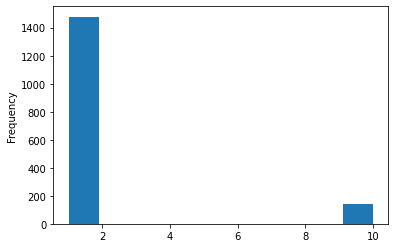

In [473]:
aus_shampoo_features['target'].plot(kind='hist')

### Modelling - Australia

In [475]:
aus_shampoo_features['target'].shape

(1621,)

In [476]:
np.array(images_aus).shape

(1621, 128, 128, 3)

In [477]:
meta_input_aus = aus_shampoo_input[['product_length','product_height','product_width','product_weight']].values

In [478]:
meta_input_aus = meta_input_aus.reshape(1621,4,1,1)

In [482]:
#Main Model
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# first input model
visible1 = Input(shape=(128,128,3),name='main_input')
conv11 = Conv2D(96, kernel_size=(3,3),strides=(4,4),activation='relu',
                padding='valid')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
batch11 = BatchNormalization()(pool11)

conv12 = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu',
                padding='valid')(batch11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
batch12 = BatchNormalization()(pool12)

conv13 = Conv2D(32, kernel_size=(3,3),strides=(2,2),activation='relu',
                padding='valid')(batch12)
pool13 = MaxPooling2D(pool_size=(1, 1))(conv13)
batch13 = BatchNormalization()(pool13)

# conv14 = Conv2D(16, kernel_size=(5,5),strides=(2,2),activation='relu',
#                 padding='valid')(batch13)
# pool14 = MaxPooling2D(pool_size=(2, 2))(conv14)
# batch14 = BatchNormalization()(pool14)

# conv15 = Conv2D(8, kernel_size=(5,5),strides=(2,2),activation='relu',
#                 padding='valid')(batch14)
# pool15 = MaxPooling2D(pool_size=(2, 2))(conv15)
# batch15 = BatchNormalization()(pool15)
flat1 = Flatten()(batch13)

# second input model
visible2 = Input(shape=(4,1,1),name='meta_input')
hidden21 = Dense(10, activation='relu')(visible2)
hidden22 = Dense(20, activation='relu')(hidden21)
hidden23 = Dense(10, activation='relu')(hidden22)
flat2 = Flatten()(hidden23)

# merge input models
merge = concatenate([flat1, flat2])
# interpretation model
hidden1 = Dense(10, activation='relu')(merge)
hidden2 = Dense(10, activation='relu')(hidden1)
hidden3 = LeakyReLU(alpha=0.3)(hidden2)
output = Dense(1,name='output')(hidden3)

model_aus_shampoo = Model(inputs=[visible1, visible2], outputs=output)
opt = SGD(lr=0.01, momentum=0.9,clipnorm=1.0)

# compiling
model_aus_shampoo.compile(optimizer=opt, 
              loss='mean_absolute_error',
              metrics=['mean_squared_error',
                       'mean_absolute_error',
                       'mean_absolute_percentage_error',
                       'cosine_proximity'])

# And trained it via:
history_aus_shampoo = model_aus_shampoo.fit(x = {'main_input': np.array(images_aus), 
                                                 'meta_input': meta_input_aus},
                                                  y = {'output': aus_shampoo_features['target'].values},
                                                  epochs=1000, 
                                                  batch_size=32,
                                                  verbose=1)

# summarize layers
print(model_aus_shampoo.summary())
model_link = '/home/jishu/database_new/models/health_and_beauty/hair_products/shampoo/'
os.chdir(os.path.join(model_link))
model_aus_shampoo.save("aus_shampoo.h5")

Epoch 1/1000
1621/1621 [==============================] - 1s 436us/step - loss: 0.0641 - mean_squared_error: 0.2349 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 2.2081 - cosine_proximity: 1.0000
Epoch 2/1000
1621/1621 [==============================] - 1s 445us/step - loss: 0.0748 - mean_squared_error: 0.2282 - mean_absolute_error: 0.0748 - mean_absolute_percentage_error: 2.8848 - cosine_proximity: 1.0000
Epoch 3/1000
1621/1621 [==============================] - 1s 447us/step - loss: 0.0704 - mean_squared_error: 0.2253 - mean_absolute_error: 0.0704 - mean_absolute_percentage_error: 2.5877 - cosine_proximity: 1.0000
Epoch 4/1000
1621/1621 [==============================] - 1s 448us/step - loss: 0.0676 - mean_squared_error: 0.2310 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 2.3963 - cosine_proximity: 1.0000
Epoch 5/1000
1621/1621 [==============================] - 1s 430us/step - loss: 0.0663 - mean_squared_error: 0.2265 - mean_absolute_error: 0.066

1621/1621 [==============================] - 1s 462us/step - loss: 0.0635 - mean_squared_error: 0.2275 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 2.1573 - cosine_proximity: 1.0000
Epoch 78/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0651 - mean_squared_error: 0.2316 - mean_absolute_error: 0.0651 - mean_absolute_percentage_error: 2.1990 - cosine_proximity: 1.0000
Epoch 79/1000
1621/1621 [==============================] - 1s 464us/step - loss: 0.0612 - mean_squared_error: 0.2276 - mean_absolute_error: 0.0612 - mean_absolute_percentage_error: 2.0923 - cosine_proximity: 1.0000
Epoch 80/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0643 - mean_squared_error: 0.2261 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 2.1959 - cosine_proximity: 1.0000
Epoch 81/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0571 - mean_squared_error: 0.2257 - mean_absolute_error: 0.0571 - mean_

Epoch 153/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0586 - mean_squared_error: 0.2248 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 1.9565 - cosine_proximity: 1.0000
Epoch 154/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0572 - mean_squared_error: 0.2241 - mean_absolute_error: 0.0572 - mean_absolute_percentage_error: 1.8983 - cosine_proximity: 1.0000
Epoch 155/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0622 - mean_squared_error: 0.2294 - mean_absolute_error: 0.0622 - mean_absolute_percentage_error: 1.9682 - cosine_proximity: 1.0000
Epoch 156/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0613 - mean_squared_error: 0.2283 - mean_absolute_error: 0.0613 - mean_absolute_percentage_error: 2.1163 - cosine_proximity: 1.0000
Epoch 157/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0665 - mean_squared_error: 0.2449 - mean_absolute_er

Epoch 228/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0568 - mean_squared_error: 0.2250 - mean_absolute_error: 0.0568 - mean_absolute_percentage_error: 1.8590 - cosine_proximity: 1.0000
Epoch 229/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0624 - mean_squared_error: 0.2337 - mean_absolute_error: 0.0624 - mean_absolute_percentage_error: 2.0888 - cosine_proximity: 1.0000
Epoch 230/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0615 - mean_squared_error: 0.2244 - mean_absolute_error: 0.0615 - mean_absolute_percentage_error: 1.9503 - cosine_proximity: 1.0000
Epoch 231/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0567 - mean_squared_error: 0.2242 - mean_absolute_error: 0.0567 - mean_absolute_percentage_error: 1.8518 - cosine_proximity: 1.0000
Epoch 232/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0611 - mean_squared_error: 0.2247 - mean_absolute_er

Epoch 303/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0591 - mean_squared_error: 0.2235 - mean_absolute_error: 0.0591 - mean_absolute_percentage_error: 1.9298 - cosine_proximity: 1.0000
Epoch 304/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0597 - mean_squared_error: 0.2269 - mean_absolute_error: 0.0597 - mean_absolute_percentage_error: 1.8678 - cosine_proximity: 1.0000
Epoch 305/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0597 - mean_squared_error: 0.2315 - mean_absolute_error: 0.0597 - mean_absolute_percentage_error: 1.9019 - cosine_proximity: 1.0000
Epoch 306/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0575 - mean_squared_error: 0.2239 - mean_absolute_error: 0.0575 - mean_absolute_percentage_error: 1.7654 - cosine_proximity: 1.0000
Epoch 307/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0596 - mean_squared_error: 0.2233 - mean_absolute_er

Epoch 378/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0578 - mean_squared_error: 0.2246 - mean_absolute_error: 0.0578 - mean_absolute_percentage_error: 1.8482 - cosine_proximity: 1.0000
Epoch 379/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0576 - mean_squared_error: 0.2244 - mean_absolute_error: 0.0576 - mean_absolute_percentage_error: 1.8650 - cosine_proximity: 1.0000
Epoch 380/1000
1621/1621 [==============================] - 1s 465us/step - loss: 0.0585 - mean_squared_error: 0.2239 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 1.9072 - cosine_proximity: 1.0000
Epoch 381/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0566 - mean_squared_error: 0.2228 - mean_absolute_error: 0.0566 - mean_absolute_percentage_error: 1.7612 - cosine_proximity: 1.0000
Epoch 382/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0603 - mean_squared_error: 0.2267 - mean_absolute_er

Epoch 453/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0571 - mean_squared_error: 0.2260 - mean_absolute_error: 0.0571 - mean_absolute_percentage_error: 1.8814 - cosine_proximity: 1.0000
Epoch 454/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0596 - mean_squared_error: 0.2233 - mean_absolute_error: 0.0596 - mean_absolute_percentage_error: 2.0141 - cosine_proximity: 1.0000
Epoch 455/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0548 - mean_squared_error: 0.2243 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 1.6300 - cosine_proximity: 1.0000
Epoch 456/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0532 - mean_squared_error: 0.2204 - mean_absolute_error: 0.0532 - mean_absolute_percentage_error: 1.6235 - cosine_proximity: 1.0000
Epoch 457/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0578 - mean_squared_error: 0.2255 - mean_absolute_er

Epoch 528/1000
1621/1621 [==============================] - 1s 460us/step - loss: 0.0509 - mean_squared_error: 0.2221 - mean_absolute_error: 0.0509 - mean_absolute_percentage_error: 1.5078 - cosine_proximity: 1.0000
Epoch 529/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0518 - mean_squared_error: 0.2215 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 1.5281 - cosine_proximity: 1.0000
Epoch 530/1000
1621/1621 [==============================] - 1s 460us/step - loss: 0.0567 - mean_squared_error: 0.2226 - mean_absolute_error: 0.0567 - mean_absolute_percentage_error: 1.7034 - cosine_proximity: 1.0000
Epoch 531/1000
1621/1621 [==============================] - 1s 465us/step - loss: 0.0541 - mean_squared_error: 0.2243 - mean_absolute_error: 0.0541 - mean_absolute_percentage_error: 1.5784 - cosine_proximity: 1.0000
Epoch 532/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0498 - mean_squared_error: 0.2211 - mean_absolute_er

Epoch 603/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0504 - mean_squared_error: 0.2205 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 1.4696 - cosine_proximity: 1.0000
Epoch 604/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0504 - mean_squared_error: 0.2215 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 1.5281 - cosine_proximity: 1.0000
Epoch 605/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0531 - mean_squared_error: 0.2217 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 1.6312 - cosine_proximity: 1.0000
Epoch 606/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0529 - mean_squared_error: 0.2219 - mean_absolute_error: 0.0529 - mean_absolute_percentage_error: 1.5454 - cosine_proximity: 1.0000
Epoch 607/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0572 - mean_squared_error: 0.2252 - mean_absolute_er

Epoch 678/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0524 - mean_squared_error: 0.2202 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 1.6168 - cosine_proximity: 1.0000
Epoch 679/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0591 - mean_squared_error: 0.2240 - mean_absolute_error: 0.0591 - mean_absolute_percentage_error: 1.9453 - cosine_proximity: 1.0000
Epoch 680/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0585 - mean_squared_error: 0.2213 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 1.8810 - cosine_proximity: 1.0000
Epoch 681/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0537 - mean_squared_error: 0.2224 - mean_absolute_error: 0.0537 - mean_absolute_percentage_error: 1.6645 - cosine_proximity: 1.0000
Epoch 682/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0570 - mean_squared_error: 0.2223 - mean_absolute_er

Epoch 753/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0520 - mean_squared_error: 0.2267 - mean_absolute_error: 0.0520 - mean_absolute_percentage_error: 1.4168 - cosine_proximity: 1.0000
Epoch 754/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0535 - mean_squared_error: 0.2241 - mean_absolute_error: 0.0535 - mean_absolute_percentage_error: 1.6864 - cosine_proximity: 1.0000
Epoch 755/1000
1621/1621 [==============================] - 1s 464us/step - loss: 0.0540 - mean_squared_error: 0.2214 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 1.6240 - cosine_proximity: 1.0000
Epoch 756/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0538 - mean_squared_error: 0.2209 - mean_absolute_error: 0.0538 - mean_absolute_percentage_error: 1.6827 - cosine_proximity: 1.0000
Epoch 757/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0495 - mean_squared_error: 0.2216 - mean_absolute_er

Epoch 828/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0552 - mean_squared_error: 0.2190 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 1.7139 - cosine_proximity: 1.0000
Epoch 829/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0524 - mean_squared_error: 0.2216 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 1.5347 - cosine_proximity: 1.0000
Epoch 830/1000
1621/1621 [==============================] - 1s 464us/step - loss: 0.0563 - mean_squared_error: 0.2234 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 1.7158 - cosine_proximity: 1.0000
Epoch 831/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0506 - mean_squared_error: 0.2182 - mean_absolute_error: 0.0506 - mean_absolute_percentage_error: 1.5422 - cosine_proximity: 1.0000
Epoch 832/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0495 - mean_squared_error: 0.2208 - mean_absolute_er

Epoch 903/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0593 - mean_squared_error: 0.2234 - mean_absolute_error: 0.0593 - mean_absolute_percentage_error: 1.8193 - cosine_proximity: 1.0000
Epoch 904/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0516 - mean_squared_error: 0.2181 - mean_absolute_error: 0.0516 - mean_absolute_percentage_error: 1.5793 - cosine_proximity: 1.0000
Epoch 905/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0526 - mean_squared_error: 0.2214 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 1.6312 - cosine_proximity: 1.0000
Epoch 906/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0586 - mean_squared_error: 0.2233 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 1.8754 - cosine_proximity: 1.0000
Epoch 907/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0557 - mean_squared_error: 0.2184 - mean_absolute_er

Epoch 978/1000
1621/1621 [==============================] - 1s 461us/step - loss: 0.0516 - mean_squared_error: 0.2207 - mean_absolute_error: 0.0516 - mean_absolute_percentage_error: 1.5722 - cosine_proximity: 1.0000
Epoch 979/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0517 - mean_squared_error: 0.2193 - mean_absolute_error: 0.0517 - mean_absolute_percentage_error: 1.5603 - cosine_proximity: 1.0000
Epoch 980/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0493 - mean_squared_error: 0.2192 - mean_absolute_error: 0.0493 - mean_absolute_percentage_error: 1.3932 - cosine_proximity: 1.0000
Epoch 981/1000
1621/1621 [==============================] - 1s 462us/step - loss: 0.0524 - mean_squared_error: 0.2208 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 1.5437 - cosine_proximity: 1.0000
Epoch 982/1000
1621/1621 [==============================] - 1s 463us/step - loss: 0.0529 - mean_squared_error: 0.2222 - mean_absolute_er

In [492]:
aus_shampoo

link    country  \
0     https://www.amazon.com.au/Shampoo-Caffeine-Blo...  Australia   
1     https://www.amazon.com.au/Biotin-Shampoo-Condi...  Australia   
2     https://www.amazon.com.au/Sukin-Natural-Balanc...  Australia   
3     https://www.amazon.com.au/Head-Shoulders-Anti-...  Australia   
4     https://www.amazon.com.au/Fanola-Yellow-Shampo...  Australia   
...                                                 ...        ...   
1616  https://www.amazon.com.au/Label-M-Treatment-Li...  Australia   
1617  https://www.amazon.com.au/Cleanse-Label-Honey-...  Australia   
1618  https://www.amazon.com.au/label-m-6696-Deep-Cl...  Australia   
1619  https://www.amazon.com.au/Degree-Men-Anti-pers...  Australia   
1620  https://www.amazon.com.au/Pureology-Hydrate-Sh...  Australia   

                   cat1           cat2  cat3  cat4  product  \
0     health_and_beauty  hair_products  None  None  shampoo   
1     health_and_beauty  hair_products  None  None  shampoo   
2     health_and_beauty  hair_products  None  None  shampoo   
3     health_and_beauty  hair_products  None  None  shampoo   
4     health_and_beauty  hair_products  None  None  shampoo   
...                 ...            ...   ...   ...      ...   
1616  health_and_beauty  hair_products  None  None  shampoo   
1617  health_and_beauty  hair_products  None  None  shampoo   
1618  health_and_beauty  hair_products  None  None  shampoo   
1619  health_and_beauty  hair_products  None  None  shampoo   
1620  health_and_beauty  hair_products  None  None  shampoo   

                                          product_title rating_star  \
0     Best Hair Growth Shampoo Sulphate & Paraben Fr...         3.7   
1     Biotin Shampoo and Conditioner Hair Loss Treat...         4.5   
2          Sukin Sukin Natural Balance Shampoo, 1 Litre         4.6   
3     Head & Shoulders For Men Old Spice 2in1 Anti-d...         4.7   
4     Fanola No Yellow Shampoo Ideal For Grey Superl...         4.4   
...                                                 ...         ...   
1616                     label.m Treatment Shampoo, 1 L         4.5   
1617                label.m Honey & Oat Shampoo, 300 ml         4.4   
1618                label.m Deep Cleansing Shampoo, 1 L         4.4   
1619          Bumble and Bumble Seaweed Shampoo, 236 ml         4.7   
1620                     Pureology Hydrate Shampoo, 1 L         4.6   

     overall_rating  ... crr_5 crr_4 crr_3  crr_2  crr_1  crr_fr_1  crr_fr_2  \
0              1759  ...    49    16    11      7     16         0         0   
1              2955  ...    77    10     5      2      6         0         0   
2                52  ...    85     6     0      4      6         0         0   
3                 6  ...    72    28     0      0      0         0         0   
4              6425  ...    73    11     6      3      7         0         0   
...             ...  ...   ...   ...   ...    ...    ...       ...       ...   
1616             15  ...     0     0     0      0      0         0         0   
1617             71  ...     0     0     0      0      0         0         0   
1618             31  ...     0     0     0      0      0         0         0   
1619              9  ...     0     0     0      0      0         0         0   
1620            745  ...     0     0     0      0      0         0         0   

     crr_fr_3  tags                                        images_link  
0           0  None  Amazon_AU/health_and_beauty/hair_products/shampoo  
1           0  None  Amazon_AU/health_and_beauty/hair_products/shampoo  
2           0  None  Amazon_AU/health_and_beauty/hair_products/shampoo  
3           0  None  Amazon_AU/health_and_beauty/hair_products/shampoo  
4           0  None  Amazon_AU/health_and_beauty/hair_products/shampoo  
...       ...   ...                                                ...  
1616        0  None  Amazon_AU/health_and_beauty/hair_products/shampoo  
1617        0  None  Amazon_AU/health_and_beauty/hair_p

In [483]:
model_link = '/home/jishu/database_new/models/health_and_beauty/hair_products/shampoo/'
os.chdir(os.path.join(model_link))
model_aus_shampoo = load_model("aus_shampoo.h5")

In [484]:
# plot metrics
plotting_metrics_aus = {'mean_squared_error':history_aus_shampoo.history['mean_squared_error'],
                    'mean_absolute_error':history_aus_shampoo.history['mean_absolute_error'],
                    'mean_absolute_percentage_error':history_aus_shampoo.history['mean_absolute_percentage_error'],
                    'cosine_proximity':history_aus_shampoo.history['cosine_proximity']}

In [489]:
trial_meta = meta_input_aus[1000]
trial_meta = trial_meta.reshape(1,4,1,1)

In [490]:
trail_image = images_aus[1000]
trail_image = trail_image.reshape(1,128,128,3) 

In [491]:
pred1 = model_aus_shampoo.predict({'main_input': trail_image, 'meta_input': trial_meta})[0][0]
pred1

-4.6550674

In [494]:
aus_shampoo_features.iloc[1000,10:]['target']

1.5583862659991372

In [488]:
y_pred = model_aus_shampoo.predict({'main_input': np.array(images_aus), 'meta_input': meta_input_aus})
r2_score(aus_shampoo_features['target'].values, y_pred)

-2.3780732639826358e+17

### Data Wrangling - United Kingdom

In [515]:
#data
df_uk = df_temp[df_temp['country']=='UK']
df_uk_temp = df_uk[df_uk['rating_star']!='Not Scrapable']
uk_shampoo = df_uk_temp[df_uk_temp['product']=='shampoo']

In [516]:
uk_shampoo.iloc[:,:15].head()

link country  \
0   https://www.amazon.co.uk/gp/slredirect/picasso...      UK   
1   https://www.amazon.co.uk/gp/slredirect/picasso...      UK   
2   https://www.amazon.co.uk/gp/slredirect/picasso...      UK   
52  https://www.amazon.co.uk/gp/slredirect/picasso...      UK   
53  https://www.amazon.co.uk/gp/slredirect/picasso...      UK   

                 cat1           cat2  cat3  cat4  product  \
0   health_and_beauty  hair_products  None  None  shampoo   
1   health_and_beauty  hair_products  None  None  shampoo   
2   health_and_beauty  hair_products  None  None  shampoo   
52  health_and_beauty  hair_products  None  None  shampoo   
53  health_and_beauty  hair_products  None  None  shampoo   

                                        product_title rating_star  \
0   Viviscal - Man Full Force Fortifying Shampoo 2018         4.4   
1            Noughty Wave Hello Curl Defining Shampoo         4.1   
2   Brickell Men's Daily Strengthening Shampoo for...         4.3   
52                 Pureology Fullfyl Shampoo, 1000 ml         3.5   
53                          KMS Colorvitality Shampoo         4.2   

   overall_rating                  company  price  \
0              59                 Viviscal   9.01   
1             171                  Noughty   4.66   
2            1037  Brickell Men's Products  18.72   
52             21            Not Scrapable   29.7   
53             50            Not Scrapable  16.64   

                                   product_highlights product_length  \
0   Cleanses and strengthens, leaving hair looking...              5   
1   For curly and wavy hair.<CPT14>Invigorating oc...              5   
2   What It Does: Our natural shampoo for men crea...            5.1   
52  The concentrated formula contains Keravis to b...            7.1   
53  Restore luminous, healthy-looking locks with K...            8.1   

   product_width  
0            7.8  
1            7.5  
2            8.9  
52           7.4  
53           7.1

In [520]:
uk_shampoo.iloc[:,13:].head(10)

product_length  product_width product_height product_weight        asin  \
0               5            7.8             20            295  B01M4IUJV0   
1               5            7.5           20.8            286  B078W6ZJQK   
2             5.1            8.9           12.7            259  B00SWDHC5I   
52            7.1            7.4            6.1          953.0  B01H2SFRO6   
53            8.1            7.1           25.9          726.0  B06XKNZJ5Z   
54  Not Scrapable  Not Scrapable  Not Scrapable            499  B07KV6J5NF   
55           17.8           21.6            7.9            295  B01NCTRJNZ   
56           17.8           21.6            7.9            340  B01MY6IDFR   
57              4              4             17            281  B00U1LETGO   
58            5.4           10.6             19            599  B07KSGBVPC   

          pd_unit best_seller_cat best_seller_prod weight_unit  \
0               g           14902              771           g   
1              cm            1511               76           g   
2               g            7662              379           g   
52             cm           47396             2178           g   
53             cm            9117              472           g   
54  Not Scrapable   Not Scrapable    Not Scrapable           g   
55              g            7927              330           g   
56              g            9469              379           g   
57              g           67594             2563           g   
58             cm           69293             2624           g   

   shipping_weight  ... crr_5 crr_4 crr_3 crr_2 crr_1 crr_fr_1 crr_fr_2  \
0    Not Scrapable  ...    67    18     9     4     2        0        0   
1    Not Scrapable  ...    57    18    13     6     7      4.3      4.2   
2    Not Scrapable  ...    67    12    10     4     6        0        0   
52   Not Scrapable  ...    50     7    12     8    24        0        0   
53   Not Scrapable  ...    60    14    14     5     7        0        0   
54   Not Scrapable  ...     0     0     0     0     0        0        0   
55   Not Scrapable  ...    79    10     5     2     3      4.8      4.4   
56   Not Scrapable  ...    81    13     2     2     2      4.8      4.6   
57   Not Scrapable  ...    48    18    16     8    10        0        0   
58   Not Scrapable  ...    17    29    32    22     0        0        0   

   crr_fr_3                                               tags  \
0         0                                               None   
1       4.2  value for money<CPT14>wave hello<CPT14>Scent<C...   
2         0  cleans the hair<CPT14>daily<CPT14>smell<CPT14>...   
52        0                                               None   
53        0                                               None   
54        0                                               None   
55      4.8  lathers well<CPT14>cruelty free<CPT14>sensitiv...   
56      4.3  cruelty free<CPT14>lovely shampoo<CPT14>highly...   
57        0                                               None   
58        0  pump action<CPT14>bottles and we only received...   

                                          images_link  
0   Amazon_UK/health_and_beauty/hair_products/shampoo  
1   Amazon_UK/health_and_beauty/hair_products/shampoo  
2   Amazon_UK/health_and_beauty/hair_products/shampoo  
52  Amazon_UK/health_and_beauty/hair_products/shampoo  
53  Amazon_UK/health_and_beauty/hair_products/shampoo  
54  Amazon_UK/health_and_beauty/hair_products/shampoo  
55  Amazon_UK/health_and_beauty/hair_products/shampoo  
56  Amazon_UK/health_and_beauty/hair_products/shampoo  
57  Amazon_UK/health_and_beauty/hair_products/shampoo  
58  Amazon_UK/health_and_beauty/hair_products/shampoo  

[10 rows x 21 columns]

In [518]:
Counter(uk_shampoo['pd_unit'])

Counter({'g': 509,
         'cm': 151,
         'Not Scrapable': 281,
         'Kg': 55,
         'Japan': 8,
         'ml': 34,
         'Grams': 67,
         'Garden': 1,
         'Gel': 1,
         'Fusion': 2,
         'Shimomura': 1,
         'DHC': 1,
         'Kilograms': 7,
         'ULOS': 1,
         'Sponsei': 1,
         'Sanotint': 1,
         'Essence': 3,
         'Oxy': 3,
         'Aphogee': 3,
         'eyes.': 4,
         'MoltoBene': 4,
         'Kuah': 3,
         'Pantene': 3,
         '926000': 3,
         '\xa0': 3,
         'Crew': 3,
         'WELLA': 2,
         'SOL.FINE': 4,
         'Bandai': 1,
         'Brush': 1,
         'Joy': 1,
         'animals.': 2,
         'Bonacure': 1,
         'Shampoos': 5,
         'Dogs': 2,
         'Breeze': 2,
         'SHA20004': 1,
         'fluid_ounces': 1,
         'Sonbayu': 1,
         'AGREE': 1,
         'Rishiri': 1,
         '': 1,
         'NS-K': 2,
         'HC89': 1,
         'Conditioner': 1,
         'I

In [539]:
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].astype('str')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Japan','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('ml','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Garden','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Gel','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Fusion','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Shimomura','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('ULOS','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Sponsei','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Sanotint','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Essence','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Oxy','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Aphogee','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('eyes','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('MoltoBene','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Kuah','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Pantene','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('926000','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('\xa0','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Crew','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('WELLA','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('SOL.FINE','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Bandai','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Brush','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Joy','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('animals.','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Bonacure','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Shampoos','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Dogs','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Breeze','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('SHA20004','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('fluid_ounces','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Sonbayu','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('AGREE','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Rishiri','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('NS-K','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('HC89','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Conditioner','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Inc.','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Valnet','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('AFTIR','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('BIOTHYMUS','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('FARMACEUTICI','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Bioscalin','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Ounce','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Shampoo','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('Club','Not Scrapable')
uk_shampoo['pd_unit'] = uk_shampoo['pd_unit'].str.replace('MA-FRA','Not Scrapable')

#Product Weight
uk_shampoo['weight_unit'] = uk_shampoo['weight_unit'].str.replace('Sept.','Not Scrapable')
uk_shampoo['weight_unit'] = uk_shampoo['weight_unit'].str.replace('July','Not Scrapable')
uk_shampoo['weight_unit'] = uk_shampoo['weight_unit'].str.replace('in','Not Scrapable')
uk_shampoo['weight_unit'] = uk_shampoo['weight_unit'].str.replace('Oct.','Not Scrapable')
uk_shampoo['weight_unit'] = uk_shampoo['weight_unit'].str.replace('Jun.','Not Scrapable')
uk_shampoo['weight_unit'] = uk_shampoo['weight_unit'].str.replace('Feb.','Not Scrapable')
uk_shampoo['weight_unit'] = uk_shampoo['weight_unit'].str.replace('SB','Not Scrapable')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [522]:
uk_shampoo.columns

Index(['link', 'country', 'cat1', 'cat2', 'cat3', 'cat4', 'product',
       'product_title', 'rating_star', 'overall_rating', 'company', 'price',
       'product_highlights', 'product_length', 'product_width',
       'product_height', 'product_weight', 'asin', 'pd_unit',
       'best_seller_cat', 'best_seller_prod', 'weight_unit', 'shipping_weight',
       'shipping_weight_unit', 'crr_5', 'crr_4', 'crr_3', 'crr_2', 'crr_1',
       'crr_fr_1', 'crr_fr_2', 'crr_fr_3', 'tags', 'images_link'],
      dtype='object')

In [535]:
uk_shampoo['product_height'].unique()

array([20.0, 20.8, 12.7, 6.1, 25.9, 'Not Scrapable', 7.9, 17.0, 19.0,
       20.3, 17.8, 8.0, 5.6, 25.4, 29.0, 13.2, 1.0, 25.0, 27.0, 13.3,
       24.1, 19.5, 18.7, 4.8, 6.0, 21.6, 22.2, 12.0, 2.5, 22.9, 45.7,
       10.2, 18.0, 34.9, 18.5, 13.0, 8.1, 3.6, 18.8, 14.0, 5.0, 16.5, 2.3,
       17.9, 19.7, 26.7, 15.5, 15.2, 14.5, 24.0, 21.1, 5.1, 50.8, 6.8,
       24.4, 21.0, 4.6, 6.6, 18.3, 14.4, 7.0, 12.5, 10.5, 17.1, 9.4, 17.3,
       3.0, 30.0, 15.9, 4.0, 26.0, 1.5, 11.4, 16.0, 10.8, 25.7, 11.8, 5.2,
       9.1, 4.2, 19.6, 6.5, 16.3, 7.7, 12.1, 20.1, 8.6, 66.0, 7.6, 4.5,
       15.0, 14.8, 7.4, 29.7, 13.8, 21.8, 23.0, 22.0, 23.4, 13.7, 19.8,
       23.5, 33.0, 4.9, 36.0, 16.2, 77.0, 58.0, 27.9, 17.5, 22.4, 9.2,
       17.6, 11.5, 10.0, 28.7, 16.8, 9.0, 3.8, 32.0, 21.2], dtype=object)

In [536]:
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].astype('str')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace('Not Scrapable','0')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace('Faith','0')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace('Ex','0')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace('\xa0','0')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace('6173871','617')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace('458756','45.8')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace('732020','73.2')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace('50636','5.2')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].str.replace(',','')
uk_shampoo['product_weight'] = uk_shampoo['product_weight'].astype('float')
uk_shampoo['product_length'] = uk_shampoo['product_length'].astype('str')
uk_shampoo['product_length'] = uk_shampoo['product_length'].str.replace('Not Scrapable','0')
uk_shampoo['product_length'] = uk_shampoo['product_length'].str.replace('926000.0','9.26')
uk_shampoo['product_length'] = uk_shampoo['product_length'].str.replace(',','')
uk_shampoo['product_length'] = uk_shampoo['product_length'].astype('float')
uk_shampoo['product_height'] = uk_shampoo['product_height'].astype('str')
uk_shampoo['product_height'] = uk_shampoo['product_height'].str.replace('Not Scrapable','0')
uk_shampoo['product_height'] = uk_shampoo['product_height'].str.replace(',','')
uk_shampoo['product_height'] = uk_shampoo['product_height'].astype('float')
uk_shampoo['product_width'] = uk_shampoo['product_width'].astype('str')
uk_shampoo['product_width'] = uk_shampoo['product_width'].str.replace('Not Scrapable','0')
uk_shampoo['product_width'] = uk_shampoo['product_width'].str.replace(',','')
uk_shampoo['product_width'] = uk_shampoo['product_width'].astype('float')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [540]:
uk_shampoo.reset_index(inplace=True,drop=True)
uk_shampoo[['product_weight','weight_unit']]

product_weight    weight_unit
0              295.0              g
1              286.0              g
2              259.0              g
3              953.0              g
4              726.0              g
...              ...            ...
1195             1.1             Kg
1196             1.1             Kg
1197            68.0              g
1198           118.0              g
1199             0.0  Not Scrapable

[1200 rows x 2 columns]

In [541]:
Counter(uk_shampoo['weight_unit'])

Counter({'g': 823, 'Kg': 136, 'Not Scrapable': 241})

In [542]:
#3998:2.2
for i in range(len(uk_shampoo)):
    if uk_shampoo.loc[i,'weight_unit'] == 'kg':
        uk_shampoo.loc[i,'product_weight'] = uk_shampoo.loc[i,'product_weight']*1000     
    else:
        pass
    
#Conversion from cm to inches
uk_shampoo['product_length'] = uk_shampoo['product_length']*0.393701
uk_shampoo['product_width'] = uk_shampoo['product_width']*0.393701
uk_shampoo['product_height'] = uk_shampoo['product_height']*0.393701

#Conversion form grams to ounces
uk_shampoo['product_weight'] = uk_shampoo['product_weight']*0.035274

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [543]:
uk_shampoo_impute = uk_shampoo[['product_weight','product_length','product_width','product_height']]

In [544]:
uk_shampoo_impute

product_weight  product_length  product_width  product_height
0          10.405830        1.968505       3.070868        7.874020
1          10.088364        1.968505       2.952758        8.188981
2           9.135966        2.007875       3.503939        5.000003
3          33.616122        2.795277       2.913387        2.401576
4          25.608924        3.188978       2.795277       10.196856
...              ...             ...            ...             ...
1195        0.038801        2.755907       2.755907       10.511817
1196        0.038801        2.992128       2.992128       10.511817
1197        2.398632        0.000000       0.000000        0.000000
1198        4.162332        1.496064       2.362206        6.259846
1199        0.000000        0.000000       0.000000        0.000000

[1200 rows x 4 columns]

In [545]:
#Imputation
imputer = KNNImputer(missing_values=0,n_neighbors=10)
uk_shampoo_impute = imputer.fit_transform(uk_shampoo_impute)
uk_shampoo_impute = pd.DataFrame(uk_shampoo_impute,columns=['product_weight','product_length','product_width','product_height'])

In [546]:
uk_shampoo['product_weight'] = uk_shampoo_impute['product_weight']
uk_shampoo['product_length'] = uk_shampoo_impute['product_length']
uk_shampoo['product_width'] = uk_shampoo_impute['product_width']
uk_shampoo['product_height'] = uk_shampoo_impute['product_height']
uk_shampoo['pd_unit'] = 'inches'
uk_shampoo['weight_unit'] = 'ounces'

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [547]:
Counter(uk_shampoo['weight_unit'])

Counter({'ounces': 1200})

In [548]:
Counter(uk_shampoo['pd_unit'])

Counter({'inches': 1200})

In [549]:
uk_shampoo_input = uk_shampoo[['asin','product_title',
                                 'product_length',
                                 'product_height',
                                 'product_width',
                                 'product_weight']]
uk_shampoo_input.reset_index(inplace=True)

In [550]:
uk_shampoo_features = uk_shampoo[['asin','product_title','rating_star',
                                    'overall_rating','best_seller_cat',
                                    'best_seller_prod','crr_5', 'crr_4', 
                                    'crr_3','crr_2','crr_1', 'crr_fr_1', 
                                    'crr_fr_2', 'crr_fr_3']]
uk_shampoo_features.reset_index(inplace=True)

In [551]:
shampoo_images_link = '/home/jishu/database_new/Amazon_UK/health_and_beauty/hair_products/shampoo/images/'
os.chdir(os.path.join(shampoo_images_link))

In [552]:
def load_image(infilename) :
    img = cv2.imread(infilename)
    target_size = (128,128)
    data = cv2.resize(img, target_size)
    return data

In [553]:
images_uk = []
fails = []
for image in range(len(uk_shampoo_features)):
    try:
        images_uk.append(load_image(shampoo_images_link+uk_shampoo_features['asin'][image]+'_0.jpg'))
    except:
        try:
            images_uk.append(load_image(shampoo_images_link+uk_shampoo_features['product_title'][image]+'_0.jpg'))
        except:
            fails.append(image)

In [554]:
for i in fails:
    uk_shampoo_features.drop(index=i,axis=0,inplace=True)
    uk_shampoo_input.drop(index=i,axis=0,inplace=True)

In [555]:
feature_columns = ['rating_star', 'overall_rating',
       'best_seller_cat', 'best_seller_prod', 'crr_5', 'crr_4', 'crr_3',
       'crr_2', 'crr_1', 'crr_fr_1', 'crr_fr_2', 'crr_fr_3']

In [556]:
uk_shampoo_features['rating_star'] = uk_shampoo_features['rating_star'].astype('str')
uk_shampoo_features['overall_rating'] = uk_shampoo_features['overall_rating'].astype('str')
uk_shampoo_features['best_seller_cat'] = uk_shampoo_features['best_seller_cat'].astype('str')
uk_shampoo_features['best_seller_prod'] = uk_shampoo_features['best_seller_prod'].astype('str')
uk_shampoo_features['crr_5'] = uk_shampoo_features['crr_5'].astype('str')
uk_shampoo_features['crr_4'] = uk_shampoo_features['crr_4'].astype('str')
uk_shampoo_features['crr_3'] = uk_shampoo_features['crr_3'].astype('str')
uk_shampoo_features['crr_2'] = uk_shampoo_features['crr_2'].astype('str')
uk_shampoo_features['crr_1'] = uk_shampoo_features['crr_1'].astype('str')
uk_shampoo_features['crr_fr_1'] = uk_shampoo_features['crr_fr_1'].astype('str')
uk_shampoo_features['crr_fr_2'] = uk_shampoo_features['crr_fr_2'].astype('str')
uk_shampoo_features['crr_fr_3'] = uk_shampoo_features['crr_fr_3'].astype('str')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [557]:
for column in feature_columns:
    print(column)
    uk_shampoo_features[column] = uk_shampoo_features[column].str.replace('Not Scrapable','0')
    uk_shampoo_features[column] = uk_shampoo_features[column].str.replace(',','')

rating_star
overall_rating
best_seller_cat
best_seller_prod
crr_5
crr_4
crr_3
crr_2
crr_1
crr_fr_1
crr_fr_2
crr_fr_3


/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [558]:
uk_shampoo_features['rating_star'] = uk_shampoo_features['rating_star'].astype('float')
uk_shampoo_features['overall_rating'] = uk_shampoo_features['overall_rating'].astype('float')
uk_shampoo_features['best_seller_cat'] = uk_shampoo_features['best_seller_cat'].astype('float')
uk_shampoo_features['best_seller_prod'] = uk_shampoo_features['best_seller_prod'].astype('float')
uk_shampoo_features['crr_5'] = uk_shampoo_features['crr_5'].astype('float')
uk_shampoo_features['crr_4'] = uk_shampoo_features['crr_4'].astype('float')
uk_shampoo_features['crr_3'] = uk_shampoo_features['crr_3'].astype('float')
uk_shampoo_features['crr_2'] = uk_shampoo_features['crr_2'].astype('float')
uk_shampoo_features['crr_1'] = uk_shampoo_features['crr_1'].astype('float')
uk_shampoo_features['crr_fr_1'] = uk_shampoo_features['crr_fr_1'].astype('float')
uk_shampoo_features['crr_fr_2'] = uk_shampoo_features['crr_fr_2'].astype('float')
uk_shampoo_features['crr_fr_3'] = uk_shampoo_features['crr_fr_3'].astype('float')

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [559]:
uk_shampoo_features

index        asin                                      product_title  \
0         0  B01M4IUJV0  Viviscal - Man Full Force Fortifying Shampoo 2018   
1         1  B078W6ZJQK           Noughty Wave Hello Curl Defining Shampoo   
2         2  B00SWDHC5I  Brickell Men's Daily Strengthening Shampoo for...   
3         3  B01H2SFRO6                 Pureology Fullfyl Shampoo, 1000 ml   
4         4  B06XKNZJ5Z                          KMS Colorvitality Shampoo   
...     ...         ...                                                ...   
1195   1195  B000N2MV20  Bouncy Cleanse Curl Defining Shampoo by ISO fo...   
1196   1196  B000N2JHTU  Tamer Cleanse Smoothing Shampoo by ISO for Uni...   
1197   1197  B07MQ23XJQ  Premium Beard Balm | Urban Cowboy | The Best B...   
1198   1198  B071JFMV8C  Just For Men Beard Face Wash, Daily Shampoo to...   
1199   1199  B01LXFID87  Premium Beard Balm | Mountain Woodsman | The B...   

      rating_star  overall_rating  best_seller_cat  best_seller_prod  crr_5  \
0             4.4            59.0          14902.0             771.0   67.0   
1             4.1           171.0           1511.0              76.0   57.0   
2             4.3          1037.0           7662.0             379.0   67.0   
3             3.5            21.0          47396.0            2178.0   50.0   
4             4.2            50.0           9117.0             472.0   60.0   
...           ...             ...              ...               ...    ...   
1195          4.2            76.0        1173289.0           25320.0    0.0   
1196          4.1            21.0        1440774.0           30513.0    0.0   
1197          4.7           143.0          15866.0             318.0   85.0   
1198          4.2            32.0          26210.0            2969.0   58.0   
1199          4.6           355.0              3.0               0.0   77.0   

      crr_4  crr_3  crr_2  crr_1  crr_fr_1  crr_fr_2  crr_fr_3  
0      18.0    9.0    4.0    2.0       0.0       0.0       0.0  
1      18.0   13.0    6.0    7.0       4.3       4.2       4.2  
2      12.0   10.0    4.0    6.0       0.0       0.0       0.0  
3       7.0   12.0    8.0   24.0       0.0       0.0       0.0  
4      14.0   14.0    5.0    7.0       0.0       0.0       0.0  
...     ...    ...    ...    ...       ...       ...       ...  
1195    0.0    0.0    0.0    0.0       0.0       0.0       0.0  
1196    0.0    0.0    0.0    0.0       0.0       0.0       0.0  
1197    8.0    2.0    3.0    2.0       4.7       4.7       4.6  
1198   23.0   10.0    0.0   10.0       0.0       0.0       0.0  
1199   12.0    5.0    2.0    4.0       4.7       4.6       4.5  

[1200 rows x 15 columns]

In [560]:
#Scaling Sales Rank
scaler = MinMaxScaler()
uk_shampoo_features[['overall_rating',
                      'best_seller_cat',
                      'best_seller_prod']] = scaler.fit_transform(uk_shampoo_features[['overall_rating','best_seller_cat','best_seller_prod']])
uk_shampoo_features['best_seller_cat'] = 1 - uk_shampoo_features['best_seller_cat']
uk_shampoo_features['best_seller_prod'] = 1 - uk_shampoo_features['best_seller_prod']

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [561]:
#Defining Target
weights = [1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
uk_shampoo_features['target'] = 0
for i in range(len(uk_shampoo_features)):
    try:
        uk_shampoo_features.loc[i,'target'] = np.average(list(uk_shampoo_features.loc[i,feature_columns]),weights = weights)
    except:
        pass

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [562]:
#Scaling within range 1-10
def scaling(x,a,b,minimum,maximum):
    return float(((b-a)*(x-minimum)/(maximum-minimum))+a)

In [563]:
min_tar_uk = min(uk_shampoo_features['target'])
max_tar_uk = max(uk_shampoo_features['target'])
uk_shampoo_features['target'] = uk_shampoo_features['target'].apply(lambda x: scaling(x,1,10,min_tar_uk,max_tar_uk))

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



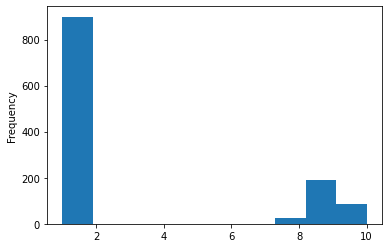

In [564]:
uk_shampoo_features['target'].plot(kind='hist')

### Modelling - UK


In [565]:
uk_shampoo_features['target'].shape

(1200,)

In [566]:
np.array(images_uk).shape

(1200, 128, 128, 3)

In [567]:
meta_input_uk = uk_shampoo_input[['product_length','product_height','product_width','product_weight']].values

In [568]:
meta_input_uk = meta_input_uk.reshape(1200,4,1,1)

In [569]:
#Main Model
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# first input model
visible1 = Input(shape=(128,128,3),name='main_input')
conv11 = Conv2D(96, kernel_size=(3,3),strides=(4,4),activation='relu',
                padding='valid')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
batch11 = BatchNormalization()(pool11)

conv12 = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu',
                padding='valid')(batch11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
batch12 = BatchNormalization()(pool12)

conv13 = Conv2D(32, kernel_size=(3,3),strides=(2,2),activation='relu',
                padding='valid')(batch12)
pool13 = MaxPooling2D(pool_size=(1, 1))(conv13)
batch13 = BatchNormalization()(pool13)

# conv14 = Conv2D(16, kernel_size=(5,5),strides=(2,2),activation='relu',
#                 padding='valid')(batch13)
# pool14 = MaxPooling2D(pool_size=(2, 2))(conv14)
# batch14 = BatchNormalization()(pool14)

# conv15 = Conv2D(8, kernel_size=(5,5),strides=(2,2),activation='relu',
#                 padding='valid')(batch14)
# pool15 = MaxPooling2D(pool_size=(2, 2))(conv15)
# batch15 = BatchNormalization()(pool15)
flat1 = Flatten()(batch13)

# second input model
visible2 = Input(shape=(4,1,1),name='meta_input')
hidden21 = Dense(10, activation='relu')(visible2)
hidden22 = Dense(20, activation='relu')(hidden21)
hidden23 = Dense(10, activation='relu')(hidden22)
flat2 = Flatten()(hidden23)

# merge input models
merge = concatenate([flat1, flat2])
# interpretation model
hidden1 = Dense(10, activation='relu')(merge)
hidden2 = Dense(10, activation='relu')(hidden1)
hidden3 = LeakyReLU(alpha=0.3)(hidden2)
output = Dense(1,name='output')(hidden3)

model_uk_shampoo = Model(inputs=[visible1, visible2], outputs=output)
opt = SGD(lr=0.01, momentum=0.9,clipnorm=1.0)

# compiling
model_uk_shampoo.compile(optimizer=opt, 
              loss='mean_absolute_error',
              metrics=['mean_squared_error',
                       'mean_absolute_error',
                       'mean_absolute_percentage_error',
                       'cosine_proximity'])

# And trained it via:
history_uk_shampoo = model_uk_shampoo.fit(x = {'main_input': np.array(images_uk), 
                                                 'meta_input': meta_input_uk},
                                                  y = {'output': uk_shampoo_features['target'].values},
                                                  epochs=1000, 
                                                  batch_size=32,
                                                  verbose=1)

# summarize layers
print(model_uk_shampoo.summary())
model_link = '/home/jishu/database_new/models/health_and_beauty/hair_products/shampoo/'
os.chdir(os.path.join(model_link))
model_uk_shampoo.save("uk_shampoo.h5")

Epoch 1/1000
1200/1200 [==============================] - 1s 941us/step - loss: 2.4860 - mean_squared_error: 15.3605 - mean_absolute_error: 2.4860 - mean_absolute_percentage_error: 60.4200 - cosine_proximity: 0.9050
Epoch 2/1000
1200/1200 [==============================] - 1s 476us/step - loss: 1.8033 - mean_squared_error: 9.8127 - mean_absolute_error: 1.8033 - mean_absolute_percentage_error: 36.6561 - cosine_proximity: 1.0000
Epoch 3/1000
1200/1200 [==============================] - 1s 480us/step - loss: 1.4564 - mean_squared_error: 6.7291 - mean_absolute_error: 1.4564 - mean_absolute_percentage_error: 34.8025 - cosine_proximity: 1.0000
Epoch 4/1000
1200/1200 [==============================] - 1s 469us/step - loss: 1.2916 - mean_squared_error: 5.6229 - mean_absolute_error: 1.2916 - mean_absolute_percentage_error: 32.2266 - cosine_proximity: 1.0000
Epoch 5/1000
1200/1200 [==============================] - 1s 477us/step - loss: 1.1575 - mean_squared_error: 4.7380 - mean_absolute_error: 

Epoch 39/1000
1200/1200 [==============================] - 1s 476us/step - loss: 0.3661 - mean_squared_error: 0.8608 - mean_absolute_error: 0.3661 - mean_absolute_percentage_error: 9.4451 - cosine_proximity: 1.0000
Epoch 40/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.3777 - mean_squared_error: 0.8925 - mean_absolute_error: 0.3777 - mean_absolute_percentage_error: 9.3639 - cosine_proximity: 1.0000
Epoch 41/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.3527 - mean_squared_error: 0.8083 - mean_absolute_error: 0.3527 - mean_absolute_percentage_error: 9.1016 - cosine_proximity: 1.0000
Epoch 42/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.3412 - mean_squared_error: 0.8065 - mean_absolute_error: 0.3412 - mean_absolute_percentage_error: 8.6032 - cosine_proximity: 1.0000
Epoch 43/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.3348 - mean_squared_error: 0.7756 - mean_absolute_error: 

1200/1200 [==============================] - 1s 469us/step - loss: 0.2384 - mean_squared_error: 0.5356 - mean_absolute_error: 0.2384 - mean_absolute_percentage_error: 6.0205 - cosine_proximity: 1.0000
Epoch 78/1000
1200/1200 [==============================] - 1s 472us/step - loss: 0.2192 - mean_squared_error: 0.4814 - mean_absolute_error: 0.2192 - mean_absolute_percentage_error: 5.9943 - cosine_proximity: 1.0000
Epoch 79/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.2091 - mean_squared_error: 0.4889 - mean_absolute_error: 0.2091 - mean_absolute_percentage_error: 5.4969 - cosine_proximity: 1.0000
Epoch 80/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.2339 - mean_squared_error: 0.4995 - mean_absolute_error: 0.2339 - mean_absolute_percentage_error: 5.8698 - cosine_proximity: 1.0000
Epoch 81/1000
1200/1200 [==============================] - 1s 472us/step - loss: 0.2046 - mean_squared_error: 0.4918 - mean_absolute_error: 0.2046 - mean_

1200/1200 [==============================] - 1s 472us/step - loss: 0.1716 - mean_squared_error: 0.3942 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 4.3009 - cosine_proximity: 1.0000
Epoch 116/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.1965 - mean_squared_error: 0.4221 - mean_absolute_error: 0.1965 - mean_absolute_percentage_error: 5.2273 - cosine_proximity: 1.0000
Epoch 117/1000
1200/1200 [==============================] - 1s 474us/step - loss: 0.1844 - mean_squared_error: 0.4092 - mean_absolute_error: 0.1844 - mean_absolute_percentage_error: 4.4098 - cosine_proximity: 1.0000
Epoch 118/1000
1200/1200 [==============================] - 1s 473us/step - loss: 0.1863 - mean_squared_error: 0.4076 - mean_absolute_error: 0.1863 - mean_absolute_percentage_error: 4.8741 - cosine_proximity: 1.0000
Epoch 119/1000
1200/1200 [==============================] - 1s 477us/step - loss: 0.1892 - mean_squared_error: 0.4043 - mean_absolute_error: 0.1892 - m

Epoch 153/1000
1200/1200 [==============================] - 1s 461us/step - loss: 0.1484 - mean_squared_error: 0.2915 - mean_absolute_error: 0.1484 - mean_absolute_percentage_error: 3.7669 - cosine_proximity: 1.0000
Epoch 154/1000
1200/1200 [==============================] - 1s 472us/step - loss: 0.1904 - mean_squared_error: 0.3151 - mean_absolute_error: 0.1904 - mean_absolute_percentage_error: 4.4595 - cosine_proximity: 1.0000
Epoch 155/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.1647 - mean_squared_error: 0.2665 - mean_absolute_error: 0.1647 - mean_absolute_percentage_error: 4.2260 - cosine_proximity: 1.0000
Epoch 156/1000
1200/1200 [==============================] - 1s 470us/step - loss: 0.1530 - mean_squared_error: 0.2558 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 4.2946 - cosine_proximity: 1.0000
Epoch 157/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.1392 - mean_squared_error: 0.2467 - mean_absolute_er

1200/1200 [==============================] - 1s 465us/step - loss: 0.1218 - mean_squared_error: 0.2313 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 3.2324 - cosine_proximity: 1.0000
Epoch 191/1000
1200/1200 [==============================] - 1s 470us/step - loss: 0.1213 - mean_squared_error: 0.2302 - mean_absolute_error: 0.1213 - mean_absolute_percentage_error: 3.4321 - cosine_proximity: 1.0000
Epoch 192/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.1280 - mean_squared_error: 0.2355 - mean_absolute_error: 0.1280 - mean_absolute_percentage_error: 3.4848 - cosine_proximity: 1.0000
Epoch 193/1000
1200/1200 [==============================] - 1s 464us/step - loss: 0.1283 - mean_squared_error: 0.2358 - mean_absolute_error: 0.1283 - mean_absolute_percentage_error: 3.2076 - cosine_proximity: 1.0000
Epoch 194/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.1295 - mean_squared_error: 0.2430 - mean_absolute_error: 0.1295 - m

Epoch 228/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.1362 - mean_squared_error: 0.2441 - mean_absolute_error: 0.1362 - mean_absolute_percentage_error: 3.3202 - cosine_proximity: 1.0000
Epoch 229/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.1209 - mean_squared_error: 0.2371 - mean_absolute_error: 0.1209 - mean_absolute_percentage_error: 3.3520 - cosine_proximity: 1.0000
Epoch 230/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.1256 - mean_squared_error: 0.2319 - mean_absolute_error: 0.1256 - mean_absolute_percentage_error: 3.1901 - cosine_proximity: 1.0000
Epoch 231/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.1150 - mean_squared_error: 0.2281 - mean_absolute_error: 0.1150 - mean_absolute_percentage_error: 3.0518 - cosine_proximity: 1.0000
Epoch 232/1000
1200/1200 [==============================] - 1s 461us/step - loss: 0.1349 - mean_squared_error: 0.2424 - mean_absolute_er

1200/1200 [==============================] - 1s 473us/step - loss: 0.1329 - mean_squared_error: 0.2306 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 3.2712 - cosine_proximity: 1.0000
Epoch 266/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.1531 - mean_squared_error: 0.2536 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 3.2183 - cosine_proximity: 1.0000
Epoch 267/1000
1200/1200 [==============================] - 1s 472us/step - loss: 0.1053 - mean_squared_error: 0.2115 - mean_absolute_error: 0.1053 - mean_absolute_percentage_error: 2.6348 - cosine_proximity: 1.0000
Epoch 268/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.1218 - mean_squared_error: 0.2225 - mean_absolute_error: 0.1218 - mean_absolute_percentage_error: 3.0716 - cosine_proximity: 1.0000
Epoch 269/1000
1200/1200 [==============================] - 1s 474us/step - loss: 0.1283 - mean_squared_error: 0.2242 - mean_absolute_error: 0.1283 - m

Epoch 303/1000
1200/1200 [==============================] - 1s 473us/step - loss: 0.1156 - mean_squared_error: 0.2052 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 2.8042 - cosine_proximity: 1.0000
Epoch 304/1000
1200/1200 [==============================] - 1s 473us/step - loss: 0.1229 - mean_squared_error: 0.2080 - mean_absolute_error: 0.1229 - mean_absolute_percentage_error: 2.7987 - cosine_proximity: 1.0000
Epoch 305/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.1338 - mean_squared_error: 0.2171 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 3.3736 - cosine_proximity: 1.0000
Epoch 306/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.1164 - mean_squared_error: 0.2164 - mean_absolute_error: 0.1164 - mean_absolute_percentage_error: 3.4953 - cosine_proximity: 1.0000
Epoch 307/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.1318 - mean_squared_error: 0.2165 - mean_absolute_er

1200/1200 [==============================] - 1s 460us/step - loss: 0.0938 - mean_squared_error: 0.0996 - mean_absolute_error: 0.0938 - mean_absolute_percentage_error: 2.6061 - cosine_proximity: 1.0000
Epoch 341/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.1072 - mean_squared_error: 0.1061 - mean_absolute_error: 0.1072 - mean_absolute_percentage_error: 2.8757 - cosine_proximity: 1.0000
Epoch 342/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.1001 - mean_squared_error: 0.0941 - mean_absolute_error: 0.1001 - mean_absolute_percentage_error: 2.5791 - cosine_proximity: 1.0000
Epoch 343/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0960 - mean_squared_error: 0.0905 - mean_absolute_error: 0.0960 - mean_absolute_percentage_error: 2.5890 - cosine_proximity: 1.0000
Epoch 344/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.0830 - mean_squared_error: 0.0921 - mean_absolute_error: 0.0830 - m

Epoch 378/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.1017 - mean_squared_error: 0.0757 - mean_absolute_error: 0.1017 - mean_absolute_percentage_error: 2.6579 - cosine_proximity: 1.0000
Epoch 379/1000
1200/1200 [==============================] - 1s 464us/step - loss: 0.0923 - mean_squared_error: 0.0669 - mean_absolute_error: 0.0923 - mean_absolute_percentage_error: 2.5785 - cosine_proximity: 1.0000
Epoch 380/1000
1200/1200 [==============================] - 1s 461us/step - loss: 0.1003 - mean_squared_error: 0.0746 - mean_absolute_error: 0.1003 - mean_absolute_percentage_error: 2.7706 - cosine_proximity: 1.0000
Epoch 381/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.0985 - mean_squared_error: 0.0774 - mean_absolute_error: 0.0985 - mean_absolute_percentage_error: 2.5771 - cosine_proximity: 1.0000
Epoch 382/1000
1200/1200 [==============================] - 1s 462us/step - loss: 0.0933 - mean_squared_error: 0.0686 - mean_absolute_er

1200/1200 [==============================] - 1s 468us/step - loss: 0.0995 - mean_squared_error: 0.0578 - mean_absolute_error: 0.0995 - mean_absolute_percentage_error: 2.5046 - cosine_proximity: 1.0000
Epoch 416/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.1037 - mean_squared_error: 0.0740 - mean_absolute_error: 0.1037 - mean_absolute_percentage_error: 2.9907 - cosine_proximity: 1.0000
Epoch 417/1000
1200/1200 [==============================] - 1s 463us/step - loss: 0.0814 - mean_squared_error: 0.0546 - mean_absolute_error: 0.0814 - mean_absolute_percentage_error: 2.2754 - cosine_proximity: 1.0000
Epoch 418/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.1109 - mean_squared_error: 0.0732 - mean_absolute_error: 0.1109 - mean_absolute_percentage_error: 2.8820 - cosine_proximity: 1.0000
Epoch 419/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0796 - mean_squared_error: 0.0322 - mean_absolute_error: 0.0796 - m

Epoch 453/1000
1200/1200 [==============================] - 1s 465us/step - loss: 0.0873 - mean_squared_error: 0.0314 - mean_absolute_error: 0.0873 - mean_absolute_percentage_error: 2.3245 - cosine_proximity: 1.0000
Epoch 454/1000
1200/1200 [==============================] - 1s 465us/step - loss: 0.0717 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 2.2919 - cosine_proximity: 1.0000
Epoch 455/1000
1200/1200 [==============================] - 1s 465us/step - loss: 0.0934 - mean_squared_error: 0.0326 - mean_absolute_error: 0.0934 - mean_absolute_percentage_error: 2.8962 - cosine_proximity: 1.0000
Epoch 456/1000
1200/1200 [==============================] - 1s 470us/step - loss: 0.0691 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0691 - mean_absolute_percentage_error: 2.1108 - cosine_proximity: 1.0000
Epoch 457/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0696 - mean_squared_error: 0.0157 - mean_absolute_er

1200/1200 [==============================] - 1s 475us/step - loss: 0.0911 - mean_squared_error: 0.0283 - mean_absolute_error: 0.0911 - mean_absolute_percentage_error: 2.3670 - cosine_proximity: 1.0000
Epoch 491/1000
1200/1200 [==============================] - 1s 476us/step - loss: 0.0566 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0566 - mean_absolute_percentage_error: 1.8238 - cosine_proximity: 1.0000
Epoch 492/1000
1200/1200 [==============================] - 1s 472us/step - loss: 0.0796 - mean_squared_error: 0.0185 - mean_absolute_error: 0.0796 - mean_absolute_percentage_error: 2.2632 - cosine_proximity: 1.0000
Epoch 493/1000
1200/1200 [==============================] - 1s 476us/step - loss: 0.0623 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0623 - mean_absolute_percentage_error: 2.0460 - cosine_proximity: 1.0000
Epoch 494/1000
1200/1200 [==============================] - 1s 473us/step - loss: 0.0623 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0623 - m

Epoch 528/1000
1200/1200 [==============================] - 1s 474us/step - loss: 0.0626 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0626 - mean_absolute_percentage_error: 1.7481 - cosine_proximity: 1.0000
Epoch 529/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.0635 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 1.9571 - cosine_proximity: 1.0000
Epoch 530/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.0658 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0658 - mean_absolute_percentage_error: 2.1008 - cosine_proximity: 1.0000
Epoch 531/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.0636 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 1.9197 - cosine_proximity: 1.0000
Epoch 532/1000
1200/1200 [==============================] - 1s 472us/step - loss: 0.0643 - mean_squared_error: 0.0163 - mean_absolute_er

1200/1200 [==============================] - 1s 466us/step - loss: 0.0760 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0760 - mean_absolute_percentage_error: 2.1884 - cosine_proximity: 1.0000
Epoch 566/1000
1200/1200 [==============================] - 1s 465us/step - loss: 0.1142 - mean_squared_error: 0.0661 - mean_absolute_error: 0.1142 - mean_absolute_percentage_error: 3.1344 - cosine_proximity: 1.0000
Epoch 567/1000
1200/1200 [==============================] - 1s 470us/step - loss: 0.0680 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0680 - mean_absolute_percentage_error: 2.1543 - cosine_proximity: 1.0000
Epoch 568/1000
1200/1200 [==============================] - 1s 470us/step - loss: 0.0775 - mean_squared_error: 0.0197 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 2.2112 - cosine_proximity: 1.0000
Epoch 569/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0810 - mean_squared_error: 0.0223 - mean_absolute_error: 0.0810 - m

Epoch 603/1000
1200/1200 [==============================] - 1s 472us/step - loss: 0.0607 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0607 - mean_absolute_percentage_error: 1.7734 - cosine_proximity: 1.0000
Epoch 604/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.1001 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1001 - mean_absolute_percentage_error: 2.3984 - cosine_proximity: 1.0000
Epoch 605/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0671 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0671 - mean_absolute_percentage_error: 1.9807 - cosine_proximity: 1.0000
Epoch 606/1000
1200/1200 [==============================] - 1s 461us/step - loss: 0.0792 - mean_squared_error: 0.0240 - mean_absolute_error: 0.0792 - mean_absolute_percentage_error: 1.9215 - cosine_proximity: 1.0000
Epoch 607/1000
1200/1200 [==============================] - 1s 451us/step - loss: 0.0542 - mean_squared_error: 0.0145 - mean_absolute_er

1200/1200 [==============================] - 1s 468us/step - loss: 0.0683 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0683 - mean_absolute_percentage_error: 2.0962 - cosine_proximity: 1.0000
Epoch 641/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.0505 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0505 - mean_absolute_percentage_error: 1.8287 - cosine_proximity: 1.0000
Epoch 642/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.0670 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0670 - mean_absolute_percentage_error: 1.8725 - cosine_proximity: 1.0000
Epoch 643/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.0613 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0613 - mean_absolute_percentage_error: 1.6786 - cosine_proximity: 1.0000
Epoch 644/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.0530 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0530 - m

Epoch 678/1000
1200/1200 [==============================] - 1s 476us/step - loss: 0.0501 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 1.8291 - cosine_proximity: 1.0000
Epoch 679/1000
1200/1200 [==============================] - 1s 474us/step - loss: 0.0776 - mean_squared_error: 0.0192 - mean_absolute_error: 0.0776 - mean_absolute_percentage_error: 2.1573 - cosine_proximity: 1.0000
Epoch 680/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.0586 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 2.1190 - cosine_proximity: 1.0000
Epoch 681/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.0544 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0544 - mean_absolute_percentage_error: 1.7421 - cosine_proximity: 1.0000
Epoch 682/1000
1200/1200 [==============================] - 1s 460us/step - loss: 0.0763 - mean_squared_error: 0.0187 - mean_absolute_er

1200/1200 [==============================] - 1s 459us/step - loss: 0.0414 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0414 - mean_absolute_percentage_error: 1.3131 - cosine_proximity: 1.0000
Epoch 716/1000
1200/1200 [==============================] - 1s 463us/step - loss: 0.0646 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 1.7801 - cosine_proximity: 1.0000
Epoch 717/1000
1200/1200 [==============================] - 1s 470us/step - loss: 0.0709 - mean_squared_error: 0.0236 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 2.2253 - cosine_proximity: 1.0000
Epoch 718/1000
1200/1200 [==============================] - 1s 463us/step - loss: 0.0675 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 2.1202 - cosine_proximity: 1.0000
Epoch 719/1000
1200/1200 [==============================] - 1s 464us/step - loss: 0.0631 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0631 - m

Epoch 753/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.0531 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 1.7454 - cosine_proximity: 1.0000
Epoch 754/1000
1200/1200 [==============================] - 1s 465us/step - loss: 0.0649 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0649 - mean_absolute_percentage_error: 1.7529 - cosine_proximity: 1.0000
Epoch 755/1000
1200/1200 [==============================] - 1s 469us/step - loss: 0.0525 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 1.5760 - cosine_proximity: 1.0000
Epoch 756/1000
1200/1200 [==============================] - 1s 475us/step - loss: 0.0625 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0625 - mean_absolute_percentage_error: 1.7678 - cosine_proximity: 1.0000
Epoch 757/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.0541 - mean_squared_error: 0.0152 - mean_absolute_er

1200/1200 [==============================] - 1s 465us/step - loss: 0.0621 - mean_squared_error: 0.0204 - mean_absolute_error: 0.0621 - mean_absolute_percentage_error: 1.9758 - cosine_proximity: 1.0000
Epoch 791/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0505 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0505 - mean_absolute_percentage_error: 1.6399 - cosine_proximity: 1.0000
Epoch 792/1000
1200/1200 [==============================] - 1s 461us/step - loss: 0.0637 - mean_squared_error: 0.0217 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 1.6616 - cosine_proximity: 1.0000
Epoch 793/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0578 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0578 - mean_absolute_percentage_error: 1.5875 - cosine_proximity: 1.0000
Epoch 794/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.0645 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0645 - m

Epoch 828/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0556 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0556 - mean_absolute_percentage_error: 1.4490 - cosine_proximity: 1.0000
Epoch 829/1000
1200/1200 [==============================] - 1s 462us/step - loss: 0.0639 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 1.7531 - cosine_proximity: 1.0000
Epoch 830/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.0656 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0656 - mean_absolute_percentage_error: 1.9108 - cosine_proximity: 1.0000
Epoch 831/1000
1200/1200 [==============================] - 1s 461us/step - loss: 0.0652 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 1.6922 - cosine_proximity: 1.0000
Epoch 832/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.0447 - mean_squared_error: 0.0068 - mean_absolute_er

1200/1200 [==============================] - 1s 463us/step - loss: 0.0600 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0600 - mean_absolute_percentage_error: 1.6713 - cosine_proximity: 1.0000
Epoch 866/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.0474 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0474 - mean_absolute_percentage_error: 1.6328 - cosine_proximity: 1.0000
Epoch 867/1000
1200/1200 [==============================] - 1s 463us/step - loss: 0.0579 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0579 - mean_absolute_percentage_error: 1.8325 - cosine_proximity: 1.0000
Epoch 868/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.0523 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0523 - mean_absolute_percentage_error: 1.7446 - cosine_proximity: 1.0000
Epoch 869/1000
1200/1200 [==============================] - 1s 463us/step - loss: 0.0505 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0505 - m

Epoch 903/1000
1200/1200 [==============================] - 1s 463us/step - loss: 0.0430 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0430 - mean_absolute_percentage_error: 1.4467 - cosine_proximity: 1.0000
Epoch 904/1000
1200/1200 [==============================] - 1s 464us/step - loss: 0.0503 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0503 - mean_absolute_percentage_error: 1.5675 - cosine_proximity: 1.0000
Epoch 905/1000
1200/1200 [==============================] - 1s 466us/step - loss: 0.0527 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0527 - mean_absolute_percentage_error: 1.3881 - cosine_proximity: 1.0000
Epoch 906/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.0655 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0655 - mean_absolute_percentage_error: 1.7745 - cosine_proximity: 1.0000
Epoch 907/1000
1200/1200 [==============================] - 1s 471us/step - loss: 0.0505 - mean_squared_error: 0.0104 - mean_absolute_er

1200/1200 [==============================] - 1s 468us/step - loss: 0.0490 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0490 - mean_absolute_percentage_error: 1.4729 - cosine_proximity: 1.0000
Epoch 941/1000
1200/1200 [==============================] - 1s 463us/step - loss: 0.0594 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0594 - mean_absolute_percentage_error: 1.9845 - cosine_proximity: 1.0000
Epoch 942/1000
1200/1200 [==============================] - 1s 468us/step - loss: 0.0558 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0558 - mean_absolute_percentage_error: 1.9308 - cosine_proximity: 1.0000
Epoch 943/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.0533 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 1.4817 - cosine_proximity: 1.0000
Epoch 944/1000
1200/1200 [==============================] - 1s 467us/step - loss: 0.0463 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0463 - m

Epoch 978/1000
1200/1200 [==============================] - 1s 455us/step - loss: 0.0442 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0442 - mean_absolute_percentage_error: 1.4170 - cosine_proximity: 1.0000
Epoch 979/1000
1200/1200 [==============================] - 1s 473us/step - loss: 0.0466 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0466 - mean_absolute_percentage_error: 1.2382 - cosine_proximity: 1.0000
Epoch 980/1000
1200/1200 [==============================] - 1s 464us/step - loss: 0.0480 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 1.6593 - cosine_proximity: 1.0000
Epoch 981/1000
1200/1200 [==============================] - 1s 463us/step - loss: 0.0391 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 1.3945 - cosine_proximity: 1.0000
Epoch 982/1000
1200/1200 [==============================] - 1s 470us/step - loss: 0.0438 - mean_squared_error: 0.0063 - mean_absolute_er

In [570]:
model_link = '/home/jishu/database_new/models/health_and_beauty/hair_products/shampoo/'
os.chdir(os.path.join(model_link))
model_uk_shampoo = load_model("uk_shampoo.h5")

In [571]:
# plot metrics
plotting_metrics_uk = {'mean_squared_error':history_uk_shampoo.history['mean_squared_error'],
                    'mean_absolute_error':history_uk_shampoo.history['mean_absolute_error'],
                    'mean_absolute_percentage_error':history_uk_shampoo.history['mean_absolute_percentage_error'],
                    'cosine_proximity':history_uk_shampoo.history['cosine_proximity']}

In [572]:
trial_meta = meta_input_uk[30]
trial_meta = trial_meta.reshape(1,4,1,1)

In [573]:
trail_image = images_uk[30]
trail_image = trail_image.reshape(1,128,128,3) 

In [574]:
pred1 = model_uk_shampoo.predict({'main_input': trail_image, 'meta_input': trial_meta})[0][0]
pred1

8.58424

In [575]:
usa_shampoo_features.iloc[30,10:]['target']

9.768276284229042

In [576]:
y_pred = model_uk_shampoo.predict({'main_input': np.array(images_uk), 'meta_input': meta_input_uk})
r2_score(uk_shampoo_features['target'].values, y_pred)

0.9988151332359789

### Storing everything in a pickle file

In [626]:
#Storing in Pickle
tags_datasets = tags_dataframes
models = {'USA':model_usa_shampoo,
          'India':model_india_shampoo,
          'Australia':model_aus_shampoo,
          'UK':model_uk_shampoo}
scores = {'USA':plotting_metrics_usa,
          'India':plotting_metrics_india,
          'Australia':plotting_metrics_aus,
          'UK':plotting_metrics_uk}
main_datasets = {'USA':usa_shampoo,
          'India':india_shampoo,
          'Australia':aus_shampoo,
          'UK':uk_shampoo}
main_file = {'tags_datasets':tags_datasets,
             'models':models,
             'scores':scores,
             'main_datasets':main_datasets}
with open('shampoo.pkl', 'wb') as handle:
    pickle.dump(main_file, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('shampoo.pkl', 'rb') as handle:
    loaded_pkl = pickle.load(handle)
# loaded_pkl['models']['USA'].predict({'main_input': trail_image, 'meta_input': trial_meta})[0][0]    

### Evaluation

In [616]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_usa['mean_squared_error']))), 
                         y=plotting_metrics_usa['mean_squared_error'], 
                         name='Mean Squared Error',
                         line=dict(color='firebrick', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_usa['mean_absolute_error']))), 
                         y=plotting_metrics_usa['mean_absolute_error'], 
                         name='Mean Absolute Error',
                         line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_usa['cosine_proximity']))), 
                         y=plotting_metrics_usa['cosine_proximity'], 
                         name='Cosine Proximity',
                         line=dict(color='gold', width=4)))

# Edit the layout
fig.update_layout(title='Permorming Metrics : USA',
                   xaxis_title='Epoch',
                   yaxis_title='Measure')


fig.show()

In [617]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_india['mean_squared_error']))), 
                         y=plotting_metrics_india['mean_squared_error'], 
                         name='Mean Squared Error',
                         line=dict(color='firebrick', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_india['mean_absolute_error']))), 
                         y=plotting_metrics_india['mean_absolute_error'], 
                         name='Mean Absolute Error',
                         line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_india['cosine_proximity']))), 
                         y=plotting_metrics_india['cosine_proximity'], 
                         name='Cosine Proximity',
                         line=dict(color='gold', width=4)))

# Edit the layout
fig.update_layout(title='Permorming Metrics : India',
                   xaxis_title='Epoch',
                   yaxis_title='Measure')


fig.show()

In [618]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_aus['mean_squared_error']))), 
                         y=plotting_metrics_aus['mean_squared_error'], 
                         name='Mean Squared Error',
                         line=dict(color='firebrick', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_aus['mean_absolute_error']))), 
                         y=plotting_metrics_aus['mean_absolute_error'], 
                         name='Mean Absolute Error',
                         line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_aus['cosine_proximity']))), 
                         y=plotting_metrics_aus['cosine_proximity'], 
                         name='Cosine Proximity',
                         line=dict(color='gold', width=4)))

# Edit the layout
fig.update_layout(title='Permorming Metrics : Australia',
                   xaxis_title='Epoch',
                   yaxis_title='Measure')


fig.show()

In [619]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_aus['mean_squared_error']))), 
                         y=plotting_metrics_aus['mean_squared_error'], 
                         name='Mean Squared Error',
                         line=dict(color='firebrick', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_aus['mean_absolute_error']))), 
                         y=plotting_metrics_aus['mean_absolute_error'], 
                         name='Mean Absolute Error',
                         line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x=list(range(len(plotting_metrics_aus['cosine_proximity']))), 
                         y=plotting_metrics_aus['cosine_proximity'], 
                         name='Cosine Proximity',
                         line=dict(color='gold', width=4)))

# Edit the layout
fig.update_layout(title='Permorming Metrics : Australia',
                   xaxis_title='Epoch',
                   yaxis_title='Measure')


fig.show()

In [3]:
data_uri = 'data:image/jpeg;base64,/9j/4gIcSUNDX1BST0ZJTEUAAQEAAAIMbGNtcwIQAABtbnRyUkdCIFhZWiAH3AABABkAAwApADlhY3NwQVBQTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWxjbXMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAApkZXNjAAAA/AAAAF5jcHJ0AAABXAAAAAt3dHB0AAABaAAAABRia3B0AAABfAAAABRyWFlaAAABkAAAABRnWFlaAAABpAAAABRiWFlaAAABuAAAABRyVFJDAAABzAAAAEBnVFJDAAABzAAAAEBiVFJDAAABzAAAAEBkZXNjAAAAAAAAAANjMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0ZXh0AAAAAEZCAABYWVogAAAAAAAA9tYAAQAAAADTLVhZWiAAAAAAAAADFgAAAzMAAAKkWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAAAAAkoAAAD4QAALbPY3VydgAAAAAAAAAaAAAAywHJA2MFkghrC/YQPxVRGzQh8SmQMhg7kkYFUXdd7WtwegWJsZp8rGm/fdPD6TD////bAEMABAMDBAMDBAQDBAUEBAUGCgcGBgYGDQkKCAoPDRAQDw0PDhETGBQREhcSDg8VHBUXGRkbGxsQFB0fHRofGBobGv/bAEMBBAUFBgUGDAcHDBoRDxEaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGv/AABEIATwA3AMBIgACEQEDEQH/xAAdAAAABwEBAQAAAAAAAAAAAAACAwQFBgcIAQAJ/8QARxAAAQIEBAQDBgQEAwUHBQAAAQIDAAQFEQYSITEHE0FRImFxCBQygZGhFSNCsVLB0fAWJGJDcrLh8RcmMzRTVIJzkpOiw//EABwBAAEFAQEBAAAAAAAAAAAAAAEAAgMEBQYHCP/EADMRAAICAQMCBAUCBgIDAAAAAAABAgMRBBIhMUEFEyJRBmFxkbGB8BQyocHR4ULxI1Ji/9oADAMBAAIRAxEAPwDZA+0djgj3eGjj3pvAfSBHS8B7wQA79oCqwgXeAqhCCzHMvigzLe/ePFOukIWDwEGpB9YLAFxoINSLm1rwhChpOnnvCgA6WgtFwnXeDh0vAbJEgITYi2sCSLR5NgR0gYGuvpAyFI5bxR0pvpfz2jwFje1tY6e510gBwBGgN7wWodoNN9bf1gKvPygoDE7g0PSE6u2sKldbi8J1Dyh4xhSusFqTeDTtAFC4gDQi0cIttBloCRrtCEAPTrAbamDCNBe8AtCAc2PbvASAN9YH1jwt1/aEIUA6a9+keAtpHhHb6QBxyAiBQEdbwRAzr6wFXlAhreOdbXgCOAajpAst1ax1I+sCSNYQUjmUq1Gvzg9CO8BSm9oPSDsLwRYDU6A9oGBteOAaAbGINhXizRMYYwquG6OlxapBtRE1mHLfUk2WlHU2vvEM5xi0pPr0LlOmuvjOVccqCy/kidAG4tr84MSm+n844lPiHW/QQ24mxFTsHUSarFffEpJS6cylL0uew7k9oc2kssijFzkoxWWx0y/MGOKHftFbYB410jiBW/wuSkZqTcWyp5lbxTZYTuLA6GxvFmq12hkLI2LMXks6rR36Kzy747ZYyFW0vf7wEjT9oGQbGA6ekSFMIULX84IcF7mFagCIIUne+ph6GtCYjfvADpByk2go7wRgWod4Da5g1Q0gJHzhAC1djACPpeDlD+7QXb6wAALC4gJGusGEQGw6whB4jpjgj1/rCHHumkB6QLYQG3SEAEk9tY6B4iLXPSApGtjAkuZFpWj4kkEeogBBgBSQtBC0EkBSCCCQbEXHUHQ9o6nQnv6RkiaxvW+DXFvF1Hpi0/hDlRVONyEwczDjD45qVDqgjMpIUnXw2N7WjQWDOLOGcavS8jLzaKZXX0FSaXNuAOLt/wCmr4XB10srTaKdepjKThLho6PWeB6jT0R1VXrqks5Xb6rt9eV9OhO0J7GDkixgvKUKspJCuoI1gaRmUNd4tNmCkVpx84hN4CwDNBh0oq1WSqTkQndKlDxOeiQSb97RlnhBih7CeI5OqSrCpoSSFLcZC8pdQUkEFWttwb6w5+03ioYh4sOUxleeUoUuiVCb6B5XicPrqkfKIrhcqkZF1bKDzZsLUSR4eSgGwHqpKr//ABjn9Tdv1GF/x/f5PZPhzw6FfhknNZ8zr9H2+39cloYt484yqktMtCfapEtMADk0tHKUhP8A9Y3Wb9wU9doqupYuqrkgZc1KbW2ZourQ5MLWlSrbkKJvCWYm780rKUpWnKFKBKU69usNE+4guBLakrUm+ZSVXBPSKVl836mzrtL4fptNDbVWo/RE7wvxBew/WZGrSqWxOShCklQ0ItZSTboY1zw8400DiDy5QZqTWVaCTmFgpdPXlObK/wB02V5G0YBVMIUr8pKkCybpKs5vYXOw3Nzbpe2u8KWai7LHTMlOmigQBDqNbOp/IzPFvANJ4rD1ema6P2+Xs1+00fTs6aHS3lHA2py+RJPoIxnRPaHxoqhM02Vq0t720CluYmJZLr6wALJK1Gxt/EQSepO8V/XOKuMK848mr4krDyCohTPvSmkJPUZUWEa78RrSTSPP6/gvWym1OyKS+r/phfk3RiXG2HMISzj+JK3JSXL2Z5oW8s9EpbTdRPygeGsU0fGNNE/hydROM2/MRbK60ey0HxJPrHzolp1PMUthpHNB+MJupRvuTuYk2HcZVKizktM0mfep8w3mVzmN0+p/UD/Cb+kQx8Rbn04NOXwTX5D23Pf2eOPpjl/rn9D6CuJuIIUnTQRVnCjjQzjRxuiYk5cpiLJmYdTlQ1PgX+AA+Fyw1TsbEjqBa6r23jZrtjbHdE8412gv8PudN8cNfZr3T9v2+QgjSAkfKDFDTteAERKZ4FQ01gBFt4NPT+kAtcXP3hACyNYDl8rwYRrraOWvCECtpc6R0ixF46NtusBVoLCGhPRw6mPC9xeOq0hAPDYwFR17/OOkwWSL9oQ5GUva9p34bibB+IWQAqfkJinv6bqYWFov/wDB5Q+UZ4VOqmFZnlFSrghV7EEbEHpbyjW/tfyKH+F1JnSPzpDELGRVv0vNOtqH2SflGM23NIwdbWlNyPTfh7WWPTRpb4WS3cLe0HxEwkUIl8QuVeTRb/KVhHvaCOwWSHB8lRaVI9tCbZH/AHhwTLTDnRyn1FTY+aHEn/ijKinSBqYLU/5xTjqLofys3L/CPD9Q8zrWflx+MD/Va6qq4gqVYnFLcfqM05Mugj4VLUTbzsLD5RLp6vppWE6OlLKVTExT0BnPe4SsqUpRHcJIt3zCKpmXzyXrH9B/aJdxFnOViFyQaUeVItNsJBAFsqEg6fID0EQ+pKUu74/v/Y6HTzhXDb0jH/oDIYjmpadS6Qy7cKTlU2DluNxfYjoYXVCvLm2f820060mwaUpsFYO58Q1F+23rENkZsF66zdIH3h2RMoAWi6VoWLKT3/vvFKU7K/Q3wa9NkLo70CE+pasqRy0Hok2hS5LPCnuVNtTol0TKJVSlLv41IUuw76J19R3hFL0pc2+ltDii0tVgUC6z5dgR/wBIl+Ma3SG8NydAojjboZmkPK5IuhACDoVfqWSo3tfrcxJVTGcZTlLhdPqKdkk0sEflXFOM52XUpeRdQJPxWF7eu9vS0KXVuVinz06EOe+yZQub5QHLUwrw8wjcEKyg9CFX0sYjyVZddsusTjD8u5/hTEJec5MquTdXMqDYsVWHKTcEE+LLpqBmhtCdktnyY614jkh4cUD4VEEdjDlS6gGHEofRnTfTW1oabm/i0MCuTEcLGpEUouHKLdpjLgZZnKXMKZeaWHWVMqTdpaTdKgdwQdd425h2rOV3DdFqr4SHp+QZmXQkWGdSBmt2F7x878M1h2nEBAK2jbM2TYKI7xtjgjjJrFeCWZdqTflXaNkknCsgocBBWgpI/wBOhB2Nu8dL4fZFyaPPfjHSyno4XpZ2vr7J/wC8FkK1EFKGum8GnbSAKB1tG2eRhe5/5xy2msD67GOQQAMtyP2j2T+7waL9I8R8/lAEkF20gBFiIFbp1jxTbeAOPAW/reAq20gZ7CAHQwhoBRuTAeveBKOveAfq84QUU97Ussl/ghWnFJJMrUaa8ny/zARc+Vl/eMGoXkJJj6C+0a1zuBWOUjdEow9/+OaZV/KMFUWmiqVliWUkrQtyxTteMvWY7nafD6nPEYdd2PwIS4Vg2SUjpfrCZx/Lm01HSLIxfgyVkjejy7jD7SfzmAoqQuw3QFXUk7m1yD0t1rGdIzWOxGkZSScsHdamu3TxTm+oU7MFbT40tkP1ttEn4rKW3jmqkLUpuYWH21EfEFf0tEXTT5p1CsrKkpULErIRofI6xK8TuN4nk6EVPcioysuGpta21FOiQCEkfFqkHpuYLnXHqw01X3UTik88Nds889fqRinrs0o7nNcw7sTzbTWVYJVcknaC5KhNNKCnplbqeoQkNi3qSTDk01JSuqEoUsG4KQVn6nQRQusqm8dTa0NGqpit2I/Xn8A6bNTK3VFhlpTLicjiJgfluJPQ9fQp1B2MdnqYxJpZR78JqYBUH2UNlIZIsLFR+I77aaR0zy7fkgNDooaq+vT5QnAKlJSnc9f3MV1PCxg13BP+Z5YrpcoqZmUJQgqCVABIG6ug/nEkxtVA4+zR5dSCxIoSiYU2gIDzwGpIFgSBYE21VcnXWHeSoa8L4Sna0pfKqXJHuemrQWQnOQdlnNcdtDvFeJFrjfWJ7IS09aUusuf0/wBhg42S47fn/QqS1zQk7EgawEJClZU6i9hBrassrmG9ykQZJNFblxoBoLiKUVyiaaysEioNN97fQD4WUnxKKdMo31jdPCejiicPaI1yktOzbXvroB3LuqL+Yb5Y+UZf4UYKVierSFKcZWmXmVc6fWg6IlWyC5cjqq6UDzWO0bQJBPgSEJ6JSLBItoB5AaR1/h1WyO48r+NtfFqvSRf/ANP8L78/YF0jh2EevdOset/do1jy0CegHSOAf3aB5dbWtfaPAaD+sEaey2ItrHFAg9oGNxfSAqSb6QhwnTvAz2tAR8IEd+ekAR4/35QWo284Ntfz00gChfT6wgBCxpdPzhOVnNrCte3nCNaDmuDAYUQrjYlLvBbiFnvlFBfOgvrdJH3EYLwu0UVNiZLnJZaUVKctpe+3rpG5uPTnJ4JY+BKvFSCDY23dbH84wIahMLbEuFhKWxZBSLEi+xMZGubaSid38LTqrm52Z4fGO74LonJ+XrQS+3zFNo8KVBo3SOpCh16+KKPxPJTVHqqw+oFS7qS8E2Dgv8Q7eY6G8PtBxRO0KYKwVvIKbZb2tEmxRLyOP8MSMwy+mUqiSp5h1SSppY+EtrUNr2HisbEa3EZ0WnLMj0bUr+L022nO5cpd/wB/P7lbSM8XRYnXqLwuC79fSI8hqZpc4qVqDK5Z9HxNr3sdlA7EdiNDDqh3oreK91KUsoZ4frJTr2WdV7ioqEdChf8A5wRnvb+UGsNKd8ZuG+/8XpFeSUVlmvGTnLEQ5sZhm2SPvE0wJRwufTPTjZSEj/LBQ0W5pbfSw38zaI5IyyX3MziSWUbAdT29O8P5xEqktcpGV58A5E9E72zenaDptm/zLOiLsq3swupIuJNaDck1SULzTD7nPmrm5ShJugH/AHlXPokd4rROxgcxNOzcw6/NOKefdUVuLVuomAIF76aCGarUPU2ub6dhU1qqKig9J/LSDsLm0SvB1HdqtRlpZhpTjhUFEAXOp7fz6RF5JvnzCUEXAuewHck7AAa3h6XWBKSk1T6Y8lTb2ZL02hBCn0EDwAnUN99AVddNIZRtjLfPoOnlpqPU2hwIo8lK4dnKrJutTRnHzLNOoGgaaUbhJtqC4VG40ISmLU303jOfD/j5gqj0OlUKUplcl0yjCWkpSw2sKV+o3zjc3MWJ/wBu2DGsvvrlWlCo2/Mp5V/wkx2FOop8tepHhfi/hXimp11lvkyab46PhcLp8kWSNt4H36w04exJSsV038Rw9N++yfNU0pfKU2UrFiUlKgDfUfWHdIt/e8Xk1LlHJWVzpm4TTTXVPho6U2VroLR4jb+7wMjS/YQGw9LGCRntRaAq3g0DUfaAq0O8EIgz3O8GjQd4RtK+0Kcxt0vDQBg8rxwiwJOsCSPvHlp0hBE6+va8FLTtbaD1J1t5wQ7e2mogMRVvtHK5HAvG7gAOeWlWNenMnGEX+8fP9R8ZJF9TG6PakqXI4LVaWuQZuq0xk6bjnlz/APnGFtzGZqsZOw8DXof1/shLMPupStKHFAKFiLxLOH2MH2UopD7UoW5dlapZxbWZWpuUnobX0iIzY1IMNkk8piYDrSsq21XB7RTSzB7ep09OrnpNXCbeV0a+X75LvqDUnXJdtqry0pUGmgeWFN8pTVx+habKTftt5REZzCbIcV+GTa2gPhanBmHpzEj90x6nVtE00MquW6rdB0uR2hybqCkrBVZQGljGXLULOJLDPRVRptSvMjh57rhkd/ApyTSXqlLrbaBsFJstB9VpuLQcVISRzb2I0Snfy9BEklpkNFSmVKae2BQq1ye/cQFUpKzy7zMg0t0m6nWFFhZ9bXSfXLEEoK1p5JoU+THECPOTzqwEtkMpFtE/1gnYaQ+rw7KO5hKTrzDiSBkmmM6d/wCNH80wQcNVAm0uJacA/wDbzKVH/wC02V9oDqklwgZln1DWkZj2EHNNqmHkMMpJUo2SALkk/uYWy9DqEwso90el20H8x19stoR6qItCl2ekaI2tmiOGbnlgpcnlJslsbWaHf/V9IZGpy9UuF++hI5KKE9RHuJVIIICkWEwUm91fwX7Dr3PoIRpUYTm9hck31uesKGG1OEBCcyjtEU/U+ByeSV4ObPvbk0WVupl06BKb+I7RP5ZxM+twNrMxqCEKTYkHTa56m28RzD1Df/Cnm8jfOUnMEOJUnNbpcHrp0OsTrhDIonOIVBkJ9JbImwtxpxJOfIM2U+tr31Fh5xuaaDioxfcytZbCuudv/om/ssmrcJ4bawhhmmUOX8XubNnVHdbqvE4o+eYkfIQ+AaCAZivxKsSq5JgwG8dPFKKSR85W2zuslZN5cm2/qwShoNNYCOmnr5wK+lxaA2uPOHkQIG1oAb37wPrBahmN4QkM7Sr2/rCpNiNYb2L28oXtC4ho0UoO194HaC0C5Ghg8jvCHoIWkfOCSnUk7QvMu8U5g2sp7pTcQjVaxA7wGIz77YNmuE9MSLDnYmlE+uViZV/KMTpGpMbQ9spxQ4c4XaynlKxLmU5+kFMm9YE+eY/Qxi33pgnI2+045/ChxJP0BjJ1f82Dt/AklTl+7Es1v3hlScrzqTe4VD1MqBvaGWZ8EyD0UPvEFXTBpaprcpIk8hOyz8u206EJdQkJuetuoMK0TCkCzL9xvlUbj+sRBpzp9IUtTK0KFzmF9rRQs0qy2jp9L4xLZGM48rjPRkylKgpyYaaXlRncCSrNoATvEkDy2n7IaISdu5isRPNC2chHqYXS03MOWMop9zoOWlRiDyXXzHg26PFYS9MlksJmeWzcgCyBm1626feDpWdl1TaDONpWwptaFpy5tCk2Pre2vlEUlJWvOlWZmYQ2NFFxaUAEephS8xWEFxtT+UtAJVlfuB2F0jeG+ZZHq+DWjarI5UWv0JMKjLyUutM9NLlxayGrlZV5FvUWOmpFoJnRhB5nmuTyC69lye4Sa2nWidy4iwRZOtwASf0xGm6XmWS9MkAkhTiUX1v3JgIk2RkzFwq1CsytL33Fhta0O/iU1hxTI5xlJ56fY7PNyzc281JzaZ6XQoZH0tKbCxYH4VAEdte0GSLjaJltTxSEJNzfaE8+82znaQ0Eug6qBsCOlhCBLhVoAfSII1Ze7oVLdX5b29WXLTa/TpqWDaKzLSDyCFJSv8sK7aaDTyII6X2izODrqJ/inh91x9h2ZZMym7TiVB20s4UkEHXUqN/M7dMrMozKAUjMOxiyeDUyzRuJmEp2atLtJrDKc2wsoFB/4xGpVe98VL3X5MvVqWp0l0IrlxkvvF/L+59BkG25gxJ2gsJLZKVbpJSflpBgOgtr5R054ADUdLCODYdI4VbEa6RwHSHCB9ukFm19YETtrBar30NoQhnZtptC1Gg03hG0g73hYgXGsNGoUti1rQbfTWCUG1u94NzaQiRGYePPDOsYbr0xxF4dOTFPlnk86vM00qZcYmAT/nwlB8aFA2e0uCM5BBURWCPaP4ky5RmxTzSkAhEzIy7iVjobhAuD3vrG6UuFtYU2opUDoRpFL8QPZswljAvzVFH+Gak6suK5DeaVWs7q5QtyyepQQCdSkmKk6m3uixnK6FLO+1PUKpJJkMfYJwviySS6h3lvy2VOdN8qwhedOYXNjbqe8R3GHtByeIUpakuGmCpWWQkICJylNTSso2AOROUDpa1o7i/2YuIOG0uO06QZxFJIBVzaa7nUAO7Zsv6CKUqdMnKZMFmqSsxJPDXlzDKm1fRQEV5Kzo2TQl8xNUXJeZmXHZGUbkELVcS7KlKbR5JzEkDyuYaJ2WWpF0oOYG49YckZSu+YH5iDlhpRCS62k9swiHbtNavxG2uLhP1L5/5Gim0qdq00GKdLLecHx9EtjupR0AiZymCpGVQlVUmFzztgS0wS22PLN8SvtDrhjAuNPcKhWaJQqkqkSsu4/PTTjBZl0tISVKUVrsDZKSdLnTSAsTzM0wlxDgBUNUnRQ8oz9XOyP8vQ9J+GH4drqd03mxdU+nywu/6/Y601IygtJU6UZsCAoMgqHzOsHCouoNwqxta9unlCbMMiVDrrf+UEKWVEkD4lWHlGI5Tb5Z6EnCCxFJIVKm1rTotRABt5QS6+QXVpJvob9xBaScqhbraCFLCFLCjYbCG+pglZFLLYaHcvMC75T4gRAUrs3kWbgje3XpCYrAeUndPLsReDEWW0tCjY5NFfziZQkinK+MngUoSHsqV2KhoFKH0hJyyXbrGUgkGAys1zEEO+FR8tjDmy0uaKW2W1POkCyEi5MTxjKLw0U5W1Xw3p9Of+xVR6RM1qoydOpcuqanpx5LMu0N1rUbAX7dSegvGtFey3h8jD6pOtz8lNU/lfiLiWw+ieWlYWpaApQ5JvcAi4yhN0kgkx3gBw1TRX0YgqzOeqlJEq2oX91BFir/fI08ge5jS7IsgdI6LR6KKrzYuWeY+N/FFktQq/DrMRhnMl0k/w0uz7vldExQtfMcWu2XMoq+pvHgdPTsIACLftAib6dQI1zz87mvbTePJPrAL69BaPX6CCAMzWIjhBvvaOb21jhOsIcR2TmFKA1vDq0sG0RynuXSm8PbJ1hpGmOKFajcQYT3tCfmJRbMRpDZO1xLPhKkgdLGFkdKSisseFLG9/rBZcTtmH1iNGtJdNkKz+kKGH3XtQkpHeFyV/4mGcIkKLXBSdR1vAZ2Tlau1yqtJy1Ra/gm2EOj/9gYRsLUB4hbTeFrT5v3g4J1KMkR2Y4V4EnVFybwXh9xd73/D0DX5Q7UnB2GqFl/BMN0anFJuDL09tKr/71rw8NqCk6awcE7RG4xz0JNsfYBMy7dTZXJ1FtublJlBZeYeSFocbWMqkqSdCCCQR2MfMHE9BkJXFNfk8PtcikS9Ummae2HFLyMIcUlAzKJUQALAkk+cfTcViWanRLs86amWxmU2wypYFuhXbKn5mMf1DgPOU6elZut1aXSzPvvuOCWaKlMkuE2JOhPi6doqanlLAHqp6drZJr6P2M7s0qfZuiXJUOyheFkhh+v1VwSlMkVT006sZG2dVk9ABGs8K8J8Jy9RmG59iYqYYSkL5zmVIUehAteLowl+B0llaMPSErTmnScvuzIQVZdDrvGXCjzn0S/f77m5T8S+I1RUVZx8zB1Z4L8RsOimqreHEyqpzOplv8Slys2AJzpC/DYEfXvpCumeztxOxJLCdptEkJmVKynmJrcrZKuoNlEgjqDr5RqPiHiGl4rr01LS00Cujse7qI/S6vxKt6AJB8wYrLAHEKZ4f4xbfmnlGkTKgzUmkklJST4XQP4k737XEV6op6mUVH0Lv3/fXsK34t18Wo2NOLfz/AMkQkfY94lzDKHnnMNSa7A8p+ruKUPI5GVD7wwYx9nrFuAEyZxFOUZLE6pSULkZh6YCSkXsbtosbXsPKPos043MsodYWl1pxIUhaDcKSdQREN4m4SRjHCM7IBIM42OfKqP6XU6j66j5xtPS0tcIV3jviKrbqkk/p/kwTK4GpjLKW3mnJ+YWrVxS1NknsEpNgPqfOLg4b8LWyG3CwGxYWsNh6nUwDCeHPfKg2XmyFp0KSNUqvYj5RpDDNFbkpdCUJAsIlq08IvODk463W+IZV9snFvOM8fbp/QFRKGimyyW0JAtD2BlFoOUgWNtPOCyLXi6XVHasI5cxwx2AkwRAgY7AY7CCCtoLG3pHI8ekdt6wAohlP0SnUQom6/LU5JC1jNCaQF2wLjUdoiGPKBPTrCjKlSB3SdYik2k2iFtxjlC2cx7LzDvJbUrMTpYXhK68X3A8+pZG4B0ivMN06YlJoNzxUXQfjUq94sF+XJlCkKJ036wavUss56+6yx8jvTqkwFZFFNxE0p8w042CCk9Iz9O1R+nPnMomx3h7w7jlYWEKcJF7EGJd8ejIqdV5csMu2ZeQgX6Qh96y3KTcDpEcVW/eGUrzbjaBS86H7pSde0PxwX3qVJ8Enk6whbuS9jEjZcCwIqeefXKvJdQrKb3vEtoeIUTKEgqAUNCL7RFJYLen1e57Zkuec5TCyTZCEFVhoNoi9ckmJluQU6E5Aq7aVC9yQTDhXqkyxQ5lbz4YDyOShV/EVK08Pc63hgkqzIYhwpTJ6lzAmZdubEtnBBBU0ooUD3sUmKVl0Vaqs84z+P9/Yt3SjL0/IjVbpnueF64pDhYmZyYsl5GhSlIFyD9TEGk8a+7z1WmkuK9ypqW5dkJ1CiANPUm5vEo464gGGsDy2RYTMzUwUtgDuLk39OkUWtf4Nh2m05wgzC0GdmTfd13UD5JsIztRPY1CPV/7f9zPtag+fkDnEodmp6Zos4lcw68pxxpxeR0FRuR2XvDA8l5DhE40tDitwsb/1hqm5pKlkXFs2aBInC4AFLUrTQEkw3R0zpiot5X9TP1FkbJtl/wDBTjEMPhnDeK5gilk5ZKbWf/Lk/oUf4ex6Rpp0pW1zGyFIUm4KTcEdxHzyl2H5xfKlmVPKVoUgRqHgxUMQ0elinVsuTcgB+RzDdbP+kHqn9o1a048Lp+DS0Wqljy5/cf5vBjUpiR2pSVwzNKzLQkaBfcev7xNpFvI0PpAFuIDoSoXbXtptC1IASMvw9ItRNGuqMG9oBY0NoIVsYUq1B3hOrrDyRgDHDHTaOK89oQ09a0dEB3EdBhBBdrbdo8Tr3gN9flHrjrCEiJU8eFNt7Q6PMpeYUhQvfaG2QSABvD2yL6xGNRTVfk1U2rJUhJ5SlajoIcGZhaW7LuUkfaJXjKllTalsoBG+0RCVcQ+xkUCh1A+FUGCafBzutrcbMjRWqc3NJUpKdTEHdk5imTZWAeXm3EWUG7ryr2v1j05TJZcsVKIKgO8NsqdkeOpluG5iCg1YvsZcx0Gxh2l6oWHwSbd7n6xFpNTUnNEIsBeDqhOBYug2I7RJXJqGGSptck9n5huZlbg3uO8QY4kcpE8oNJXMOJPhbRuT2JOgEGSdXUqWyKUbpERavTdnLhRF9d4bblx9LwPlZ/yC+LeKqijC65yo1RaZ6czNy0nLrsmXQbA+LppvbfqYlXAB+/BgS6lWRI11243UkLCVAj5kmM+cQ6qupz8qwpV0o6ReXCRoU7AdSZU6Eodel3XEj9C03uCdrlJBtvoI5qcY1WpQ93l928Ncv6v/AAbFDcob33EXtKVRyo1+kU+WCnUyEqXXEA3Hmq3p1iF1qVmcShNVoaUvy8wAnwXskgDwnztaLP4YFOKMR4qxTUm0TLLz3uEqlxOYFlHxb9CSkH0j1P4PYk4cVZdU4fNyuJsPTC80xQZ1/kvtoJvZpZ8KiP0k2PQxL5crpK5LKy1+nv8A0LHleYtz7lJIwJXpj/ZAKJuRYxKcO8IKrPvJ99UsIPRAt9407TZakT0uJhiUelHP9pLTrBZeZV/CtJ0+YJB6GHyRZlWzZOT5WjYhUsZyRrQxzyyAYO4TSVIabKm+Ysam+tzFpyNJalEAZAmw0HaFTLrASCiwvvBwcSrYiJ+nCNGqmFa4EVRklTUqpMurlugeA+cIaDUFzLCpecTy5xgkOIOl/MeUPhOneG2dkszqZpgZXkb2/UISXOSSUWnuQrXttBSvlAworbCrEE9ILUddokCFq1uIATpAj1gJhDDx16x0HSA9O8c6dYCECvtHr+kBUdYDnteCIj0j8KdOkPjCLDXeGuTaygEegh5aRYCI0BHpqTRNNlKxr6RVGK6VNU58vyySsX1SIuRKdoQ1OmNTjKrpBuIJHfQroYM+zVVOTOgkEbjsYZnq7MPLyJv2vfSJri7CZp7q5qWGVN7qSASD8orefqEugFbKhnB8QEFNs5K+mdLwxxSlTnjdVY/eAvziEjVWvWIo/iF1RKW7/tCZM288cy1WiN89CDc49CUoqiRcdYYK7PqcBI0gkzQbG+veG6oTQLC1FQJsbRDOTjEdBb2kRBiUXW8QnchNhGlywlHBufk5IBDkoyZqyU762UT3NlXv5Rn3BYS3MTU88dMxtF20KYTV6Ghl5xSWL5lMpVbmqAs2kn+EE5iOpCel4waJO2dn0wjraqttSXuSbhBLNy2CqC02AQ4yXnD3KlqP9+kTWtYulqYlQW4Bl7mKcwRiBzC2BEe+PB0tPPyyknRUuUm6b+RCrHzse8VlXsfrrMytbi1KbzeFN9D5mNfSNR08F8itdqfKilHqXTWOKyAopZWpZ2TbWGNninUGn8yv/C9dYphVeRuLfKOGuJUfitF1SZlyvsk85NHyXGdlKPz1AKHTaJjh7iZJVZQCHRcmwGaMg/jCVfq184U0rEq6VOomGFWTfxpBtcRKiWGqsi+Wb8kZ5EygWN9N94WH636xn/AvFCXmmm0OPA3t1i4qZXWp1sFpYUIWO5vVXxsiPavhMEKsb/0jxdSpNxAFKsDCJzithBSiDvHlLt1glbmkEYGlV+kAzwQp2/XSClvhN7kQkgZFKnBeC+ZeES5wAwnVNm+4+kOSBuQ4SyAm3WHNsXIhvlSCB6Q6S6bm8RoehQlA00jqwbEmDEp20jhTpCyS4GOr0tufaUlSASd4pzFnCdD/ADH2QrmHUZdDF8LG8JnW0upstIIt2gNFW2mFvEkY1q9Afoj/ACptpwo6LtDWst68tYMawxHgeVrFlOtpVbyimsQ8IZkTjhp35SNxlEJPHYxLvD2nmJU8w25a5OkR2tTpZlloSoXPYxetL4MTU2B7+64oDodAYrPi/hmVwzOS0rLJsrOEm4sT3ipqsKttEdWkmpJtEco0q69T2JdnMVOG6ssW3QMMz7Msl9anGm2vFa58REI+FOEDPvNPOoOQAGNGu0CWZp/K5Y1TYmKOh0+Ibn3Ojbe3C7GJ8fYkmnp+rSbQ5DE1PrdUhJItoNhfqCPvEFU4tI0J+sXZxkwEZeaeqcoNUNgZAN7Ekm/oftFLJSFC42IvF2ulwjj99TntRjeEmadH6iY5764NyYUmWB1BvAFSRIuBFhRZW4AJqSxpeFDNSvufvCFcqRBfJUDrftEiyg4RIpOtPya0uSb6mlA9DpGoOE2LH5uVYTMKuuwBN94yCgLEXRwkxKJbI0tVlINtYdnknolskbSln87KVA7jvHlvDvrEXodbRMyyLG9xC92eAJ1tBwb6kmhxcfAF7wldmwL6w1vT6bb3MIXqhpofpDsAch3cnepNvnCVyeA/VDE9P9SYSOVDQeL/AKQ9Iich8dnzfQ2PrCJVQN9DeGGYqGuhOsIFTxKokSQzJdUoiwFtdId2ADa28Zuxx7RVNw82tuUcQpQ0FjvaGTCntY02ZbWmpBUu4L25gsCPWKTnFdywrYo1ot1tuwWoCApUlaLIIOkYf4ge1RUJiZDOFwkhKtXFHwkf1h44d+1RmUJfE35Th/WT4T6GGuaHees9DYjgtBB1iCUPi7QK2lPu86ySRr4hEwYqEvNpCpdxKgexh6kn0JNyl0FBO/7wUWm3D4xeOqX/AMoK54BGsEIfy2mmyrKLJjGHGic/xLxPYkZbxpZ00GlyY1riKrJptGmphRy5UKP2jHWCFDEvEaoVGYOb8xRQT62ihq3lKC7lex8pI0lwzoiafTWlLSkEJF7CJtNuggg7GENKCZSnIAIGkJpydyncfWLiiopRRJkgXEGTRMyr7biQokGMh1uSFJrczKEZUEhaPQ9PrGxMVLD8m44DdQGsZd4kSIzPzSR+a2NPPWFky9VVueURQGO5wNzDC5VDkCReCxNOrF7GH7kjN8mXcfVPtg20JjlkLFwRDIOYTcmDucsCwvCU/kJwx3HMNp7i8POGXnJSqIW0bX0IiNS6l3GYGxNosHCVHD60LSm9jr5Qm00OrhmXBoPBVVdUwgKJOkTB6ojMdesQXDqBIygIGtrDSHJUypROsSrobMMqKH12paGx+cIXZ8mG0uFQ1+0BNzDhwqcmydzCZyYNt94DkJEBU2bbQkxrCHXz5wiW4Se3oYclSx6CE6pIk7H6wckbizC89NKmplbkwtSnCTfMq9oT3FvTzjW9M9nqi1B5x3Oiy9QSYIqvsoIfcUqQdUjtlOkZ+2S7FiMsrhGTw4oaR3mFWn7Rp+neyDOOzSffJ5QZ6gaxZ1D9lnDVLS2qcHvC06+LWHLPsOxnsY/wdQsSVSdbGH0TLS7/ABoJAHr0jWuCqDjvDVMQ/UZ1U6rLfLsRFsUzDNAwnLhMnLNIyDewAhqr/EKjyKSiYmUAC4sCIWznLFxDlkCkOOtRlZ51mu092WYbcLZeO1xFvUbFknWpZD0u6FZhcEGM/wCOcZYdqlJW1IcorAPMAHxX3MU7hTidUcGTykJU4/TM/hQT4mx5dxDHNwfPKDGxSeEzUHHTFhpWGnmWl2W4kpFj3iu+CdDbXJpm3QQ845cK8u0VXjviarHMwyw2o8lJFyYvnhfy5KisEkAJT/KII/8Am1GeyIpZcy3n51LLSUJPwixiM1KqAX1v5Qhn6wMpsR9YiVRq9ydfvGjLgdvHOdqqXEqQs5grQiKe4juSCZZbgeF0EpcR1v0iSTtXKSopN7axT+JXlVWd5dyoFeYn0MVnzwiG2e2O5kRMrzphakizd7IHlC1uTsNRDqiUSykEj1MeIHyieMcdTFlY5MaHciFWgaEIIBMen2ihRKfpCAvqTe4MHOBKLa4HNRCPh1i1+Gc7JFSRMKJVbVMVLKfnDXaHugPuU+qMlq5ClWyjqYXPUkqlsmaoSgFCeUPARpaBJZUekewq27O01tTqMpyiJI3TfLbSJE8m2llZGFEqo2MKESKjbSJC3Tf9P2hWmm6AhNvSCw4I4mn2G33gwU3unrElEh1AgaZHuICYtpGxTQLXEFmma6CJd7kNL/tBJkwCdvpCysjlEzngDiOH0tpWuxtYgxe9DxOh9KDzB6Axgel1B2nzjbjSynXUd4vvBmLVrS3dwq20JiNcGXTY4PBqtipBxAN9Ib6xXWpCXWtxwJsO8Qqk4hC2gpS9LbxU3GriMmn0t9tlxXMKSAAesKXCyafmcDHxf48OMvu02gOpcfvZSrmyBGfJzEE/VHS7Pzzzyj0zkD6RGHJxx95x55ZU64oqUSesDbminXrDMe5XlDd1JNLuWIVm+5g6amUKat1iOCoFIuDDtTJNczkfeUSm+iYilufAxRhWvMkBk0vMzKHUIKmswuLa2i+6BxQkabTGZcrKFAeK6FafaKob5SRYJy2EDQtIULaQo1bXlMqT1cpdi5pjiPKLCFLmW0pXsSdDHF19qdTdpwKv1BuIp9whSTp03giTq0zTnkFpZyA/D0MPk2hV6h55Ra008pTblt7aRA1mz7hvdQFj63iay80yqjuT7qgG+Xca7ntFbCoB6ZcXfw3NtYgrn6uS3q45qW0cXrhOpsYa3ZkNrsDrAZmfU4SEmwhFlKjcxac93QxsY6hzjxcWAdLwJyTStAKLX9IILRMKWVqbTY6esFfMKZ6UbWysARNMISKJuuyqXQSAbgDqYirKypY0+0XxwNwozU3Uz7yMxOgV2AMPfCJ6oeZNIvTDdMQ1TGgkWuNdIfkSQuPDr6Q5y8giXbDbYtlGkKEy9u3ygJnQqOEN6JOw2tBolR1/aHANdhAw1foITDgbvdRppePCVAGv7Q58rXaAlvQecAWBuMuPtBS5cZug+UOS02ttBJSL9R8oQT5fk5TcfvE2wdVsqwkqIIPXvFee9jNa8P2HpoJmkkb32HWF1MHa48l7T+NE0ml6KPw3JvvGase41msT1BxCjll0Ha+qonFdoOIMQoJl1ABeiEXhik+BGKZtQulltJ1KiSYjlJZ5L9eMZZWmfUx3mHrF0j2b6uUD/OhKv1eCHWQ9mqZSObOTh8IKjdF0pt1I6wNxJlMpajyPv74ufCnUiJi0hLKQlAsAI7L0uQpszOtUqdVUEIdUhT6mwjORvYDpfSOnqfpCS7mbqbN0tvZHcxMGXHp1gkEgi1/OBqdQlIzG1toWSphvoKtkDW8ELRmVqPnBCqklAsgEwWmYW6b/AAxHOfsOVb6sdafMSz0+xJVl9wSItlQFEJue8T2ocI0T8iJ3CT+cWuUXvFYMSrU7Ny7L58DjqUFV9gTaNC0rDNbwPKy8/RFmepxSC41uLW6j+YipJ45Zt0TjdDy/YoGfps5R31MVJlUu4Da6hofQwBKo1tIKwfxDZLVVZal522qHbA38j1iH4o4H0WRfJpdT5JUdEaERZrb6lG/RzXK5M/JJPeDUpUsgARdEhwDq87q3OMrQrVtSEfvEmw/7Nc268g1l8uN31CBl/aLCkVo6a19iosHYHqGKZltuTb/KuM7m+l+gjZvDrBDWGKUy1axSkC1todMG4BkMKybbTDKQUAAG0S3KALAWAh3L6mxp9MqlufUJ5dhtHQjXyg21rRwDXbWCXQITHcu9hHd94908oQjhGuvXzgB2ItAir/rAFG+xhAC3BoAYSq3OhhQ4drQnVv1gCwfJBLrl81yRftEnwg+p6rMIGl+8RdtQKId8NzXuVZlXCQE8wAw0zprMWbIwLhpuYYaWtOZRHaLcksOyrDQzISPlEB4d1eVRT2QpQuUj5ROKlXWmWM2cWI7xIksD6sKORUqSk0H4U/SKl9oTHUtgnBDkjTM6axWLsSykpFkC3iUT6Xh3nsatoctzANe8UFxtw/XcZ1aWrEtOy8yxLo5TEmCUqRc6qKjYDQD6QJPC4HeZF8FVUeYRIy/LJ2Fh3MKHJ0E3SnfuIY1yc9IzRZm5ZaHR0R+Zf0y3h1bkZ8MB9+nzjLBOUOuS60JKu1yN4g3cYKNlOHuZ119S7AHT0gl0336GDVSy0EKULesCLBWdtoY0RraugUgAiFjTZtt0gLUtaw1hwRKrKfhPygEFk/YIlpR2beQzLoU48tQCEpGpMbr4fUxUphmRl5wZ1paSF5u9oypwskkpxOl9xIVy0ZUgi+pjYtDWCwkDQWEMXLNLQx6yKW9omg0+gURFVpYMjOKtdbXh1KtIz6xiWstzDT/4pMrW2bpzL0+nWNS+0lRl1TACn2k5iwq58gPFf6CMjS6kuNpKTYKAMRySi3gWum4tLsXTgXjZVaNUWDU+S5IKNl5EkFPn6Rr7CuLabiaSbmae82vMkapMfO2WbUBprEywZjSq4OnUO01xRl8wK2CdD3t2MOhdt69CnRq5UvEuUfQLeCyfP5WiCYA4k07F0gyUPI59gFJJ1BidixFwQR0t1i+mpLKN+NkbFmIE6COXjp/rASddoITvkYCTr8o9eAKJ30hAOnQi+0Fk9heOki8FE6XvCEjjirecJVkhWwPyhQo312hKsjMf5Q0J8l5aWUq1+0KPd1tkKTcEagw5ybaco0hUWUHpDEzIduHgs3AnEBbMs0h1eRSQAbmJ9VMfFyQ0c284zfLqLDw5RyxK5Z9b7YDhuLQclec3BcEgmsTzMw6Si4TeG2r4nf8AdihRIIgSGki1hEcrxtcDvDZPCIaZOcyW8ImFVGvrmXSSSsAHsBGvf8IUbGNGRIYklfe5YA5E5ynKT+oefnGRuDLykzhKbA5rRs/CyiZYX1sLRHVjk2Yp5Kjxx7NMmmUk2+HcuszSnLvrnpsqQlFtgO8VniLghiTDjko25TxUn5i/gkQVBHqTG2GzdAFoKdJAJGh1h8ljoOlpK584wYTmuGuIKe+hhyjTJmFNlwoSM2UeZ76Q5UzhjX5sFyclzT2EfGVjXa9vWNkvWIUbC5GptvDDVGEPMOBY0SNLRDNS9yOOhqTyZlwxSHaLXkNui5KgM1u8aXobwDKO2xit106X/EkHJrcq+YMTujqISRfYxXjPkm09Pl5H/EFIZxFh2o06ZTmS6wvL5KsY+f00yadVqjTnPCqWmFJSD/DfT7GPolJKIyxk72sMPU+gV+hVCksCXmJwAPZdlWBG0TTWVkbqqlZX9Ct6YqxAVrDy2xe9hp5RH6OsrQCrUiJJT3FFxaDqB3jPcsM5mXsL6ROztDnETdKfUw6k99FesXzgTjg7MTDEhW2lNOL8IcvdJPrFEobBSN94MbTkN0kgjUEHUHvEsbZwfAadTOp+lm7ZacanGUPNKBBHQwYVDvfWKL4Q4qqU9IJbmnQ4EEpFxra8XEiZWVjbXWNauasipHUU2q2CkOBNusFKVc/ygPMJA0Gp/lAFK/e0PyTgivbWAE7wBSiL7aQXzDrDc5BgMUrWE6rFR3jxcOYjS0Elw9h9IGRyR//Z'

In [ ]:
import base64
from io import BytesIO
import numpy
dimensions = (128, 128)

encoded_image = data_uri.split(",")[1]
decoded_image = base64.b64decode(encoded_image)

### APPROACH 1 (BROKEN):
# ____________________
# image is (302, 302)
img = Image.open(BytesIO(decoded_image))
# image is (28, 28)
img = img.resize(dimensions, Image.ANTIALIAS)
# pixels.shape == (28, 28, 4)
pixels = numpy.asarray(img, dtype='uint8')
# force (28, 28)
pixels = numpy.resize(pixels, (28,28))
# image is distorted
img = Image.fromarray(pixels)
img.show()

In [5]:
import base64
image_b64 = data_uri.split(",")[1]
binary = base64.b64decode(image_b64)
image = np.asarray(bytearray(binary), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

In [13]:
img = Image.fromarray(image)
img.show()

In [17]:
from PIL import Image
import base64
import io
import numpy as np
import torch

image_b64 = data_uri.split(",")[1]
base64_decoded = base64.b64decode(image_b64)

image = Image.open(io.BytesIO(base64_decoded))
image_np = np.array(image)

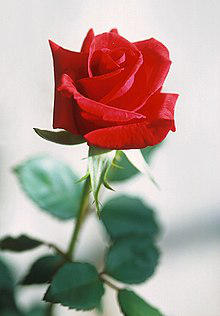

In [23]:
img = Image.fromarray(image_np)
img